# Data Mining Project

## 1. Import the needed libraries

In [2]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar 
import os, glob
import sompy
import matplotlib.cm as cm
from datetime import datetime, date
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from scipy.cluster.hierarchy import dendrogram
sns.set()

## 2. Import the dataset

In [6]:
data = pd.read_csv('donors.csv') 
data.head()

,Unnamed: 0,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,...,AVGGIFT,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,0,2009-01-01,GRI,0,IL,61081,,,1957-12-01,0,...,7.741935,95515,0,L,4,E,X,X,X,C
1,1,2014-01-01,BOA,1,CA,91326,,,1972-02-01,0,...,15.666667,148535,0,L,2,G,X,X,X,A
2,2,2010-01-01,AMH,1,NC,27017,,,NaN,0,...,7.481481,15078,1,L,4,E,X,X,X,C
3,3,2007-01-01,BRY,0,CA,95953,,,1948-01-01,0,...,6.812500,172556,1,L,4,E,X,X,X,C
4,4,2006-01-01,,0,FL,33176,,,1940-01-01,0,...,6.864865,7112,1,L,2,F,X,X,X,A


Make a copy of the original dataframe to perform a cohort analysis on top of that (in the A-priori grouping section).

In [37]:
data_cohort = data.copy()

## 3. Explore dataset

In [38]:
data.shape

(95412, 476)

In [39]:
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Data columns (total 476 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  95412 non-null  int64  
 1   ODATEDW     95412 non-null  object 
 2   OSOURCE     95412 non-null  object 
 3   TCODE       95412 non-null  int64  
 4   STATE       95412 non-null  object 
 5   ZIP         95412 non-null  object 
 6   MAILCODE    95412 non-null  object 
 7   PVASTATE    95412 non-null  object 
 8   DOB         71529 non-null  object 
 9   NOEXCH      95412 non-null  object 
 10  RECINHSE    95412 non-null  object 
 11  RECP3       95412 non-null  object 
 12  RECPGVG     95412 non-null  object 
 13  RECSWEEP    95412 non-null  object 
 14  MDMAUD      95412 non-null  object 
 15  DOMAIN      95412 non-null  object 
 16  HOMEOWNR    95412 non-null  object 
 17  CHILD03     95412 non-null  object 
 18  CHILD07     95412 non-null  object 
 19  CHILD12     95412 non-nu

In [40]:
data.duplicated().sum()

0

In [41]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(data.isnull().sum().nlargest(40))

RDATE_5     95403
RAMNT_5     95403
RDATE_3     95170
RAMNT_3     95170
RDATE_4     95131
RAMNT_4     95131
RDATE_6     94636
RAMNT_6     94636
RDATE_15    88150
RAMNT_15    88150
RDATE_23    87553
RAMNT_23    87553
RDATE_20    87524
RAMNT_20    87524
RDATE_7     86517
RAMNT_7     86517
RDATE_17    86011
RAMNT_17    86011
RDATE_21    85899
RAMNT_21    85899
RDATE_10    84951
RAMNT_10    84951
RDATE_13    83162
RAMNT_13    83162
NUMCHLD     83026
RDATE_11    80672
RAMNT_11    80672
RDATE_19    79535
RAMNT_19    79535
RDATE_9     78678
RAMNT_9     78678
RDATE_24    77674
RAMNT_24    77674
RDATE_18    75634
RAMNT_18    75634
RDATE_22    74539
RAMNT_22    74539
RDATE_8     73940
RAMNT_8     73940
RDATE_14    72095
dtype: int64


## 4. Data Cleaning and Preparation 

### 4.1 Remove Variables Manually 

In [42]:
eliminate_var = ['AC1', 'AC2', 'HC11', 'HC12', 'HC13', 'HC14', 'HC15' ,'HC16', 'HHN4', 'HHN5', 'HHN6', 'CHILC1', 'CHILC2', 
                'CHILC3', 'CHILC4', 'CHILC5', 'AGE903', 'AGE906', 'MDMAUD', 'RFA_2', 'HC3', 'HC4', 'HC5', 'HC6', 'HC7', 'HC8', 
                'VOC2', 'VOC3', 'GEOCODE', 'HVP1', 'HVP3', 'HVP4', 'RP2', 'RP3', 'IC15', 'IC16', 'IC17', 'IC18', 'IC19', 'IC20',
                'IC21', 'IC22', 'IC23', 'LIFESRC', 'DATASRCE', 'PVASTATE', 'CHILD03', 'CHILD07','CHILD12', 'CHILD18', 'NUMCHLD',
                'PUBCULIN','PUBHLTH','PUBDOITY','PUBNEWFN','PUBPHOTO','PUBOPP','PUBGARDN','MBCRAFT', 'MBGARDEN', 'MBBOOKS', 
                'MBCOLECT','MAGFAML', 'MAGFEM', 'MAGMALE', 'WEALTH1', 'WEALTH2', 'MSA', 'DMA', 'ADI','ZIP', 'OSOURCE']

data.drop(columns = eliminate_var, inplace = True)

Remove all RDATE_ and ADATE_ variables

In [43]:
for col in data.columns: 
    if 'RDATE_' in col: 
        del data[col] 

In [44]:
for col in data.columns: 
    if 'ADATE_' in col: 
        del data[col] 

### 4.2. Binarization

In [45]:
data['NOEXCH'].replace(['0', 0, ' '], 0, inplace = True)
data['NOEXCH'].replace(['1', 1, 'X'], 1, inplace = True)
# _ = can be exchanged
# X = do not exchange

In [46]:
data['MAILCODE'] = np.where(data["MAILCODE"].str.contains(" "), 1, 0)
# " " = Address is OK 
# B = Bad Address

In [47]:
data['RECINHSE'] = np.where(data["RECINHSE"].str.contains("X"), 1, 0)
# _ = Not an In House Record
# X = Donor has given to PVA's In House program

In [48]:
data['RECP3'] = np.where(data["RECP3"].str.contains("X"), 1, 0)
# _ = Not a P3 Record
# X = Donor has given to PVA's P3 program

In [49]:
data['RECPGVG'] = np.where(data["RECPGVG"].str.contains("X"), 1, 0)
#_ = Not a Planned Giving Record
# X = Planned Giving Record

In [50]:
data['RECSWEEP'] = np.where(data["RECSWEEP"].str.contains("X"), 1, 0)
# _ = Not a Sweepstakes Record
# X = Sweepstakes Record

In [51]:
# replace SOLP3 blank spaces with 20 
data['SOLP3'].replace(' ', '20', inplace = True)

In [52]:
# replace SOLIH blank spaces with 20 
data['SOLIH'].replace(' ', '20', inplace = True)

In [53]:
data['SOLP3'] = data['SOLP3'].astype(object)
data['SOLIH'] = data['SOLIH'].astype(object)

In [54]:
data['HOMEOWNR'].replace(['U', ' '], 0, inplace = True)
data['HOMEOWNR'].replace(['H'], 1, inplace = True)
# H = Home owner
# U = Unknown

In [55]:
data['MAJOR'] = np.where(data["MAJOR"].str.contains("X"), 1, 0)
# _ = Not a Major Donor
# X = Major Donor

In [56]:
data['PEPSTRFL'] = np.where(data["PEPSTRFL"].str.contains("X"), 1, 0)

In [57]:
# Variables about donor interests 
data['COLLECT1'] = np.where(data["COLLECT1"].str.contains("Y"), 1, 0)
data['VETERANS'] = np.where(data["VETERANS"].str.contains("Y"), 1, 0)
data['BIBLE'] = np.where(data["BIBLE"].str.contains("Y"), 1, 0)
data['CATLG'] = np.where(data["CATLG"].str.contains("Y"), 1, 0)
data['HOMEE'] = np.where(data["HOMEE"].str.contains("Y"), 1, 0)
data['PETS'] = np.where(data["PETS"].str.contains("Y"), 1, 0)
data['CDPLAY'] = np.where(data["CDPLAY"].str.contains("Y"), 1, 0)
data['STEREO'] = np.where(data["STEREO"].str.contains("Y"), 1, 0)
data['PCOWNERS'] = np.where(data["PCOWNERS"].str.contains("Y"), 1, 0)
data['PHOTO'] = np.where(data["PHOTO"].str.contains("Y"), 1, 0)
data['CRAFTS'] = np.where(data["CRAFTS"].str.contains("Y"), 1, 0)
data['FISHER'] = np.where(data["FISHER"].str.contains("Y"), 1, 0)
data['GARDENIN'] = np.where(data["GARDENIN"].str.contains("Y"), 1, 0)
data['BOATS'] = np.where(data["BOATS"].str.contains("Y"), 1, 0)
data['WALKER'] = np.where(data["WALKER"].str.contains("Y"), 1, 0)
data['KIDSTUFF'] = np.where(data["KIDSTUFF"].str.contains("Y"), 1, 0)
data['CARDS'] = np.where(data["CARDS"].str.contains("Y"), 1, 0)
data['PLATES'] = np.where(data["PLATES"].str.contains("Y"), 1, 0)

### 4.3. Missing Values  

Eliminate the rows which have missing values for the feature FISTDATE

In [58]:
data.drop(data[data['FISTDATE'].isna()].index, inplace = True)

Replace missing values in variables RAMNT with 0

In [63]:
colunas_RAMNT = []
for col in data.columns:
    if "RAMNT_" in col:
        colunas_RAMNT.append(col)
        
for col in colunas_RAMNT:
    data[col].fillna(0, inplace=True)

Replace blank spaces in GENDER with U (U = Unknown)

In [64]:
data['GENDER'].replace(" ", "U", inplace=True)

Build a function to get the correlations between every variable for a given dataset.

In [59]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [61]:
impute_vars_NEXTDATE = ['RAMNTALL','NGIFTALL','CARDGIFT','MINRAMNT','MINRDATE','MAXRAMNT','MAXRDATE','LASTGIFT','LASTDATE',
                        'FISTDATE','NEXTDATE','TIMELAG','AVGGIFT']

impute_vars_GEOCODE2 = ['GEOCODE2','POP901','POP902','POP903','POP90C1','POP90C2','POP90C3']

impute_vars_DOB = ['DOB','CHIL1','CHIL2','CHIL3','AGEC1','AGEC2','AGEC3','AGEC4','AGEC5','AGEC6','AGEC7']

impute_vars_DOMAIN = ['DOMAIN','IC1','IC2','IC3','IC4','IC5','HC17','HC18','HC19','HC20','HC21']

impute_vars_INCOME = ['INCOME','IC6','IC7','IC8','IC9','IC10','IC11','IC12','IC13','IC14']

Use get_top_abs_correlations function to get the correlations between the variables in impute_vars_INCOME.

In [62]:
df_INCOME = data[impute_vars_INCOME]
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(get_top_abs_correlations(df_INCOME, 70))

IC6     IC10    0.700843
IC11    IC12    0.652651
IC12    IC13    0.609595
IC7     IC11    0.607616
        IC10    0.599302
IC13    IC14    0.594418
IC10    IC11    0.593196
IC6     IC11    0.587086
IC12    IC14    0.576121
IC11    IC13    0.517517
IC7     IC12    0.512534
IC6     IC7     0.471032
        IC9     0.458843
        IC12    0.455425
IC8     IC11    0.417272
IC7     IC13    0.416794
IC8     IC12    0.412116
IC11    IC14    0.400397
INCOME  IC11    0.383895
IC10    IC12    0.383771
IC7     IC14    0.372204
INCOME  IC6     0.368665
IC6     IC13    0.360319
IC8     IC13    0.353670
INCOME  IC10    0.351335
IC8     IC14    0.344236
INCOME  IC7     0.343667
IC9     IC10    0.341205
INCOME  IC12    0.339157
IC7     IC8     0.338145
IC6     IC14    0.303098
INCOME  IC13    0.284645
        IC14    0.269308
IC10    IC13    0.259271
IC8     IC10    0.256390
INCOME  IC8     0.191504
IC9     IC14    0.191021
IC7     IC9     0.184209
IC8     IC9     0.154740
IC9     IC13    0.135388


Replace blank spaces with NaN and check any missing values 

In [65]:
data.replace(" ", np.nan, inplace=True)

In [66]:
nan_columns = data.columns[data.isna().any()]
nan_columns

Index(['DOB', 'DOMAIN', 'INCOME', 'RFA_3', 'RFA_4', 'RFA_5', 'RFA_6', 'RFA_7',
       'RFA_8', 'RFA_9', 'RFA_10', 'RFA_11', 'RFA_12', 'RFA_13', 'RFA_14',
       'RFA_15', 'RFA_16', 'RFA_17', 'RFA_18', 'RFA_19', 'RFA_20', 'RFA_21',
       'RFA_22', 'RFA_23', 'RFA_24', 'NEXTDATE', 'TIMELAG', 'GEOCODE2'],
      dtype='object')

Replace in RFA_3 to RFA_24 every missing value with U0U, where each zero means absence of Recency, Frequency and Amount. Therefore, we assume a person with no labels for this variables never donated.

In [67]:
RFA_missing = ['RFA_3', 'RFA_4', 'RFA_5', 'RFA_6', 'RFA_7', 'RFA_8', 'RFA_9', 'RFA_10',
       'RFA_11', 'RFA_12', 'RFA_13', 'RFA_14', 'RFA_15', 'RFA_16', 'RFA_17',
       'RFA_18', 'RFA_19', 'RFA_20', 'RFA_21', 'RFA_22', 'RFA_23', 'RFA_24']

for col in RFA_missing:
    data[col].fillna('U0U', inplace = True)

Get the variables to impute missing values in data, except for TIMELAG, because those missing values will be obtained from the difference between NEXTDATE and FISTDATE. 

In [68]:
nan_columns = data.columns[data.isna().any()].drop('TIMELAG')
nan_columns

Index(['DOB', 'DOMAIN', 'INCOME', 'NEXTDATE', 'GEOCODE2'], dtype='object')

Transform the variables with missing values into columns whose values are strings in order to use LabelEncoder.

In [69]:
# for col in nan_columns:
#     data[col] = data[col].astype(str)

Transform the nan_columns into ordinal variables, in order to use in the KNN Imputer.

In [70]:
# le1 = LabelEncoder()
# le2 = LabelEncoder()
# le3 = LabelEncoder()
# le4 = LabelEncoder()
# le5 = LabelEncoder()
# le6 = LabelEncoder()
# le7 = LabelEncoder()
# le8 = LabelEncoder()
# le9 = LabelEncoder()

In [71]:
# data['DOB'] = le1.fit_transform(data['DOB'])
# data['DOMAIN'] = le2.fit_transform(data['DOMAIN'])
# data['INCOME'] = le3.fit_transform(data['INCOME'])
# data['NEXTDATE'] = le4.fit_transform(data['NEXTDATE'])
# data['GEOCODE2'] = le5.fit_transform(data['GEOCODE2'])
# data['MINRDATE'] = le6.fit_transform(data['MINRDATE'])
# data['MAXRDATE'] = le7.fit_transform(data['MAXRDATE'])
# data['LASTDATE'] = le8.fit_transform(data['LASTDATE'])
# data['FISTDATE'] = le9.fit_transform(data['FISTDATE'])

Replace the category with the highest number, which corresponds to the missing values, with nan, for all the variables, since the Label Encoder assigns the nans to the highest number among all categories, in order to further impute those missing values.

In [72]:
# for col in nan_columns:
#     data[col].replace(data[col].unique().max(), np.nan, inplace = True)

In [73]:
# nan_columns_values = []
# for col in nan_columns:
#     nan_columns_values.append(data[col].unique())
# print(nan_columns_values)

Transform the datatypes of the variables with missing values into float in order to use KNN Imputer.

In [74]:
# for col in nan_columns:
#     data[col] = data[col].astype(float)

Create an instance of KNN Imputer

In [75]:
# imputer = KNNImputer(n_neighbors=1)

Fit an instance of KNN Imputer to each dataframe created for filling in the missing values of a specific feature.

In [76]:
# filled_data_DOB = imputer.fit_transform(data[impute_vars_DOB])
# filled_data_DOMAIN = imputer.fit_transform(data[impute_vars_DOMAIN])
# filled_data_INCOME = imputer.fit_transform(data[impute_vars_INCOME])
# filled_data_NEXTDATE = imputer.fit_transform(data[impute_vars_NEXTDATE])
# filled_data_GEOCODE2 = imputer.fit_transform(data[impute_vars_GEOCODE2])

Create a new dataset for each variable whose missing values were imputed, along with the variables used to impute those missing values.

In [77]:
# data_DOB = pd.DataFrame(filled_data_DOB, columns = data[impute_vars_DOB].columns, index = data.index)
# data_DOMAIN = pd.DataFrame(filled_data_DOMAIN, columns = data[impute_vars_DOMAIN].columns, index = data.index)
# data_INCOME = pd.DataFrame(filled_data_INCOME, columns = data[impute_vars_INCOME].columns, index = data.index)
# data_NEXTDATE = pd.DataFrame(filled_data_NEXTDATE, columns = data[impute_vars_NEXTDATE].columns, index = data.index)
# data_GEOCODE2 = pd.DataFrame(filled_data_GEOCODE2, columns = data[impute_vars_GEOCODE2].columns, index = data.index)

Concatenate every dataset created in the previous cell in order to further concatenate those with the original dataset.

In [78]:
# data_missing_filled = pd.concat([data_DOB, data_DOMAIN, data_INCOME, data_NEXTDATE, data_GEOCODE2], axis = 1)

Label Encoder inverse_transform in order to have the original categories for each feature.

In [79]:
# data_missing_filled['DOB'] = le1.inverse_transform(data_missing_filled['DOB'].astype(int))
# data_missing_filled['DOMAIN'] = le2.inverse_transform(data_missing_filled['DOMAIN'].astype(int))
# data_missing_filled['INCOME'] = le3.inverse_transform(data_missing_filled['INCOME'].astype(int))
# data_missing_filled['NEXTDATE'] = le4.inverse_transform(data_missing_filled['NEXTDATE'].astype(int))
# data_missing_filled['GEOCODE2'] = le5.inverse_transform(data_missing_filled['GEOCODE2'].astype(int))
# data_missing_filled['MINRDATE'] = le6.inverse_transform(data_missing_filled['MINRDATE'].astype(int))
# data_missing_filled['MAXRDATE'] = le7.inverse_transform(data_missing_filled['MAXRDATE'].astype(int))
# data_missing_filled['LASTDATE'] = le8.inverse_transform(data_missing_filled['LASTDATE'].astype(int))
# data_missing_filled['FISTDATE'] = le9.inverse_transform(data_missing_filled['FISTDATE'].astype(int))

Eliminate the variables used to impute missing values in order to not have duplicate features in the original dataset.

In [80]:
# variables_to_drop = ['RAMNTALL','NGIFTALL','CARDGIFT','MINRAMNT','MINRDATE','MAXRAMNT','MAXRDATE','LASTGIFT','LASTDATE',
#                   'FISTDATE','NEXTDATE','TIMELAG','AVGGIFT','GEOCODE2','POP901','POP902','POP903','POP90C1','POP90C2','POP90C3',
#                   'DOB','CHIL1','CHIL2','CHIL3','AGEC1','AGEC2','AGEC3','AGEC4','AGEC5','AGEC6','AGEC7','DOMAIN','HC17','HC18',
#                   'HC19','HC20','HC21','INCOME','IC1','IC2','IC3','IC4','IC5','IC6','IC7','IC8','IC9','IC10','IC11','IC12',
#                   'IC13','IC14']

In [81]:
# data.drop(variables_to_drop, axis = 1, inplace = True)

In [82]:
# data = pd.concat([data,data_missing_filled], axis = 1)

Save the changes to a csv in order not to run KNN everytime we open the notebook

In [83]:
# columns_missing_values = []
# for col in nan_columns:
#     columns_missing_values.append(data[col].unique())
# print(columns_missing_values)

In [84]:
# data.to_csv("data_filled.csv")

Open csv to work on it

In [76]:
data = pd.read_csv('data_filled.csv')

data.drop(columns = ['CONTROLN', 'Unnamed: 0'], inplace=True)

Convert data columns in datetime 

In [77]:
columns_dates = []
for col in data.columns: 
    if 'DATE' in col:
        columns_dates.append(col)
        data[col] = pd.to_datetime(data[col])
    elif 'DOB' in col:
        columns_dates.append(col)
        data[col] = pd.to_datetime(data[col])

### 4.4. Transform and Creating Variables  

Create variable AGE from DOB (date of birth)

In [78]:
# Use 2018 since it is the most recent date in the dataset 
data['AGE'] = 2018 - pd.DatetimeIndex(data['DOB']).year

data.drop(columns=['DOB'], inplace=True)

Get the oldest dates between ODATEW e FISTDATE and assign to a new variable 

In [79]:
data['FIRSTDATE'] = np.where(data['FISTDATE'] <= data['ODATEDW'], data['FISTDATE'], data['ODATEDW'])

data.drop(columns=['FISTDATE', 'ODATEDW'], inplace=True)

Join percentage household income (reduce number of categories)

In [80]:
data['IC6'] = data['IC6'] + data['IC7']
data['IC8'] = data['IC8'] + data['IC9']
data['IC10'] = data['IC10'] + data['IC11']
data['IC12'] = data['IC12'] + data['IC13']

data.drop(columns=['IC7', 'IC9', 'IC11', 'IC13'], inplace=True)

Join percentage adults age (reduce number of categories)

In [81]:
data['AGEC2'] = data['AGEC2'] + data['AGEC3']
data['AGEC4'] = data['AGEC4'] + data['AGEC5']
data['AGEC6'] = data['AGEC6'] + data['AGEC7']

data.drop(columns=['AGEC3', 'AGEC5', 'AGEC7'], inplace=True)

Join percentage ancestry (reduce number of categories)

In [82]:
data['ANC_S'] = data['ANC5'] + data['ANC8'] + data['ANC11']
data['ANC_W'] = data['ANC1'] + data['ANC2'] + data['ANC3'] + data['ANC4'] + data['ANC7'] + data['ANC13']
data['ANC_N'] = data['ANC9'] + data['ANC14']
data['ANC_E'] = data['ANC6'] + data['ANC10'] + data['ANC12'] + data['ANC15']

data.drop(columns=['ANC1', 'ANC2', 'ANC3', 'ANC4', 'ANC5', 'ANC6', 'ANC7', 'ANC8', 'ANC9', 'ANC10', 'ANC11', 'ANC12', 'ANC13',
                   'ANC14', 'ANC15'], inplace=True)

Divide DOMAIN column in 2 columns 

In [83]:
data['DOMAIN_Urban'] = data['DOMAIN'].astype(str).str[0]
data['DOMAIN_Socio'] = data['DOMAIN'].astype(str).str[1]

data.drop(columns=['DOMAIN'], inplace=True)

Convert DOMAIN_Urban variable into a binary one

In [84]:
data['DOMAIN_Urban'] = np.where((data['DOMAIN_Urban'] == 'T') | (data['DOMAIN_Urban'] == 'R'),0,1)

There are some values of RFA_23 which does not have any values assigned to the first byte (Recency). Therefore, those rows where this error exists, will be removed.

In [85]:
RFA_23_wrong_cags = ['2F', '1D', '1C', '1G', '2E', '1F', '4E', '3F', '3E', '2D', '1E']

In [86]:
for cag in RFA_23_wrong_cags:
    data['RFA_23'].replace(cag, 'U0U', inplace = True)

Divide RFA_ columns in 3 columns  

In [87]:
RFA_Columns = ['RFA_3', 'RFA_4', 'RFA_5', 'RFA_6', 'RFA_7', 'RFA_8', 'RFA_9', 'RFA_10', 'RFA_11', 'RFA_12', 'RFA_13', 'RFA_14', 
               'RFA_15', 'RFA_16', 'RFA_17', 'RFA_18', 'RFA_19', 'RFA_20', 'RFA_21', 'RFA_22', 'RFA_23', 'RFA_24']

for var in RFA_Columns:
    data[var+'R'] = data[var].astype(str).str[0]
    data[var+'F'] = data[var].astype(str).str[1]
    data[var+'A'] = data[var].astype(str).str[2]
    
data.drop(RFA_Columns, axis=1, inplace=True)

Transform all RFA_F variables into int dataype. 

In [88]:
RFA_NF = ['RFA_3F', 'RFA_4F', 'RFA_5F', 'RFA_6F', 'RFA_7F', 'RFA_8F', 'RFA_9F', 'RFA_10F', 'RFA_11F', 'RFA_12F', 'RFA_13F',
          'RFA_14F', 'RFA_15F', 'RFA_16F', 'RFA_17F', 'RFA_18F', 'RFA_19F', 'RFA_20F', 'RFA_21F', 'RFA_22F', 'RFA_23F',
          'RFA_24F']

for RFA in RFA_NF:
    data[RFA] = data[RFA].astype(int)

Simplify TCODE for easier use

In [89]:
data['TCODE'] = np.where((data['TCODE'] == 0) | (data['TCODE'] == 1) | (data['TCODE'] == 2) 
                         | (data['TCODE'] == 28),data['TCODE'],1000)

Group States by Region

In [90]:
#Correct number of States
states = ["ME","NH","VT","MA","RI","CT","NY","PA","NJ","WI","MI","IL","IN","OH",
          "MO","SD","ND","NE","KS","MN","IA","DE","MD","VA","WV","NC","SC","GA","FL","DC",
          "KY","TN","MS","AL","OK","TX","AR","LA","ID","WY","NV","UT","CO","AZ","NM",
          "CA","OR","WA","AK","HI","MT"]

data = data[data['STATE'].isin(states)]

In [91]:
states_northeast = ["ME","NH","VT","MA","RI","CT","NY","PA","NJ"]
states_centre_west= ["WI","MI","IL","IN","OH","MO","SD","ND","NE","KS","MN","IA"] 
states_south = ["DE","MD","VA","WV","NC","SC","GA","FL","DC","KY","TN","MS","AL","OK","TX","AR","LA"]
states_west = ["ID","WY","NV","UT","CO","AZ","NM","CA","OR","WA","AK","HI","MT"]

In [92]:
data['STATE'] = np.where((data['STATE'].isin(states_northeast)),'RNE',data['STATE'])
data['STATE'] = np.where((data['STATE'].isin(states_centre_west)),'RCW',data['STATE'])
data['STATE'] = np.where((data['STATE'].isin(states_south)),'RS',data['STATE'])
data['STATE'] = np.where((data['STATE'].isin(states_west)),'RW',data['STATE'])

Transform Gender in a binary feature

In [93]:
data['FEMALE'] = np.where(data["GENDER"].str.contains("F"), 1, 0)
# 1-female
# 0-others

data.drop(columns=['GENDER'], inplace=True)

Grouping RFA_Amount variables in 3 categories

In [94]:
for i in range(2,25):
    string = 'RFA_' + str(i) + 'A'
    data[string] = np.where((data[string] == 'A') | (data[string] == 'B') 
                    | (data[string] == 'C') | (data[string] == 'D'),'A',data[string])
    data[string] = np.where((data[string] == 'E') | (data[string] == 'F') ,'B',data[string])

Grouping RFA_Recency variables in 5 categories

In [95]:
for i in range(2,25):
    string = 'RFA_' + str(i) + 'R'
    data[string] = np.where((data[string] == 'A') | (data[string] == 'S'),'G',data[string])
    data[string] = np.where((data[string] == 'F') | (data[string] == 'N'),'R',data[string])
    data[string] = np.where((data[string] == 'U') | (data[string] == 'P')
                             | (data[string].astype(str) == '0'),'U',data[string])

Transform GEOCODE2 variable into binary one

In [96]:
data['Urbanized_County'] = np.where((data['GEOCODE2'] == 'D'),0,1)

data.drop(columns=['GEOCODE2'], inplace=True)

Get the number of months between the most recent date and all datetime variables in order to transform those features' datatypes into int datatypes.

In [97]:
max_year = data.MAXADATE.max().year
max_month = data.MAXADATE.max().month

for col in data.columns:
    if "DATE" in col:
        data[col] = ((max_year - data[col].dt.year) * 12 + max_month - data[col].dt.month).astype('Int64')

### 4.5. Outliers 

Define nominal, ordinal, binary and metric variables.

In [98]:
nominal_variables = ['TCODE', 'STATE', 'SOLP3', 'SOLIH', 'RFA_2R', 'RFA_2A', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A',
                     'RFA_3R', 'RFA_3A', 'RFA_4R', 'RFA_4A', 'RFA_5R', 'RFA_5A', 'RFA_6R', 'RFA_6A',
                     'RFA_7R', 'RFA_7A', 'RFA_8R', 'RFA_8A', 'RFA_9R', 'RFA_9A', 'RFA_10R', 'RFA_10A', 'RFA_11R', 'RFA_11A', 
                     'RFA_12R', 'RFA_12A', 'RFA_13R', 'RFA_13A', 'RFA_14R', 'RFA_14A', 'RFA_15R', 'RFA_15A', 'RFA_16R',
                     'RFA_16A', 'RFA_17R', 'RFA_17A', 'RFA_18R', 'RFA_18A', 'RFA_19R', 'RFA_19A', 'RFA_20R', 'RFA_20A',
                     'RFA_21R', 'RFA_21A', 'RFA_22R', 'RFA_22A', 'RFA_23R', 'RFA_23A', 'RFA_24R', 'RFA_24A']

ordinal_variables = ['INCOME', 'DOMAIN_Socio']

binary_variables = ['MAILCODE', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP', 'HOMEOWNR', 'FEMALE', 'MAJOR',
                    'MAJOR', 'COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'PETS', 'CDPLAY', 'STEREO', 'PCOWNERS', 'PHOTO',
                    'CRAFTS', 'FISHER', 'GARDENIN', 'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES', 'PEPSTRFL', 'HPHONE_D', 
                    'Urbanized_County', 'DOMAIN_Urban']

In [99]:
metric_variables = data.drop(columns=binary_variables)
metric_variables = metric_variables.drop(columns=ordinal_variables)
metric_variables = metric_variables.drop(columns=nominal_variables)

metric_variables = metric_variables.columns

#### Local Outlier Factor

Define an instance of LocalOutlierFactor.

In [100]:
LOF = LocalOutlierFactor(n_neighbors=20)

Fit Local Outlier Factor to the data of the metric variables and predict which observations are outliers (-1) and inliers (1).

In [101]:
obs_labels = LOF.fit_predict(data[metric_variables])

Assign to each observation the label of either outlier or inlier, by concatenating obs_labels column to 'data'.

In [102]:
data = pd.concat((data.reset_index(), pd.Series(obs_labels, name= 'Labels')), axis = 1)

Eliminate the outliers found by the Local Outlier Factor.

In [103]:
print('Proportion of data removed from the dataframe:', data[data['Labels'] == -1].shape[0] / data.shape[0])
data.drop(data[data['Labels'] == -1].index, inplace = True)
data.drop(columns='Labels', inplace=True)

Proportion of data removed from the dataframe: 0.01418886300191004


In [104]:
variables_outliers = ['AVGGIFT', 'TIMELAG', 'LASTGIFT', 'MAXRAMNT', 'MINRAMNT', 'CARDGIFT', 
                    'NGIFTALL', 'RAMNTALL', 'RAMNT_24', 'RAMNT_23', 'RAMNT_22', 'RAMNT_21',
                    'RAMNT_20', 'RAMNT_19', 'RAMNT_18', 'RAMNT_17', 'RAMNT_16', 'RAMNT_15',
                    'RAMNT_14', 'RAMNT_13', 'RAMNT_12', 'RAMNT_11', 'RAMNT_10', 'RAMNT_9',
                    'RAMNT_8', 'RAMNT_7', 'RAMNT_6', 'RAMNT_5', 'RAMNT_4', 'RAMNT_3', 
                    'NUMPRM12', 'CARDPM12', 'NUMPROM', 'CARDPROM', 'MHUC2', 'MHUC1', 'EC1',
                    'TPE11', 'TPE10', 'IC5', 'IC4', 'IC3', 'IC2', 'IC1', 'RHP4', 'RHP3',
                    'RHP2', 'RHP1', 'HV4', 'HV3', 'HV2', 'HV1', 'HHP2', 'HHP1',
                    'AGE905', 'AGE904', 'AGE902', 'AGE901', 'POP903', 'POP902', 'POP901',
                    'HIT', 'AGE']

In [105]:
# data_outliers = data[metric_variables]

# filters = []

# for var in metric_variables:
#     q25 = data[var].quantile(.25)
#     q75 = data[var].quantile(.75)
#     iqr = (q75 - q25)

#     upper_lim = q75 + (900000 * iqr)
#     lower_lim = q25 - (900000 * iqr)

#     filters.append(data[var].between(lower_lim, upper_lim, inclusive=True))
    
# data_IQR = data_outliers[np.all(filters, 0)]
# print('Percentage of data kept after removing outliers:', np.round(data_IQR.shape[0] / data_outliers.shape[0], 4))

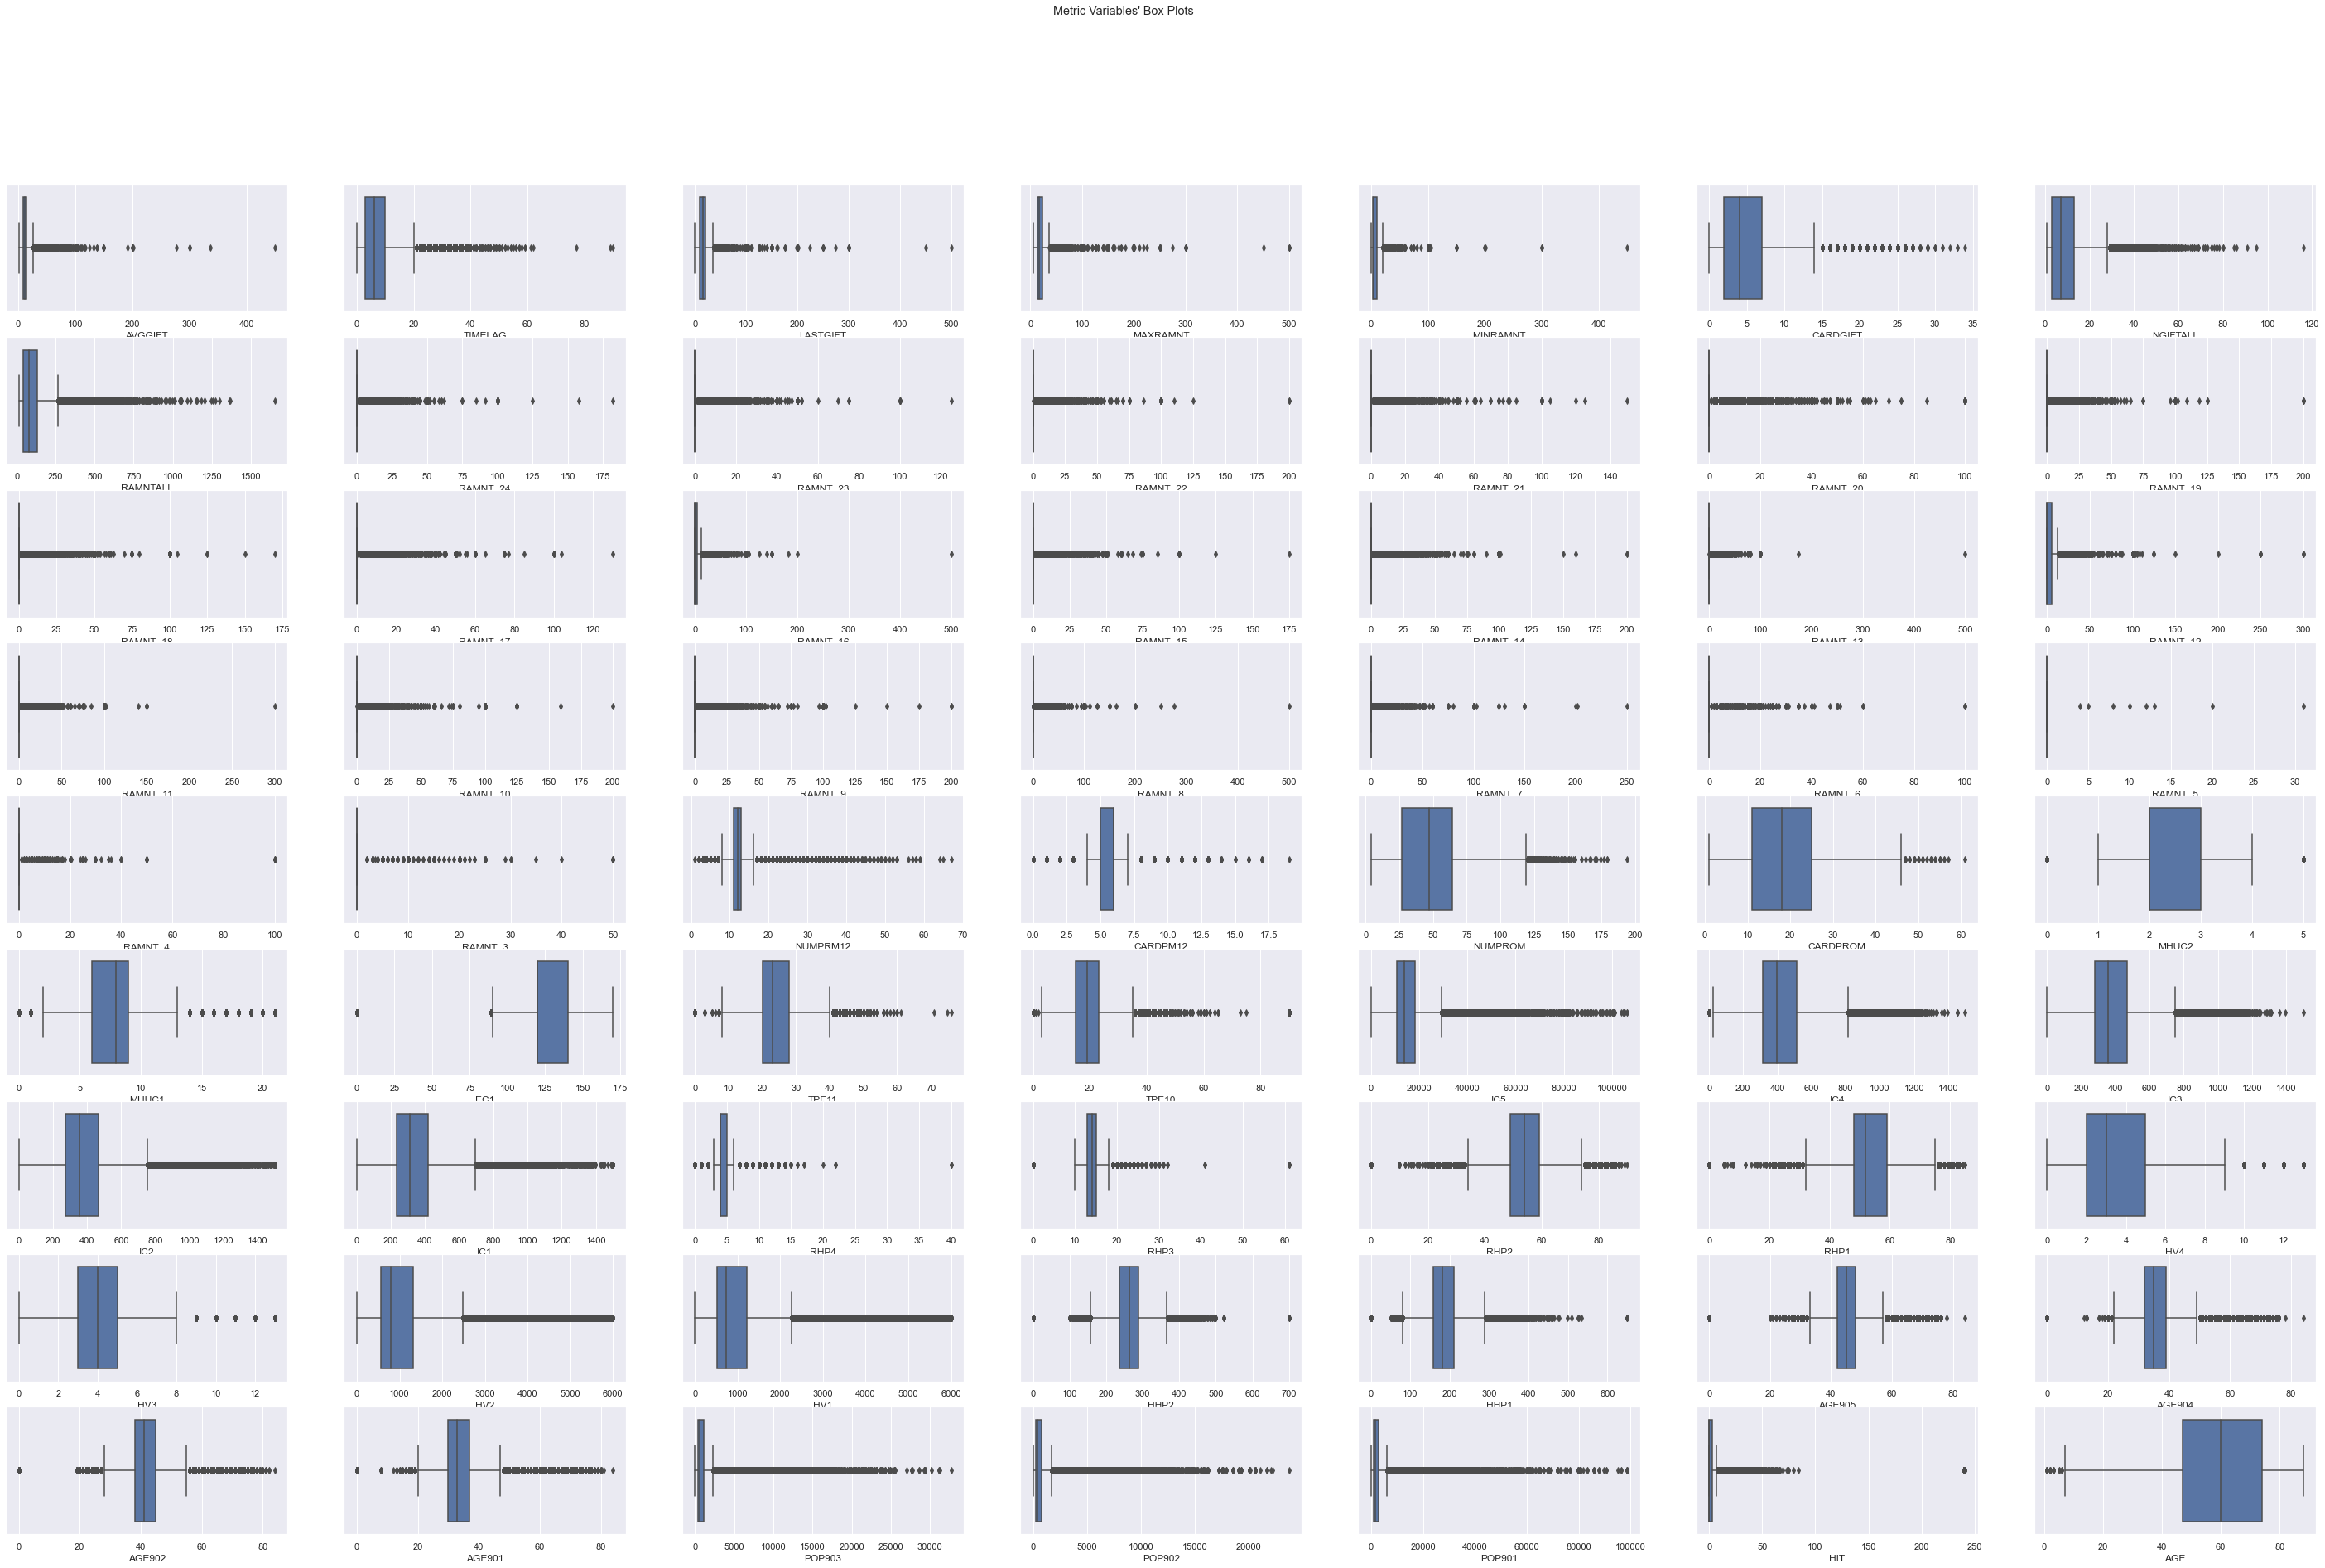

In [106]:
fig, axes = plt.subplots(9, 7 , figsize = (50,30))

for ax, feat in zip(axes.flatten(), variables_outliers): 
    sns.boxplot(data[feat], ax=ax)

plt.suptitle("Metric Variables' Box Plots")
plt.show()

Remove outliers manually 

In [107]:
outliers = (data['AVGGIFT'] > 400) | (data['TIMELAG'] > 80) | (data['LASTGIFT'] > 400) | (data['MAXRAMNT'] > 400) | (data['MINRAMNT'] > 400) | (data['RAMNTALL'] > 1500) | (data['RAMNT_24'] > 150) | (data['RAMNT_23'] > 120) | (data['RAMNT_22'] > 175) | (data['RAMNT_21'] > 140) | (data['RAMNT_19'] > 175) | (data['RAMNT_17'] > 120) | (data['RAMNT_16'] > 400) | (data['RAMNT_15'] > 150) | (data['RAMNT_14'] > 175) | (data['RAMNT_13'] > 400) | (data['RAMNT_11'] > 250) | (data['RAMNT_10'] > 175) | (data['RAMNT_8'] > 400) | (data['RAMNT_6'] > 80) | (data['RAMNT_5'] > 30) | (data['RAMNT_4'] > 80) | (data['EC1'] < 5) | (data['RHP4'] > 35) | (data['RHP3'] > 60) | (data['HHP2'] > 600) | (data['AGE905'] < 5) | (data['AGE904'] < 5) | (data['AGE902'] < 5) | (data['AGE901'] < 5) | (data['HIT'] > 200)

df_outliers = data[outliers]
print('Proportion of data removed from the dataframe:', np.round(df_outliers.shape[0] / data.shape[0], 3))

Proportion of data removed from the dataframe: 0.008


In [108]:
data.drop(data[outliers].index, inplace = True)

### 4.6. Coherence Checking

In [109]:
# The sum of the Percent Population in Urbanized Area, Percent Population Outside Urbanized Area and Percent Population Inside
# Rural Area cannot be lower than 99% (because of rounding errors) or higher than 101% (because of rounding errors).

data['SUMPOP90C1POP90C2POP90C3'] = data['POP90C1'] + data['POP90C2'] + data['POP90C3']
incoherence_1 = data[['POP90C1','POP90C2','POP90C3']].get((data['SUMPOP90C1POP90C2POP90C3'] < 99) | (data['SUMPOP90C1POP90C2POP90C3'] > 101))
data.drop(incoherence_1.index,inplace = True)
data.drop('SUMPOP90C1POP90C2POP90C3', axis = 1, inplace = True)

In [110]:
# The sum of the Percent of Male with Percent of Female cannot be lower than 99% (because of rounding errors) or higher than 
# 101% (because of rounding errors).

data['POPPERCENT'] = data['POP90C4'] + data['POP90C5']
incoherence_2 = data[['POP90C4','POP90C5']].get((data['POPPERCENT'] < 99) | (data['POPPERCENT'] > 101))
data.drop(incoherence_2.index,inplace = True)
data.drop('POPPERCENT', axis = 1, inplace = True)

In [111]:
# The sum of the Percent of Children Under Age 7, Percent of Children Age 7-14 and Percent of Children Age 14-17 cannot be lower
# than 99% (because of rounding errors) or higher than 101% (because of rounding errors).

data['SUMPERCENTPOPCHIL'] = data['CHIL1'] + data['CHIL2'] + data['CHIL3']
incoherence_3 = data[['CHIL1','CHIL2','CHIL3']].get((data['SUMPERCENTPOPCHIL'] < 99) | (data['SUMPERCENTPOPCHIL'] > 101))
data.drop(incoherence_3.index,inplace = True)
data.drop('SUMPERCENTPOPCHIL', axis = 1, inplace = True)

In [112]:
# The sum of the all AGEC variables cannot be lower than 97% (because of rounding errors) or higher than 103%
# (because of rounding errors).

data['SUMPERCENTPOPADUL'] = data['AGEC1'] + data['AGEC2'] + data['AGEC4'] + data['AGEC6']
incoherence_4 = data[['AGEC1','AGEC2','AGEC4','AGEC6']].get((data['SUMPERCENTPOPADUL'] < 97) | (data['SUMPERCENTPOPADUL'] > 103))
data.drop(incoherence_4.index,inplace = True)
data.drop('SUMPERCENTPOPADUL', axis = 1, inplace = True)

In [113]:
# The sum of the Percent of Married, Separated or Divorced, Widowed and Never Married must not be lower than 99% 
# (because of rounding errors) or higher than 101% (because of rounding errors).

data['SUMMARR'] = data['MARR1'] + data['MARR2'] + data['MARR3'] + data['MARR4']
incoherence_5 = data[['MARR1','MARR2','MARR3','MARR4']].get((data['SUMMARR'] < 99) | (data['SUMMARR'] > 101))
data.drop(incoherence_5.index,inplace = True)
data.drop('SUMMARR', axis = 1, inplace = True)

In [114]:
# The Percentage of Households with a person older than 65 cannot be lower than the The Percentage of Households with a person 
# older than 65 living alone, but it does not exist.

incoherence_6 = data[data['HHAGE1'] < data['HHAGE2']]

In [115]:
# The Sum of the Percent of 1 Person Households with the Percent of 2 Person Households and the Percent of 3 or more Persons 
# Households must not be lower than 99% (because of rounding errors) or higher than 101% (because of rounding errors).

data['SUMPERCENTHOUSEHOLD'] = data['HHN1'] + data['HHN2'] + data['HHN3']
incoherence_7 = data[['HHN1','HHN2','HHN3']].get((data['SUMPERCENTHOUSEHOLD'] < 99) | (data['SUMPERCENTHOUSEHOLD'] > 101))
data.drop(incoherence_7.index, inplace = True)
data.drop('SUMPERCENTHOUSEHOLD', axis = 1, inplace = True)

In [116]:
# The sum of the percentage of Owner + Renter ocuppied house units cannot be lower than 99% (because of rounding errors) or 
# higher than 101% (because of rounding errors).

data['SUMHU1HU2'] = data['HU1'] + data['HU2']
incoherence_8 = data[['HU1','HU2']].get((data['SUMHU1HU2'] < 99) | (data['SUMHU1HU2'] > 101))
data.drop(incoherence_8.index, inplace = True)
data.drop('SUMHU1HU2', axis = 1, inplace = True)

In [117]:
# The sum of the percentage of occupied housing units with the percentage of vacant housing units cannot be higher than 101%
# or lower than 99% (because of rounding errors).

data['SUMHU3HU4'] = data['HU3'] + data['HU4']
incoherence_9 = data[['HU3','HU4']].get((data['SUMHU3HU4'] < 99) | (data['SUMHU3HU4'] > 101))
data.drop(incoherence_9.index, inplace = True)
data.drop('SUMHU3HU4', axis = 1, inplace = True)

In [118]:
# The Percent Households w/ Related Children cannot be higher than the Percent Households w/ Families but there are no rows
# which meet this incoherence.

incoherence_10 = data[['HHD1','HHD2']].get(data['HHD1'] > data['HHD2'] )

In [119]:
# The Percent Married Couples w/ Related Children cannot be higher than the Percent Married Couple Families but there are no 
# rows which meet this incoherence.

incoherence_11 = data[['HHD3','HHD4']].get(data['HHD3'] < data['HHD4'] )

In [120]:
# The sum of the Percent Persons in Family Household with Percent Persons in Non-Family Household cannot be higher than 101% or
# lower than 99% (because of rounding errors).

incoherence_12 = data[['HHD5','HHD6']].get((data['HHD5'] + data['HHD6'] < 99) | (data['HHD5'] + data['HHD6'] > 101))
data.drop(incoherence_12.index, inplace = True)

In [121]:
# The sum of the Percent Male Householder w/ Child with the Percent Female Householder w/ Child cannot be higher than the
# Percent Single Parent Households + 1 (because of rounding errors) or lower than Percent Single Parent Households - 1 
# (because of rounding errors), but there are no rows which meet this incoherence.

incoherence_13 = data[['HHD7','HHD8','HHD9']].get((data['HHD8'] + data['HHD9'] > data['HHD7'] + 1) | (data['HHD8'] + data['HHD9'] < data['HHD7'] - 1))

In [122]:
# The sum of ETHC1, ETHC2 and ETHC3 must not be lower than ETH1 - 1 (because of rounding errors) or higher than ETH1 + 1 
# (because of rounding errors).

data['SUMETHC1ETHC2ETHC3'] = data['ETHC1'] + data['ETHC2'] + data['ETHC3']
incoherence_14 = data[['ETH1','SUMETHC1ETHC2ETHC3']].get((data['ETH1'] > data['SUMETHC1ETHC2ETHC3'] + 1) | (data['ETH1'] < data['SUMETHC1ETHC2ETHC3'] - 1))
data.drop(incoherence_14.index, inplace = True)
data.drop('SUMETHC1ETHC2ETHC3', axis = 1, inplace = True)

In [123]:
# The sum of ETHC4, ETHC5 and ETHC6 must not be lower than ETH2 - 1 (because of rounding errors) or higher than ETH2 + 1 
# (because of rounding errors).

data['SUMETHC4ETHC5ETHC6'] = data['ETHC4'] + data['ETHC5'] + data['ETHC6']
incoherence_15 = data[['ETH2','SUMETHC4ETHC5ETHC6']].get((data['ETH2'] > data['SUMETHC4ETHC5ETHC6'] + 1) | (data['ETH2'] < data['SUMETHC4ETHC5ETHC6'] - 1))
data.drop(incoherence_15.index, inplace = True)
data.drop('SUMETHC4ETHC5ETHC6', axis = 1, inplace = True)

In [124]:
# The Percent Adult Veterans Age 16+ cannot be lower than the sum of Percent Male Veterans Age 16+ with Percent Female Veterans 
# Age 16+, but there are no rows which meet this incoherence.

data['SUMAFC5AFC6'] = data['AFC5'] + data['AFC6']
incoherence_16 = data[['AFC5','AFC6','SUMAFC5AFC6']].get(data['SUMAFC5AFC6'] < data['AFC4'])
data.drop('SUMAFC5AFC6', axis = 1, inplace = True)

In [125]:
# The Number of lifetime gifts to card promotions to date cannot be higher than the Number of lifetime gifts to date, but there
# are no rows which meet this incoherence.

incoherence_17 = data[['CARDGIFT','NGIFTALL']].get(data['CARDGIFT'] > data['NGIFTALL'])

In [126]:
# The Dollar amount of smallest gift to date cannot be higher than the Dollar amount of largest gift to date, but there are no 
# rows which meet this incoherence.

incoherence_18 = data[['MINRAMNT','MAXRAMNT']].get(data['MINRAMNT'] > data['MAXRAMNT'])

In [127]:
# The Date of first gift cannot be more recent than the Date of second gift, but there are no rows which meet this incoherence.

incoherence_19 = data[['FIRSTDATE','NEXTDATE']].get((data['FIRSTDATE'] > data['NEXTDATE']) & (data['NEXTDATE'] != '1900-01-01'))

In [128]:
#The sum of all RAMNT cannot be higher than RAMNTALL.
RAMNT_ = ['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7','RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 
          'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 
          'RAMNT_22', 'RAMNT_23', 'RAMNT_24']

sum_ = 0
for var in RAMNT_:
    sum_ += (data[var] != 0)
    
incoherence_20 = data.get(sum_ > data['RAMNTALL'])
data.drop(incoherence_20.index,inplace = True)

In [129]:
# RAMNT count (exceto os RAMNT = 0) has to be lower or equal to NGIFTALL.

count_ = 0
for var in RAMNT_:
    count_ += (data[var] != 0).astype(int)
    
incoherence_21 = data.get(count_ > data['NGIFTALL'])
data.drop(incoherence_21.index,inplace = True)

In [130]:
# RAMNT count for each person cannot be higher than CARDGIFT for the following promotions: FS, GK, TK, SK, NK, XK, UF, UU.

RAMNT_1 = ['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_8', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 
           'RAMNT_15', 'RAMNT_18', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']

count_ = 0
for var in RAMNT_1:
    count_ += (data[var] != 0).astype(int)
    
incoherence_22 = data.get(count_ > data['CARDGIFT'])
data.drop(incoherence_22.index,inplace = True)

In [131]:
# MINRAMNT must not be higher than the lowest RAMNT (excluding 0).

incoherence_23 = data.get((data[RAMNT_].get(data[RAMNT_] > 0).min(axis=1)) < data['MINRAMNT'])

data.drop(incoherence_23.index,inplace = True)

In [132]:
# MAXRAMNT must not be lower than the highest RAMNT.

incoherence_24 = data.get((data[RAMNT_].get(data[RAMNT_] > 0).max(axis=1)) > data['MAXRAMNT'])

data.drop(incoherence_24.index,inplace = True)

In [133]:
# FEMALE cannot be 1 and TCODE being 1 (donor title code equal to MR.)

incoherence_25 = data[['FEMALE','TCODE']].get((data.FEMALE == 1) & (data.TCODE == 1))

data.drop(incoherence_25.index, inplace = True)

### 4.7. One Hot Encoding 

Perform One Hot Encoding in non-metric features

In [134]:
ohc_vars = ordinal_variables + nominal_variables
data_ohc = data[ohc_vars]

In [135]:
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(data_ohc)
ohc_feat_names = ohc.get_feature_names(ohc_vars)
ohc_df = pd.DataFrame(ohc_feat, index=data_ohc.index, columns=ohc_feat_names) 

In [136]:
data = pd.concat([data.drop(columns=ohc_vars), ohc_df], axis=1)

We will use the data not standardize in cluster profiling

In [137]:
data_not_std = data.copy()

### 4.8. Data Standardization

In [138]:
data_metric = data[metric_variables]
data_not_metric = data[data.columns.drop(metric_variables)]

Standard Scaler

In [139]:
scaler = StandardScaler().fit(data_metric)
scaler_data = scaler.transform(data_metric)
std_data = pd.DataFrame(scaler_data, index=data_metric.index, columns = data_metric.columns)
data_std = std_data.merge(data_not_metric, how='outer', left_index=True, right_index= True)

In [140]:
data = data_std.copy()
data_metric = std_data.copy()

## 5. Dimensionality Reduction

Assign each metric variable in the different perspectives

In [72]:
vars_ClientValue = ['HIT', 'RFA_2F', 'RFA_3F', 'RFA_4F', 'RFA_5F', 'RFA_6F', 'RFA_7F', 'RFA_8F', 'RFA_9F', 'RFA_10F',
                    'RFA_11F', 'RFA_12F', 'RFA_13F', 'RFA_14F', 'RFA_15F', 'RFA_16F', 'RFA_17F', 'RFA_18F', 'RFA_19F',
                    'RFA_20F', 'RFA_21F', 'RFA_22F', 'RFA_23F', 'RFA_24F', 'FIRSTDATE', 'RAMNTALL', 'NGIFTALL',
                    'CARDGIFT', 'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE', 'LASTGIFT', 'LASTDATE', 'NEXTDATE', 'TIMELAG',
                    'AVGGIFT', 'RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10',
                    'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17',
                    'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24',
                    'CARDPROM', 'MAXADATE', 'NUMPROM', 'CARDPM12', 'NUMPRM12']


vars_Demographic = ['POP90C3', 'POP90C2', 'POP90C1', 'POP901', 'POP902', 'POP903', 'AGEC1', 'AGEC2', 'AGEC4', 
                                 'AGEC6', 'CHIL1',  'LSC1', 'LSC2', 'LSC3', 'LSC4', 'CHIL2', 'CHIL3', 'POBC1', 'ETHC1', 
                                 'ETHC2', 'ETHC3', 'ETHC4', 'ETHC5', 'ETHC6', 'HHAGE1', 'HHAGE2','HHAGE3', 'POBC2', 
                                 'AGE901', 'AGE902','AGE904', 'AGE905', 'AGE907', 'POP90C4', 'POP90C5', 'ETH1', 'ETH2',
                                 'ETH3', 'ETH4', 'ETH5', 'ETH6', 'ETH7','ETH8', 'ETH9', 'ETH10', 'ETH11', 'ETH12', 
                                 'ETH13', 'ETH14', 'ETH15', 'ETH16', 'AGE', 'ANC_E', 'ANC_N', 'ANC_W', 'ANC_S',
                                 'VC1', 'VC2', 'VC3', 'AFC4', 'AFC5', 'AFC6']


vars_Social = ['HC17', 'HC18', 'HC19', 'HC20', 'HC21', 'HC1', 'HC2', 'HC9', 'HC10', 'VOC1',  
               'SEC1', 'SEC2', 'SEC3','SEC4', 'SEC5', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6', 'EC7', 'EC8', 'TPE1', 
               'TPE2', 'TPE3', 'TPE4', 'TPE5', 'TPE6','TPE7', 'TPE9', 'TPE10', 'TPE12', 'TPE13', 'MC1', 'MC2', 'MC3',
               'PEC1', 'PEC2', 'HUR1', 'HUR2', 'RHP2', 'RHP4', 'HUPA1', 'HUPA2','HUPA3', 'HUPA4', 'HUPA5', 
               'HUPA6', 'HUPA7', 'HHD1', 'HHD2', 'HHD3', 'HHD4', 'HHD5', 'HHD6', 'HHD7', 'HHD8', 'HHD9', 'HHD10', 'HHD11', 
               'HHD12', 'HU1', 'HU2','HU3', 'HU4', 'HU5', 'DW1', 'DW2', 'DW3', 'DW4', 'DW5', 'DW6', 'DW7', 'DW8', 'DW9', 
               'HHN1', 'HHN2', 'HHN3', 'MARR1', 'MARR2', 'MARR3', 'MARR4', 'HHP1']


vars_Economical = ['IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'IC6', 'IC8', 'IC10', 'IC12', 'IC14',  'MHUC1', 'MHUC2', 
                                  'OEDC1','OEDC2', 'OEDC3', 'OEDC4', 'OEDC5', 'OEDC6', 'OEDC7', 'EIC1','EIC2', 'EIC3', 'EIC4', 
                                  'EIC5', 'EIC6','EIC7', 'EIC8', 'EIC9', 'EIC10', 'EIC11', 'EIC12', 'EIC13', 'EIC14', 'EIC15',
                                  'EIC16', 'OCC1', 'OCC2','OCC3', 'OCC4', 'OCC5', 'OCC6', 'OCC7', 'OCC8', 'OCC9', 'OCC10',
                                  'OCC11', 'OCC12', 'OCC13', 'LFC1','LFC2', 'LFC3', 'LFC4', 'LFC5', 'LFC6', 'LFC7', 'LFC8',
                                  'LFC9', 'LFC10', 'RP1', 'RP4', 'HVP2', 'HVP5','HVP6', 'HV1', 'HV2', 'HV3', 'HV4', 'HHAS1', 
                                  'HHAS2', 'HHAS3', 'HHAS4', 'LOCALGOV', 'STATEGOV', 'FEDGOV', 'AFC1', 'AFC2', 'AFC3']

### 5.1. Correlations per perspective

#### Client Value Perspective 

In [73]:
vars_PCA_ClientValue = ['NGIFTALL', 'MINRAMNT', 'RFA_9F', 'RFA_16F', 'RFA_17F']

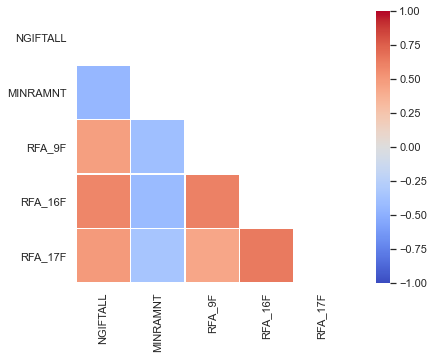

In [197]:
mask = np.zeros_like(data[vars_PCA_ClientValue].corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 5))
    ax = sns.heatmap(data[vars_PCA_ClientValue].corr(), vmin=-1, vmax=1, mask=mask, square=True, linewidths=.2, cmap="coolwarm")

In [175]:
vars_cluster_ClientValue = ['NGIFTALL', 'MINRAMNT', 'RFA_9F', 'RFA_16F', 'RFA_17F']

In [176]:
vars_cluster_ClientValue2 = ['RFA_2A_G', 'RFA_3A_G', 'RFA_4A_G', 'DOMAIN_Socio_2', 'DOMAIN_Socio_3', 'DOMAIN_Socio_4',
                             'RAMNTALL', 'MAXRAMNT', 'MINRAMNT']

#### Demographic Perspective

In [199]:
vars_PCA_Demographic = ['AGEC2', 'ETHC1', 'HHAGE2', 'AGE907', 'VC1']                    

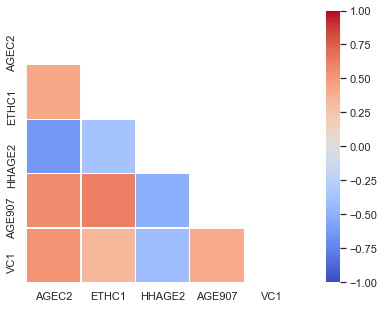

In [200]:
mask = np.zeros_like(data[vars_PCA_Demographic].corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 5))
    ax = sns.heatmap(data[vars_PCA_Demographic].corr(), vmin=-1, vmax=1, mask=mask, square=True, linewidths=.2, 
                     cmap="coolwarm")

In [177]:
vars_cluster_Demographic = ['AGEC2', 'ETHC1', 'HHAGE2', 'AGE907', 'VC1']

In [179]:
vars_cluster_Demographic2 = ['AGEC2', 'POBC1', 'ETHC1', 'ETHC2', 'HHAGE2', 
                                     'POBC2', 'AGE907',  'ANC_W', 'VC1', 'STATE_RNE', 'STATE_RS', 'STATE_RW',]

#### Social Perspective

In [201]:
vars_PCA_Social = ['VOC1', 'RHP2', 'HHD12', 'DW4', 'HHN1', 'MARR1']

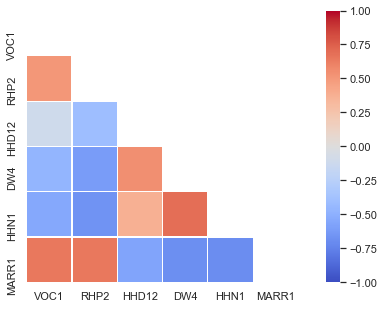

In [202]:
mask = np.zeros_like(data[vars_PCA_Social].corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 5))
    ax = sns.heatmap(data[vars_PCA_Social].corr(), vmin=-1, vmax=1, mask=mask, square=True, linewidths=.2, 
                     cmap="coolwarm")

In [180]:
vars_cluster_Social = ['VOC1', 'RHP2', 'HHD12', 'DW4', 'HHN1', 'MARR1']

In [181]:
vars_cluster_Social2 = ['DOMAIN_Socio_2', 'DOMAIN_Socio_3', 'DOMAIN_Socio_4', 'DOMAIN_Urban', 'FEMALE',
                        'EC1', 'RHP2', 'HHN1', 'MARR1']

#### Economical Perspective 

In [204]:
vars_PCA_Economical = ['IC5','IC10','IC12','MHUC1','OCC2','RP1','HVP2','HVP5', 'HVP6']

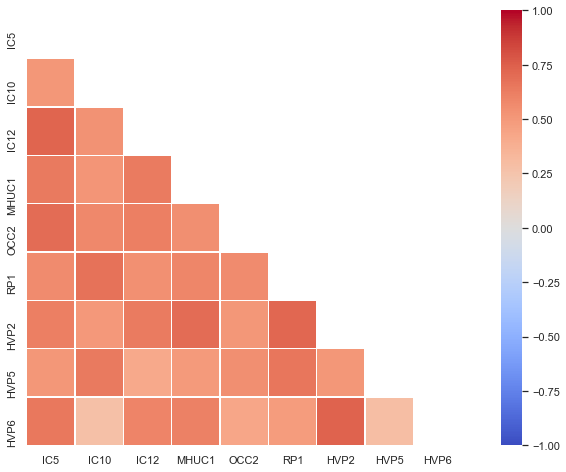

In [205]:
mask = np.zeros_like(data[vars_PCA_Economical].corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 8))
    ax = sns.heatmap(data[vars_PCA_Economical].corr(), vmin=-1, vmax=1, mask=mask, square=True, linewidths=.2, 
                     cmap="coolwarm")

In [182]:
vars_cluster_Economical = ['IC5','IC10','IC12','MHUC1','OCC2','RP1','HVP2','HVP5', 'HVP6']

In [183]:
vars_cluster_Economical2 = ['INCOME_5.0', 'INCOME_6.0', 'INCOME_7.0', 'IC5', 'IC6', 'IC10', 'IC12', 'RP1',
                                           'HVP2']

### 5.2. Principal Component Analysis

In [206]:
PCA_vars = vars_PCA_ClientValue + vars_PCA_Social + vars_PCA_Demographic + vars_PCA_Economical

In [207]:
pca = PCA()
pca_feat = pca.fit_transform(data[PCA_vars])  

In [208]:
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
).head(9)

,Eigenvalue,Difference,Proportion,Cumulative
1,6.494294,0.000000,0.259769,0.259769
2,4.895825,-1.598469,0.195831,0.455600
3,2.950043,-1.945782,0.118000,0.573600
4,2.242441,-0.707602,0.089697,0.663297
5,1.073225,-1.169216,0.042929,0.706225
6,0.828780,-0.244444,0.033151,0.739376
7,0.741789,-0.086991,0.029671,0.769048
8,0.693085,-0.048704,0.027723,0.796771
9,0.579444,-0.113641,0.023178,0.819948


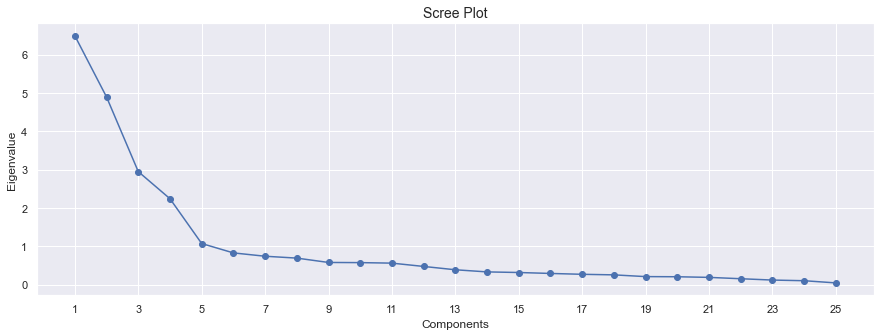

In [209]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

ax1.plot(pca.explained_variance_, marker=".", markersize=12)

ax1.set_title("Scree Plot", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax1.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [210]:
# Perform PCA with the number of principal components chosen before
pca = PCA(n_components=5)
pca_feat = pca.fit_transform(data[PCA_vars])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_data = pd.DataFrame(pca_feat, index=data[PCA_vars].index, columns=pca_feat_names)

In [211]:
df_pca = pd.concat([data[PCA_vars], pca_data], axis=1)

In [212]:
def _color_red_or_green(val):
    if val < -0.4:
        color = 'background-color: red'
    elif val > 0.4:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Compute the loadings between each variable and the principal components
loadings = df_pca[PCA_vars + pca_feat_names].corr().loc[PCA_vars, pca_feat_names]
loadings.style.applymap(_color_red_or_green)

,PC0,PC1,PC2,PC3,PC4
NGIFTALL,0.116336,-0.074709,-0.775040,0.056333,0.003746
MINRAMNT,-0.115006,0.109479,0.633159,-0.054340,0.031895
RFA_9F,0.076020,-0.093093,-0.742336,0.123214,0.010547
RFA_16F,0.081612,-0.087581,-0.850476,0.128086,0.019011
RFA_17F,0.066462,-0.080022,-0.751860,0.120819,0.042775
VOC1,-0.579942,-0.392970,-0.046009,-0.093810,-0.414436
RHP2,-0.676406,-0.446539,-0.055885,-0.320045,0.013579
HHD12,0.011195,0.573077,0.041487,0.566945,-0.186302
DW4,0.283469,0.703878,0.030749,0.413250,-0.100391
HHN1,0.548460,0.703687,-0.030130,0.019982,-0.085006


## 6. A-priori Grouping - Cohort Analysis

Create a new dataframe with RDATE and CONTROLN columns from data_cohort.

In [125]:
df_cohort = data_cohort.loc[:, 'RDATE_3':'RDATE_24']
df_cohort = pd.concat([data_cohort['CONTROLN'], df_cohort], axis = 1)

Use melt method to extract all dates when a specific donor donated a monetary gift (NaN means a donor did not make any donation).

In [126]:
df_cohort = pd.melt(df_cohort, id_vars = ('CONTROLN'), value_name = 'RDATE')
df_cohort.dropna(subset = ['RDATE'], inplace = True)

Assign to each customer the respectives donations' dates.

In [127]:
df_cohort['RDATE'] = pd.to_datetime(df_cohort['RDATE'])
df_cohort = df_cohort.sort_values(['CONTROLN', 'RDATE']).set_index(['CONTROLN'])

Assign to each customer the date of the first donation. Secondly, calculate for each donation date the month when that donation was made relatively to the first donation's date (e.g. if a donor firstly donated on 2014-09-01 and then in 2014-10-01, then 'TIMELAG' equals 1).

In [128]:
df_cohort['FIRSTDONATION'] = df_cohort.groupby('CONTROLN')['RDATE'].min()
df_cohort['FIRSTDONATION'] = pd.to_datetime(df_cohort['FIRSTDONATION'])

df_cohort.reset_index(inplace=True)

df_cohort['TIMELAG'] = (df_cohort['RDATE'].dt.year - df_cohort['FIRSTDONATION'].dt.year) * 12 + df_cohort['RDATE'].dt.month - df_cohort['FIRSTDONATION'].dt.month + 1

For each 'FIRSTDONATION' and 'TIMELAG' values, 'COUNT_DONORS' holds the number of donors who firstly donated in that date of 'FIRSTDONATION' and made another donation after that specific 'TIMELAG'.

In [129]:
cohort_data = df_cohort.groupby(['FIRSTDONATION', 'TIMELAG'])['CONTROLN'].apply(pd.Series.nunique).reset_index()
cohort_data['COUNT_DONORS'] = cohort_data['CONTROLN']

Eliminate rows from cohort_data whose FIRSTDONATION was made by few people, in order to not add noise to cohort analysis.

In [130]:
rows_to_drop = cohort_data[(cohort_data['FIRSTDONATION'] == '2013-09-01') | (cohort_data['FIRSTDONATION'] == '2013-10-01') 
                          | (cohort_data['FIRSTDONATION'] == '2014-03-01') | (cohort_data['FIRSTDONATION'] == '2014-04-01')
                          | (cohort_data['FIRSTDONATION'] == '2014-05-01') | (cohort_data['FIRSTDONATION'] == '2016-04-01')
                          | (cohort_data['FIRSTDONATION'] == '2016-09-01') | (cohort_data['FIRSTDONATION'] == '2016-11-01')
                          | (cohort_data['FIRSTDONATION'] == '2018-05-01')]

cohort_data.drop(rows_to_drop.index, inplace = True)

Build a pivot table with the number of donors for each 'FIRSTDONATION' date and each 'TIMELAG'.

In [131]:
cohort_count = cohort_data.pivot_table(index = 'FIRSTDONATION', columns = 'TIMELAG', values = 'COUNT_DONORS')
cohort_count.fillna(0, inplace = True)

Transform the retention pivot table into a retention rate pivot table, which enables to assess donors' retention through time in a more meaningful way.

In [132]:
num_donors = cohort_count.iloc[:,0]
retention_rate = cohort_count.divide(num_donors, axis = 0)
retention_rate.round(5) * 100

TIMELAG,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,49
FIRSTDONATION,,,,,,,,,,,,,,,,,,,,,
2014-06-01,100.0,8.744,13.323,30.495,9.645,14.539,33.658,23.755,10.303,12.035,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.014,0.000,0.014
2014-07-01,100.0,12.935,20.154,13.839,16.008,32.027,17.838,13.500,12.732,27.643,...,0.000,0.000,0.000,0.000,0.000,0.000,0.011,0.000,0.011,0.000
2014-08-01,100.0,14.419,12.469,18.264,29.278,14.941,12.442,13.787,25.076,22.411,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.027,0.027,0.000
2014-09-01,100.0,3.411,3.212,19.348,16.904,8.868,10.269,25.797,14.784,23.205,...,0.000,0.000,0.000,0.000,0.000,0.012,0.000,0.000,0.000,0.000
2014-10-01,100.0,4.846,13.703,11.084,9.643,9.872,24.771,15.210,20.252,14.014,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2014-11-01,100.0,15.545,9.306,8.011,10.755,22.056,13.073,16.192,12.119,11.386,...,0.000,0.034,0.000,0.017,0.000,0.000,0.000,0.000,0.000,0.000
2014-12-01,100.0,6.431,4.971,6.412,17.661,9.990,14.359,9.379,9.656,11.812,...,0.010,0.010,0.010,0.000,0.019,0.000,0.000,0.000,0.000,0.000
2015-01-01,100.0,3.877,2.903,9.551,5.790,20.422,12.273,10.409,16.975,13.675,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2015-02-01,100.0,3.044,8.819,5.206,16.728,12.432,10.896,14.111,12.888,19.403,...,0.000,0.000,0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Build a heatmap in order to more easily visualize the donors' retention rate through time.

In [133]:
Time_Lag = cohort_data['TIMELAG'].sort_values().unique()

In [134]:
First_Donation_Date = pd.to_datetime(cohort_data['FIRSTDONATION']).dt.date.sort_values().unique()

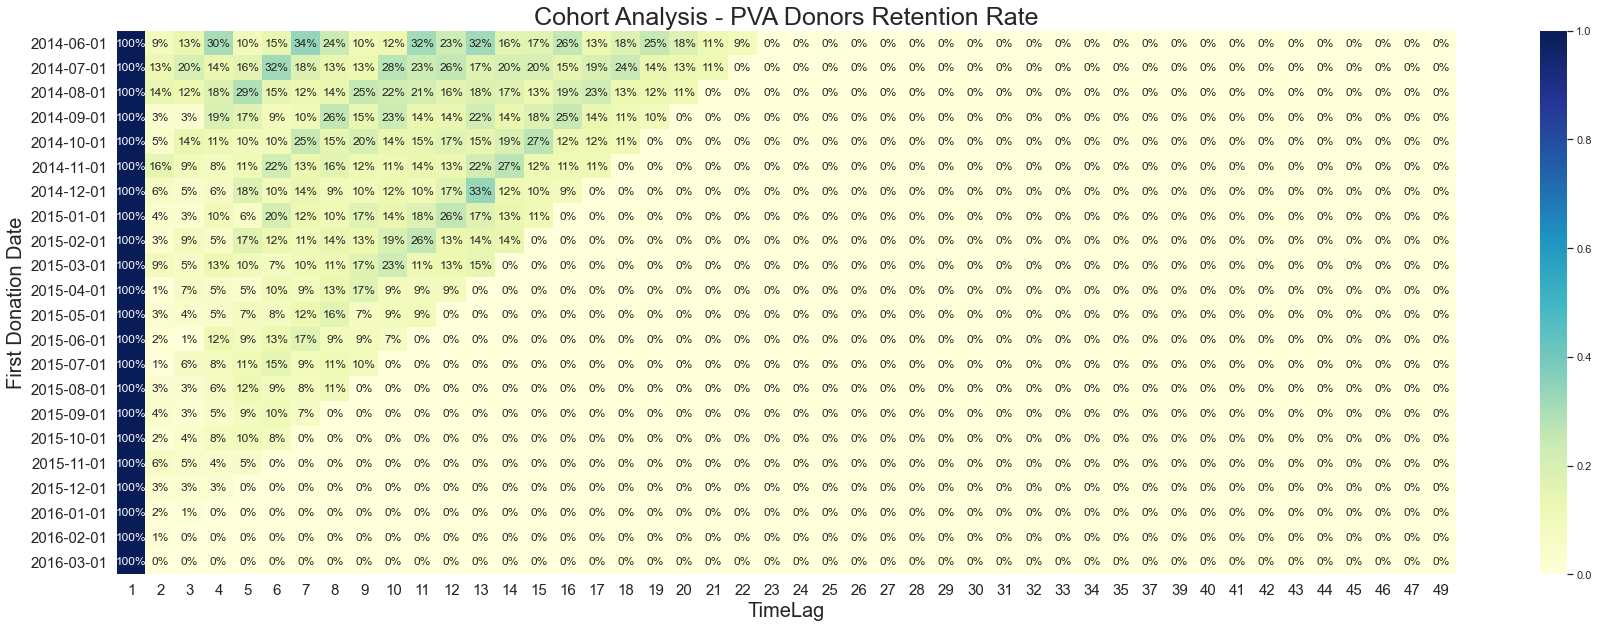

In [135]:
plt.figure(figsize = (30,10))

heatmap_cohort = sns.heatmap(data = retention_rate, 
                             annot = True, 
                             fmt = '.0%',
                             cmap = "YlGnBu")

plt.title('Cohort Analysis - PVA Donors Retention Rate', fontdict = {'fontsize': 25})
plt.ylabel('First Donation Date', fontdict = {'fontsize': 20})
plt.xlabel('TimeLag', fontdict = {'fontsize': 20})

heatmap_cohort.set_xticklabels(Time_Lag, fontdict = {'fontsize': 15})
heatmap_cohort.set_yticklabels(First_Donation_Date, fontdict = {'fontsize': 15})


plt.show()

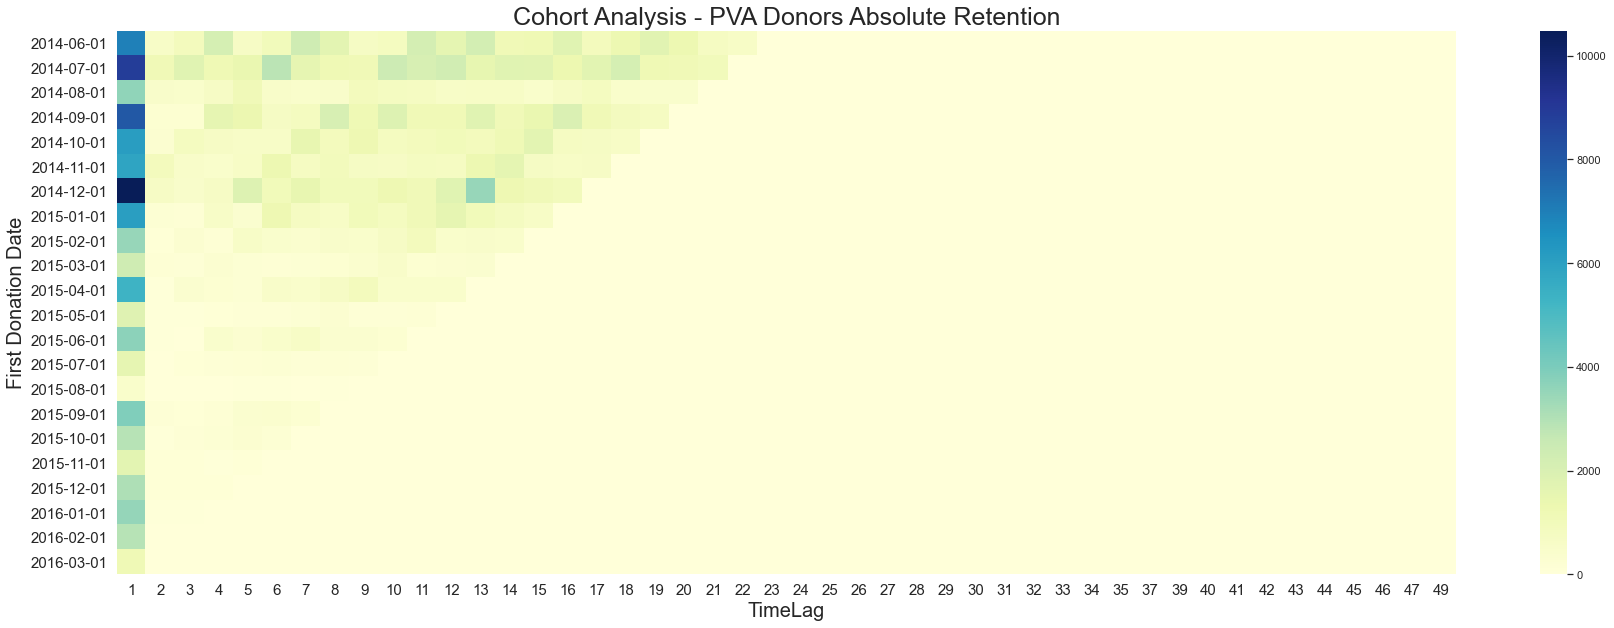

In [136]:
plt.figure(figsize = (30,10))

heatmap_cohort = sns.heatmap(data = cohort_count, 
                             annot = False, 
                             cmap = "YlGnBu")

plt.title('Cohort Analysis - PVA Donors Absolute Retention', fontdict = {'fontsize': 25})
plt.ylabel('First Donation Date', fontdict = {'fontsize': 20})
plt.xlabel('TimeLag', fontdict = {'fontsize': 20})

heatmap_cohort.set_xticklabels(Time_Lag, fontdict = {'fontsize': 15})
heatmap_cohort.set_yticklabels(First_Donation_Date, fontdict = {'fontsize': 15})


plt.show()

## 7. Clustering 

### 7.1. K-means

In [159]:
range_clusters = range(1, 11)

In [176]:
inertia = []
for n_clus in range_clusters:
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(pca_data)
    inertia.append(kmclust.inertia_)

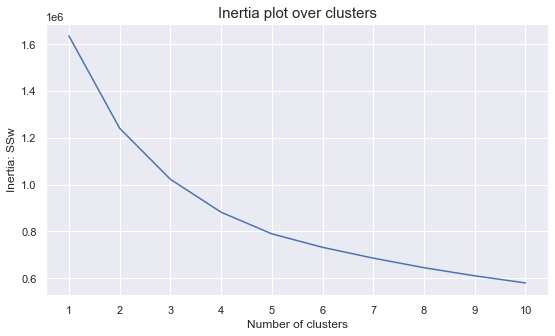

In [181]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.xticks(np.arange(len(range_clusters)), np.arange(1, len(range_clusters)+1))
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.26620999744694446
For n_clusters = 3, the average silhouette_score is : 0.2654402601023818
For n_clusters = 4, the average silhouette_score is : 0.21676919531924468
For n_clusters = 5, the average silhouette_score is : 0.19942165336154366
For n_clusters = 6, the average silhouette_score is : 0.20230575518325214
For n_clusters = 7, the average silhouette_score is : 0.20447163035434873
For n_clusters = 8, the average silhouette_score is : 0.18450067470598727
For n_clusters = 9, the average silhouette_score is : 0.1884990019424067
For n_clusters = 10, the average silhouette_score is : 0.18411856825573653


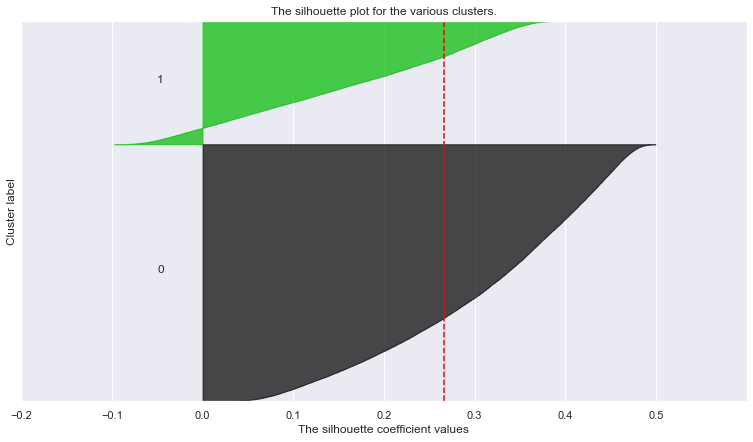

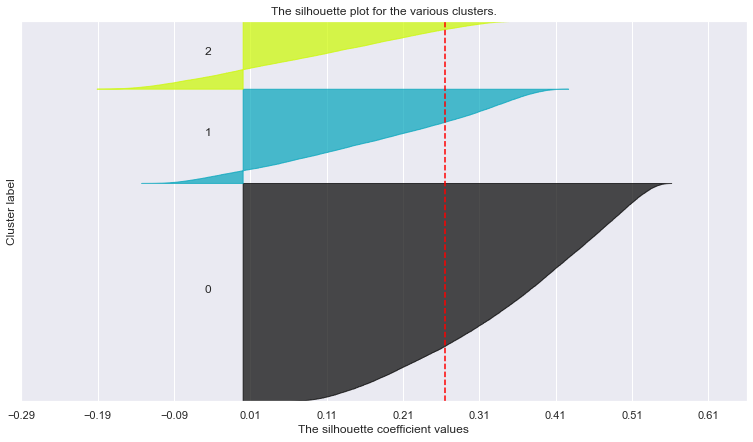

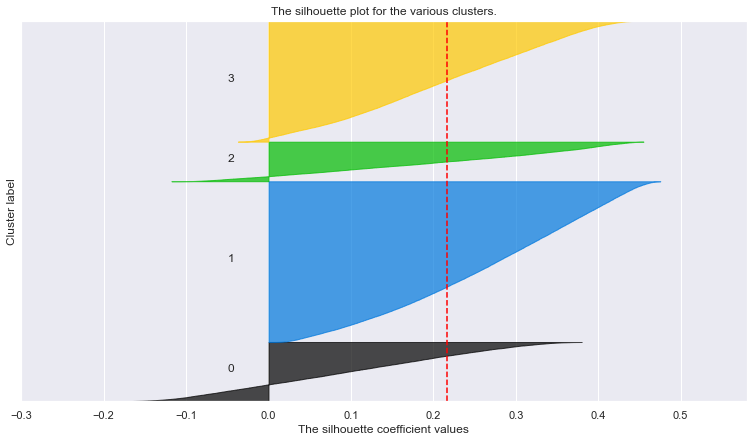

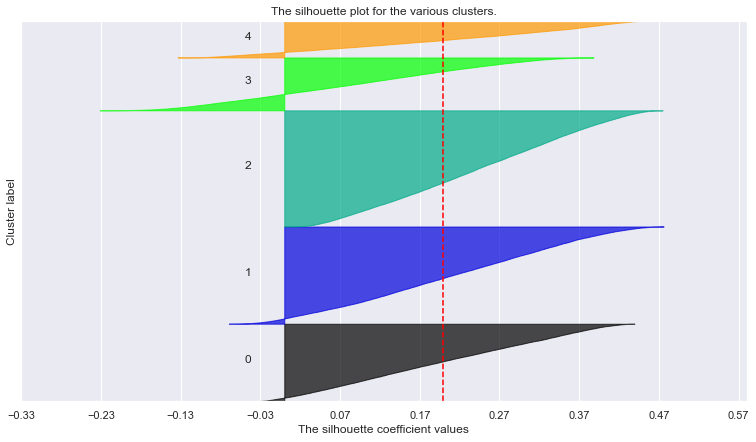

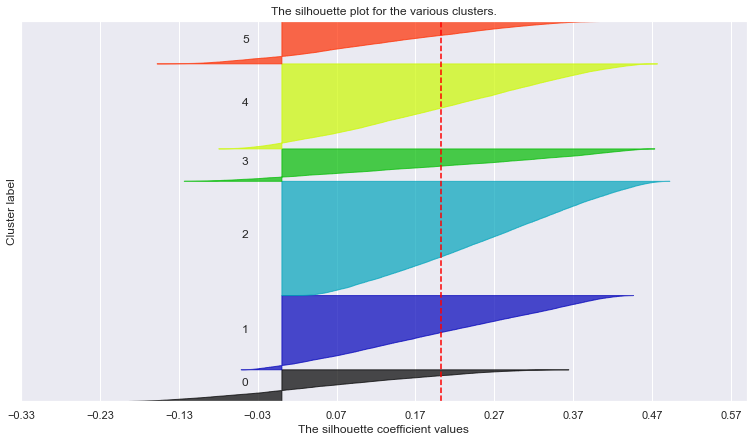

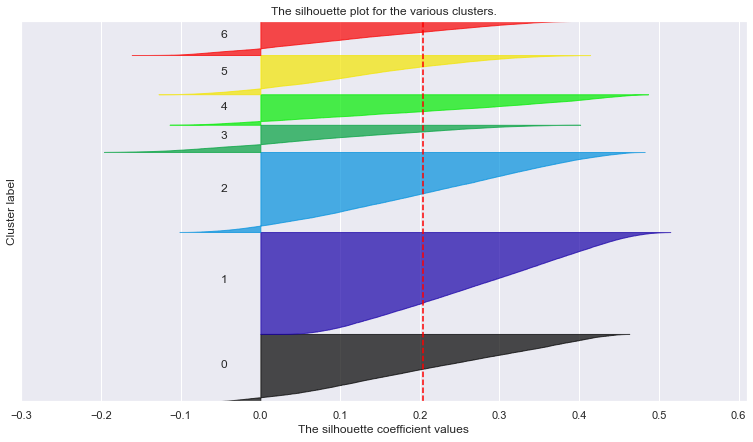

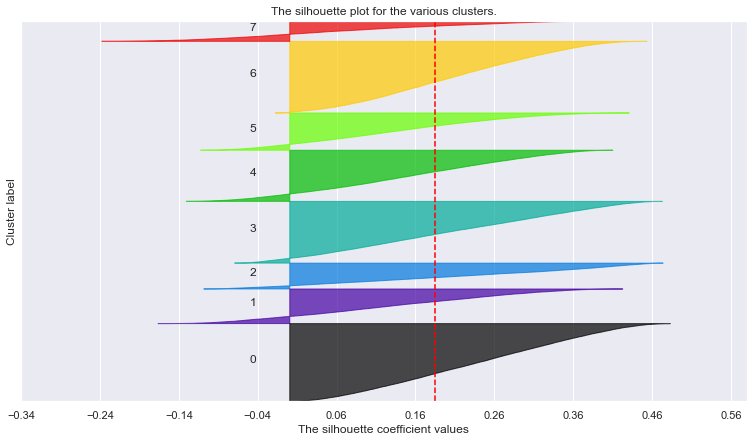

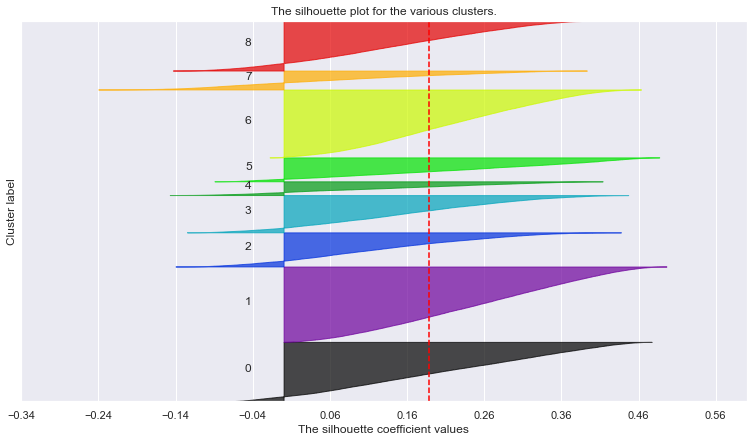

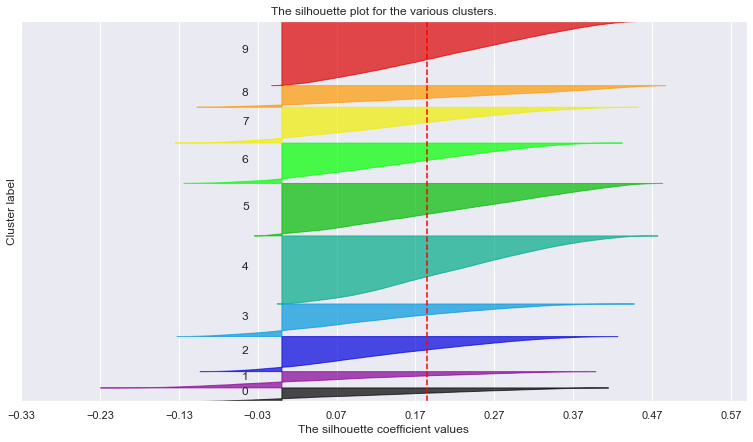

In [184]:
avg_silhouette = []
for nclus in range_clusters:
    if nclus == 1:
        continue
     
    fig = plt.figure(figsize=(13, 7))

    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(pca_data)

    silhouette_avg = silhouette_score(pca_data, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(pca_data, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
       
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    plt.ylim([0, len(pca_data) + (nclus + 1) * 10])

    plt.yticks([])  
    plt.xticks(np.arange(xmin, xmax, 0.1))

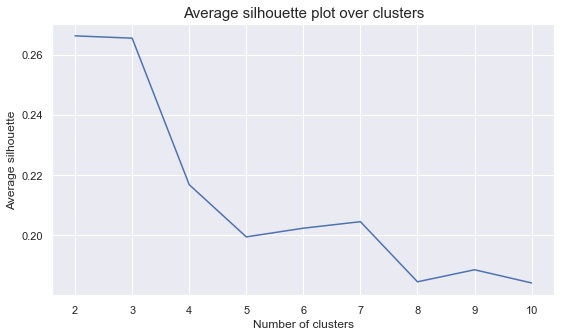

In [185]:
# The average silhouette plot
fig = plt.figure(figsize=(9,5))
plt.plot(avg_silhouette)
clus_labels = np.arange(2,11)
plt.xticks(np.arange(len(clus_labels)), np.arange(2, len(clus_labels)+2))
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [97]:
# final cluster solution
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(pca_data)
km_labels

array([0, 1, 0, ..., 1, 0, 1])

In [98]:
# Characterizing the final clusters
df_concat = pd.concat((pca_data, pd.Series(km_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

,PC0,PC1,PC2,PC3,PC4
labels,,,,,
0.0,0.014386,-0.012747,0.000213,-0.002087,-0.000108
1.0,-0.012491,0.026501,-0.008277,0.010739,0.002412
2.0,-0.031876,-0.008223,0.017208,-0.001759,0.000243


In [99]:
df_concat['labels'].value_counts()

0.0    53128
1.0    22928
2.0    16517
Name: labels, dtype: int64

In [151]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  

In [100]:
# using R^2
sst = get_ss(df_concat.drop(columns=['labels']))  
ssw_labels = df_concat[df_concat.drop(columns=['labels']).columns.to_list() + ["labels"]].groupby(by='labels').apply(get_ss)
ssb = sst - np.sum(ssw_labels)  
r2 = ssb / sst
r2

0.028996731669762008

#### Client Value Perspective:

In [200]:
inertia = []
for n_clus in range_clusters:
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(data[vars_PCA_ClientValue])
    inertia.append(kmclust.inertia_)

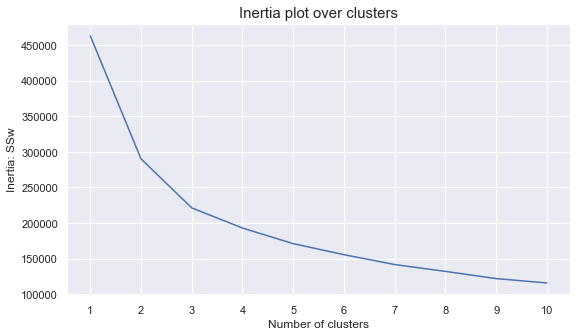

In [204]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.xticks(np.arange(len(range_clusters)), np.arange(1, len(range_clusters)+1))
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.34487377077365483
For n_clusters = 3, the average silhouette_score is : 0.3269921625498615
For n_clusters = 4, the average silhouette_score is : 0.2925198530080362
For n_clusters = 5, the average silhouette_score is : 0.27241768862848886
For n_clusters = 6, the average silhouette_score is : 0.26567884810475534
For n_clusters = 7, the average silhouette_score is : 0.2715327580798039
For n_clusters = 8, the average silhouette_score is : 0.2521067568953041
For n_clusters = 9, the average silhouette_score is : 0.2606303608164726
For n_clusters = 10, the average silhouette_score is : 0.25060366351019164


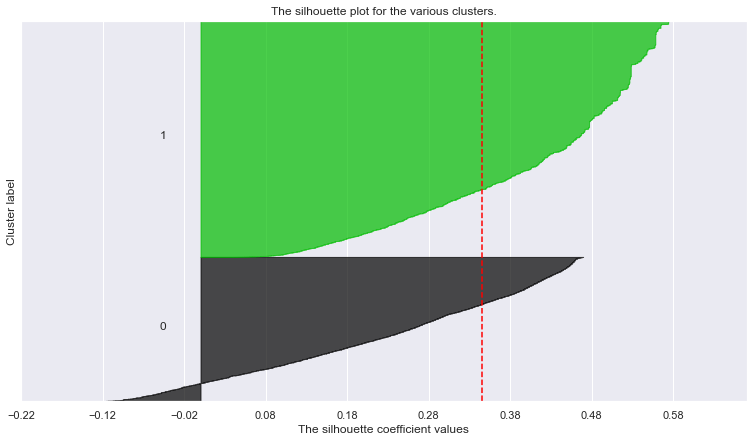

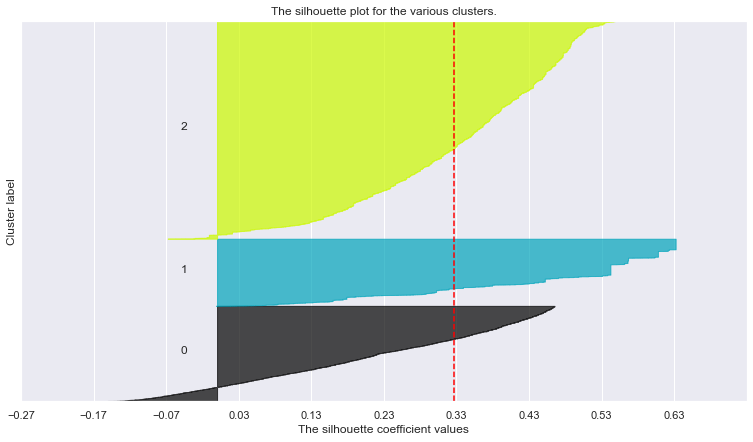

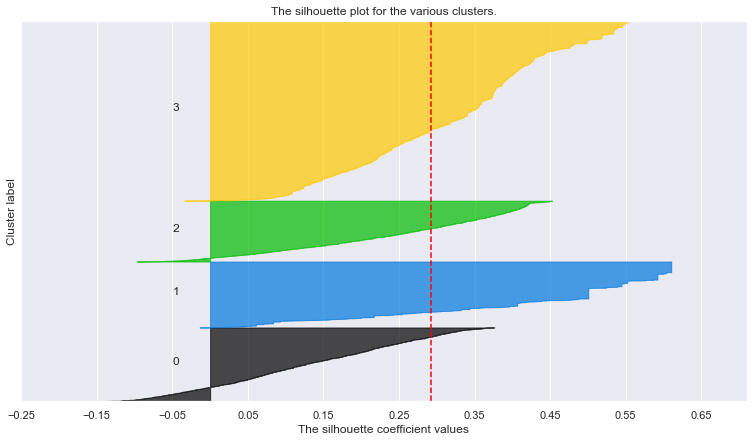

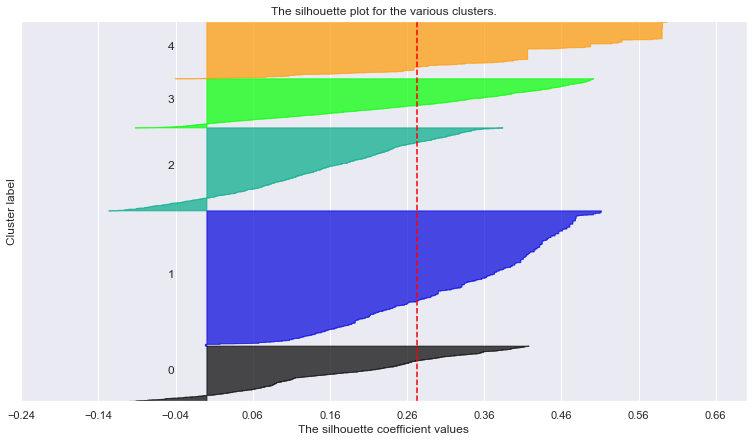

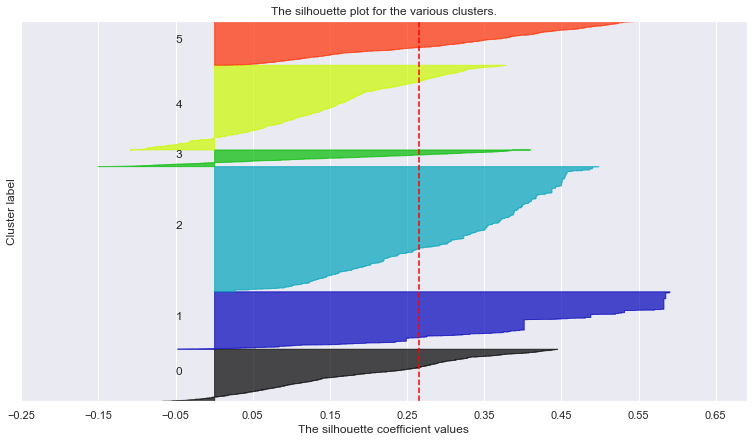

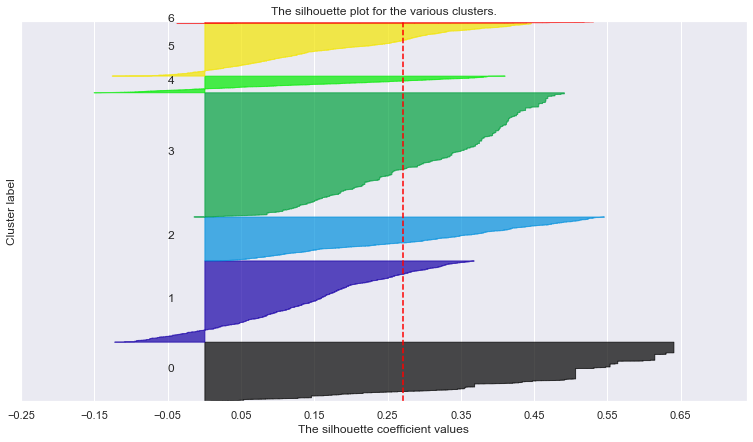

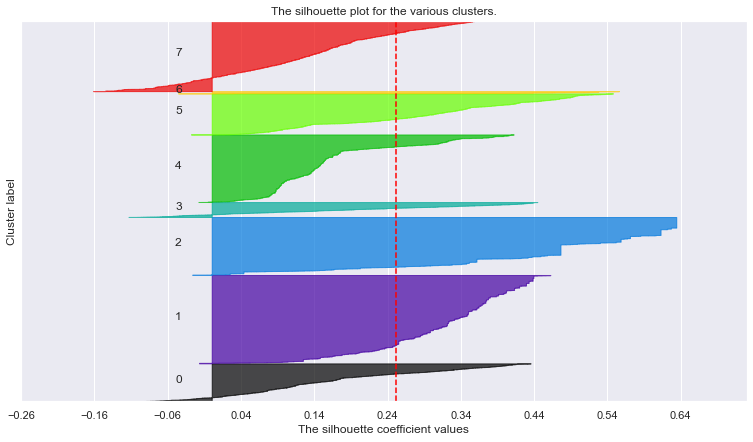

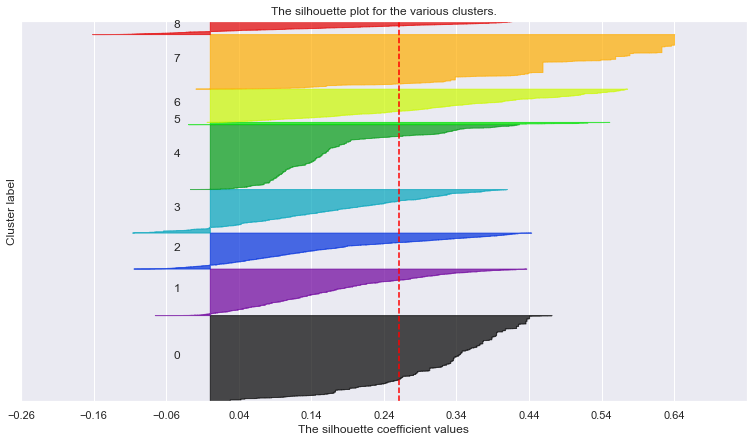

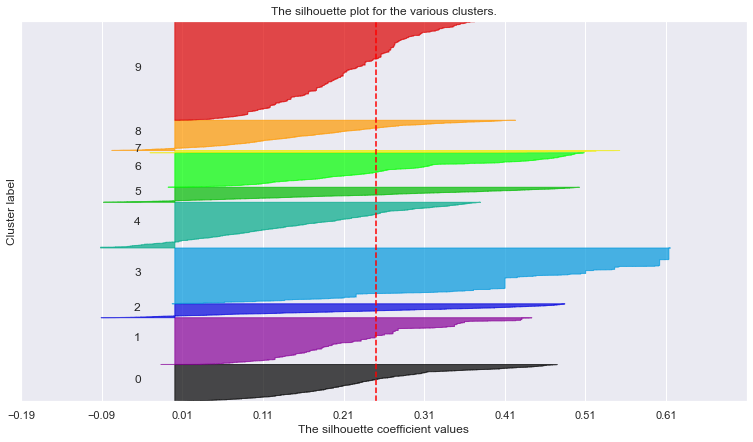

In [205]:
avg_silhouette = []
for nclus in range_clusters:
    if nclus == 1:
        continue

    fig = plt.figure(figsize=(13, 7))

    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(data[vars_PCA_ClientValue])

    silhouette_avg = silhouette_score(data[vars_PCA_ClientValue], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(data[vars_PCA_ClientValue], cluster_labels)

    y_lower = 10
    for i in range(nclus):

        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  
    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])

    plt.ylim([0, len(data[vars_PCA_ClientValue]) + (nclus + 1) * 10])

    plt.yticks([])
    plt.xticks(np.arange(xmin, xmax, 0.1))

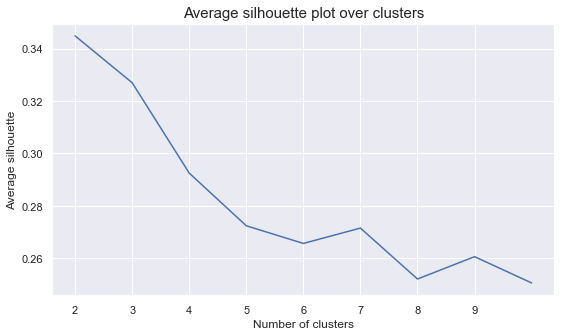

In [206]:
# The average silhouette plot
fig = plt.figure(figsize=(9,5))
plt.plot(avg_silhouette)
clus_labels = np.arange(2,10)
plt.xticks(np.arange(len(clus_labels)), np.arange(2, len(clus_labels)+2))
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [101]:
# final cluster solution
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels_2 = kmclust.fit_predict(data[vars_PCA_ClientValue])
km_labels_2

array([0, 2, 0, ..., 1, 2, 0])

In [102]:
# Characterizing the final clusters
df_concat_2 = pd.concat((data[vars_PCA_ClientValue], pd.Series(km_labels_2, name='labels')), axis=1)
df_concat_2.groupby('labels').mean()

,NGIFTALL,MINRAMNT,RFA_9F,RFA_16F,RFA_17F
labels,,,,,
0.0,0.011654,-0.005361,0.010497,0.015276,0.009921
1.0,-0.002412,0.006777,-0.008039,-0.014176,-0.013837
2.0,-0.005017,0.001197,-0.002651,-0.003121,-0.000175


In [103]:
df_concat_2['labels'].value_counts()

2.0    53021
0.0    23220
1.0    16332
Name: labels, dtype: int64

In [104]:
sst = get_ss(df_concat_2.drop(columns=['labels']))  
ssw_labels = df_concat_2[df_concat_2.drop(columns=['labels']).columns.to_list() + ["labels"]].groupby(by='labels').apply(get_ss)
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2

0.027816919174209597

#### Demographic Perspective:

In [223]:
inertia = []
for n_clus in range_clusters:
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(data[vars_PCA_Demographic])
    inertia.append(kmclust.inertia_)

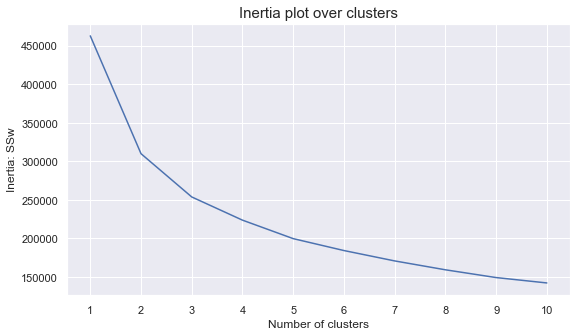

In [224]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.xticks(np.arange(len(range_clusters)), np.arange(1, len(range_clusters)+1))
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.2860635750587861
For n_clusters = 3, the average silhouette_score is : 0.248623308178171
For n_clusters = 4, the average silhouette_score is : 0.23455210137546903
For n_clusters = 5, the average silhouette_score is : 0.2066499356601858
For n_clusters = 6, the average silhouette_score is : 0.21997871917975345
For n_clusters = 7, the average silhouette_score is : 0.19832409526668593
For n_clusters = 8, the average silhouette_score is : 0.1959261452070325
For n_clusters = 9, the average silhouette_score is : 0.19559409273773076
For n_clusters = 10, the average silhouette_score is : 0.17963120763299054


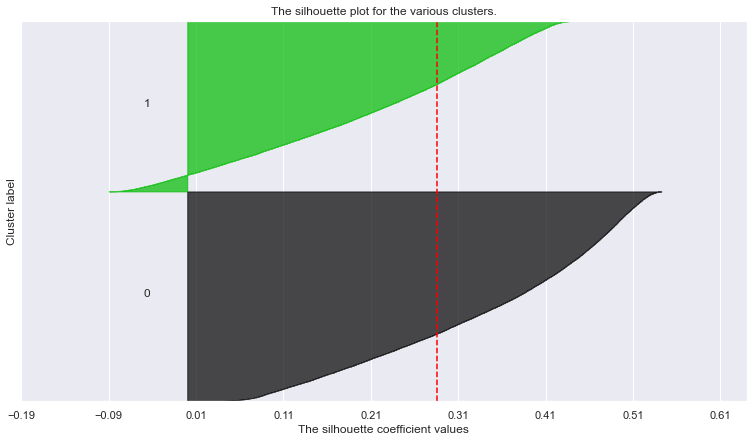

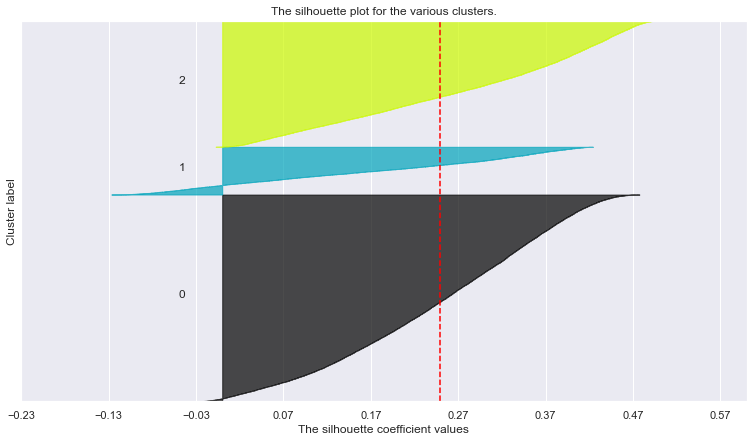

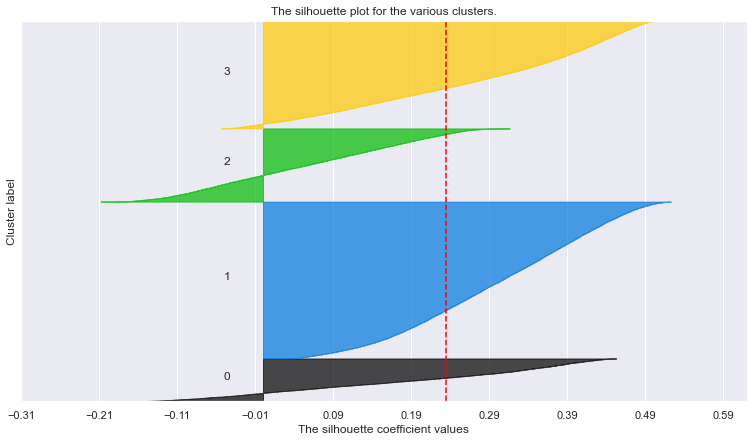

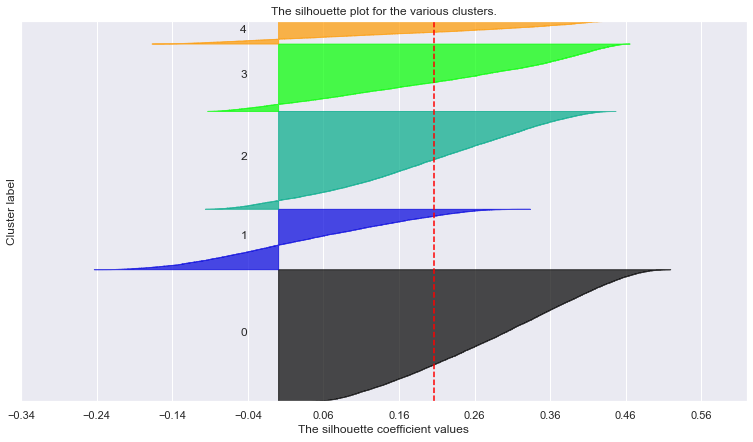

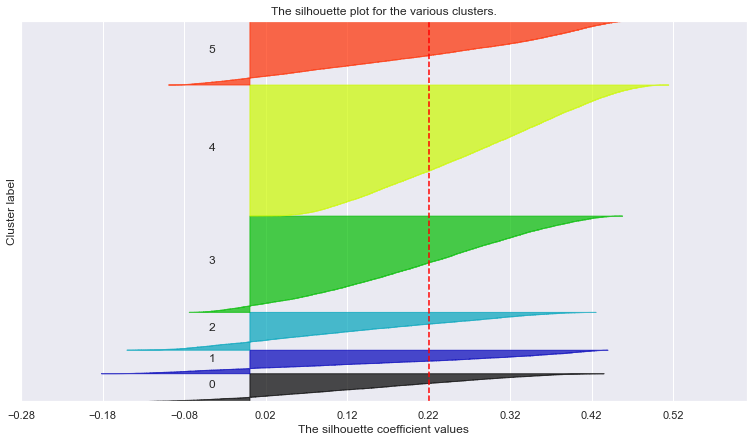

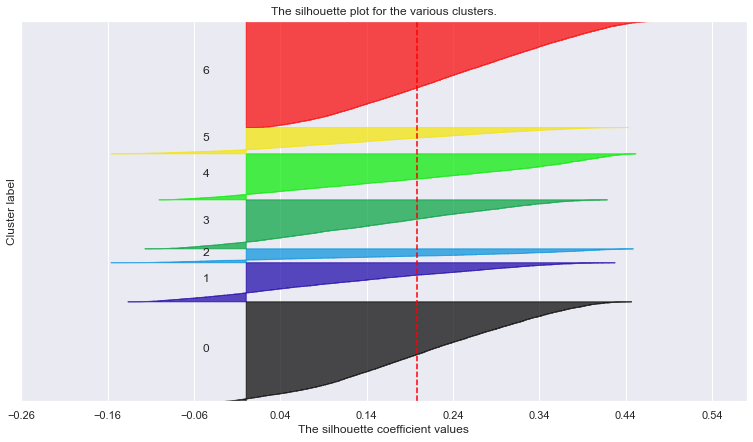

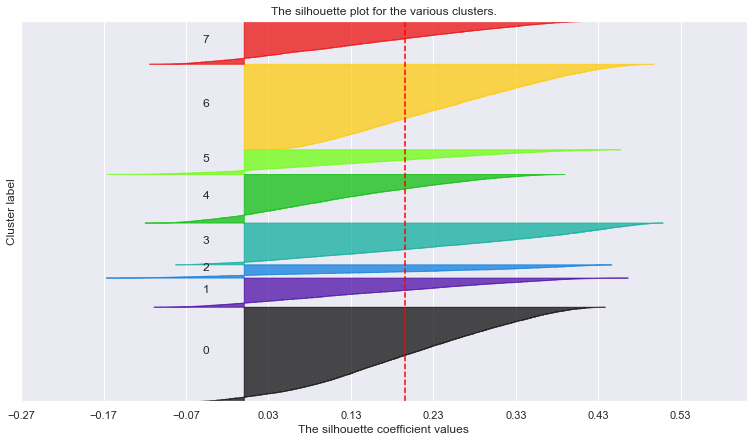

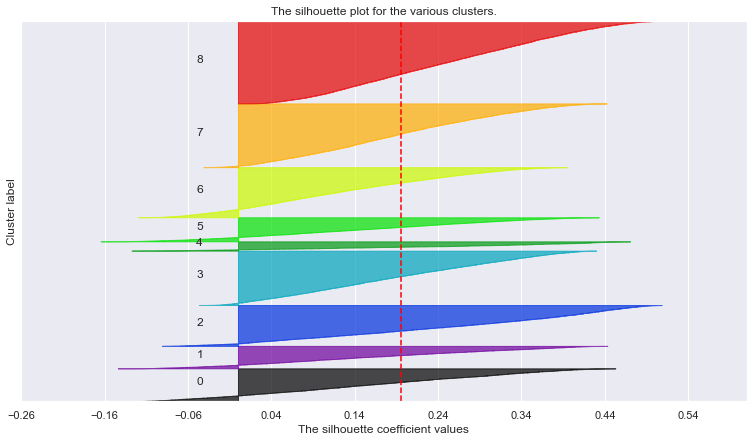

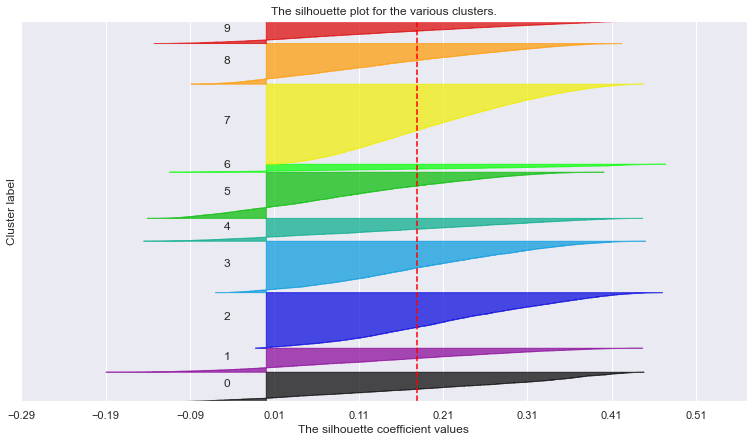

In [225]:
avg_silhouette = []
for nclus in range_clusters:

    if nclus == 1:
        continue

    fig = plt.figure(figsize=(13, 7))

    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(data[vars_PCA_Demographic])

    silhouette_avg = silhouette_score(data[vars_PCA_Demographic], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(data[vars_PCA_Demographic], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])

    plt.ylim([0, len(data[vars_PCA_Demographic]) + (nclus + 1) * 10])

    plt.yticks([]) 
    plt.xticks(np.arange(xmin, xmax, 0.1))

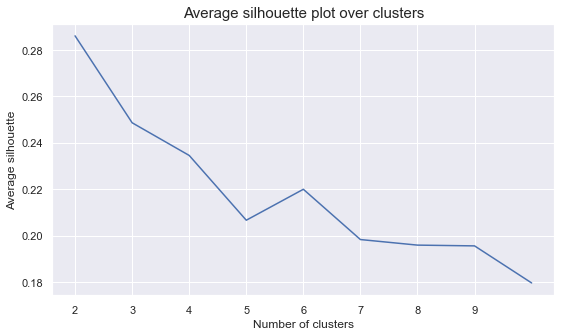

In [227]:
# The average silhouette plot
fig = plt.figure(figsize=(9,5))
plt.plot(avg_silhouette)
clus_labels = np.arange(2,10)
plt.xticks(np.arange(len(clus_labels)), np.arange(2, len(clus_labels)+2))
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [105]:
# final cluster solution
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels_3 = kmclust.fit_predict(data[vars_PCA_Demographic])
km_labels_3

array([0, 2, 0, ..., 2, 2, 0])

In [106]:
# Characterizing the final clusters
df_concat_3 = pd.concat((data[vars_PCA_Demographic], pd.Series(km_labels_3, name='labels')), axis=1)
df_concat_3.groupby('labels').mean()

,AGEC2,ETHC1,HHAGE2,AGE907,VC1
labels,,,,,
0.0,0.000622,-0.005454,-0.001431,0.000691,0.004519
1.0,0.004839,0.014187,0.000955,0.006065,-0.003959
2.0,-0.000491,0.005391,-0.001154,0.001948,-0.002643


In [107]:
df_concat_3['labels'].value_counts()

0.0    50307
2.0    30650
1.0    11616
Name: labels, dtype: int64

In [108]:
sst = get_ss(df_concat_3.drop(columns=['labels'])) 
ssw_labels = df_concat_3[df_concat_3.drop(columns=['labels']).columns.to_list() + ["labels"]].groupby(by='labels').apply(get_ss)
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2

0.029151609615584995

#### Social Perspective:

In [238]:
inertia = []
for n_clus in range_clusters:
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(data[vars_PCA_Social])
    inertia.append(kmclust.inertia_)

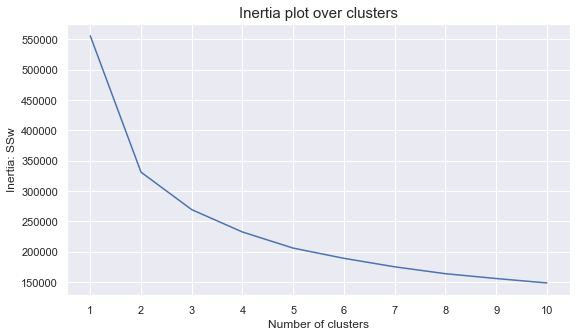

In [239]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.xticks(np.arange(len(range_clusters)), np.arange(1, len(range_clusters)+1))
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.45024663011015476
For n_clusters = 3, the average silhouette_score is : 0.2578296908313858
For n_clusters = 4, the average silhouette_score is : 0.25697335044889946
For n_clusters = 5, the average silhouette_score is : 0.22947226618725539
For n_clusters = 6, the average silhouette_score is : 0.22251496728253242
For n_clusters = 7, the average silhouette_score is : 0.22840503166299683
For n_clusters = 8, the average silhouette_score is : 0.2031740307469525
For n_clusters = 9, the average silhouette_score is : 0.20420451991584482
For n_clusters = 10, the average silhouette_score is : 0.18092914712443456


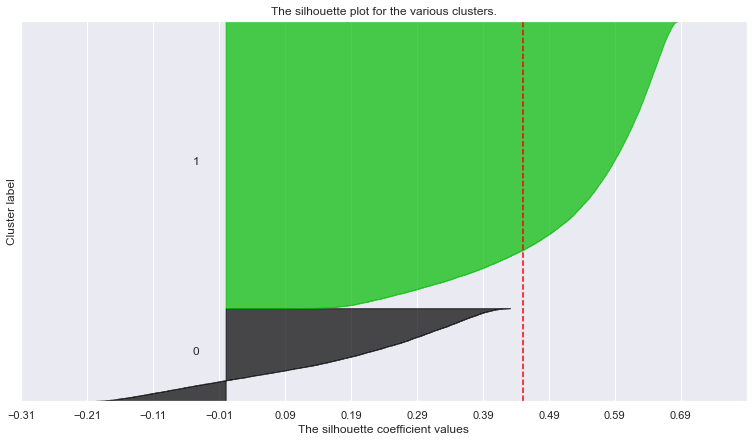

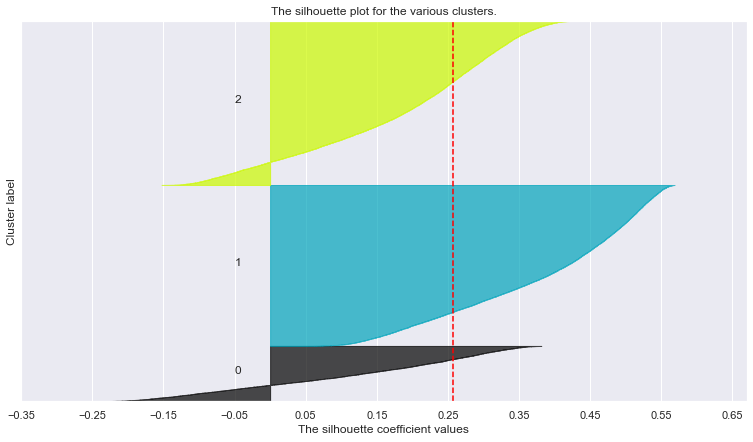

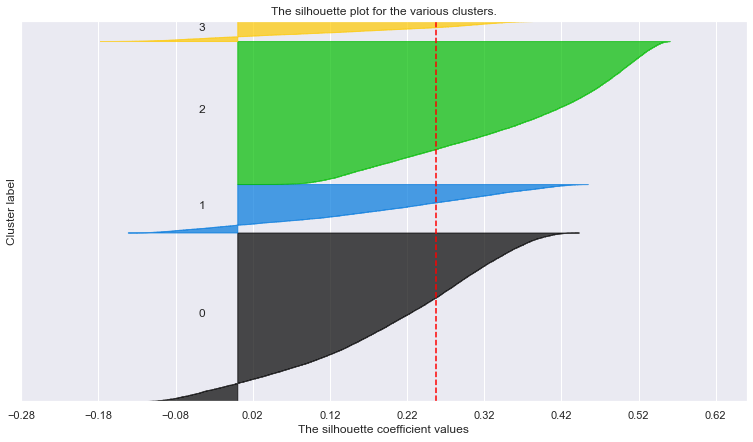

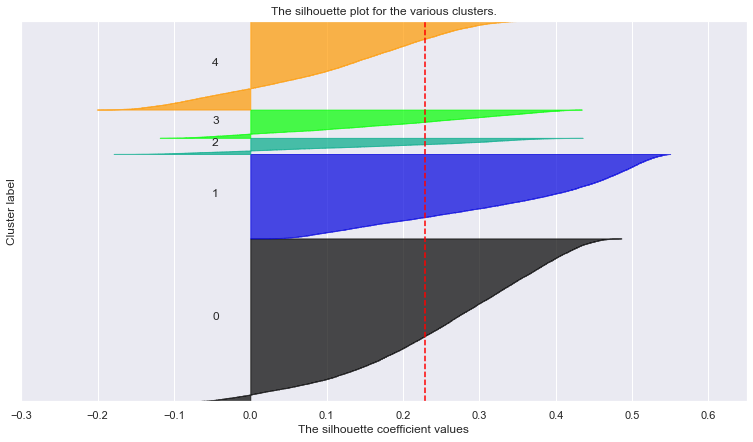

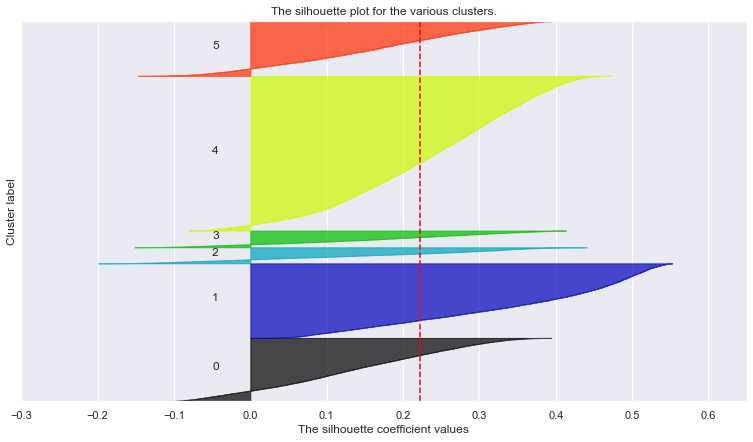

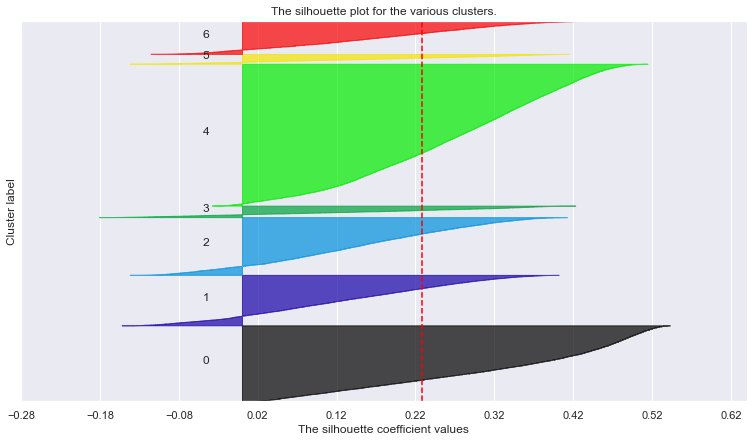

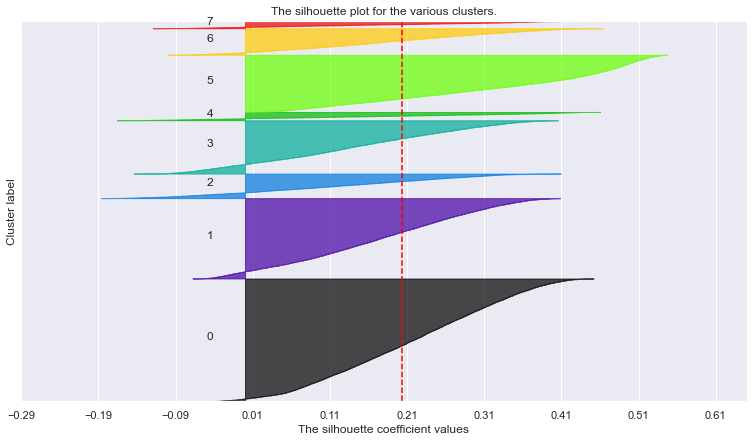

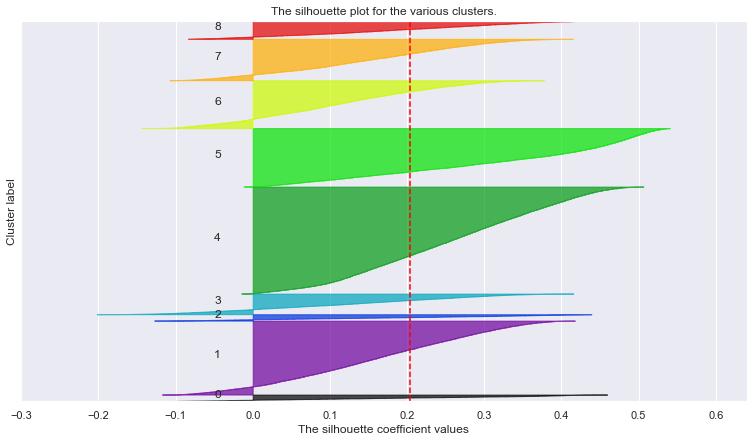

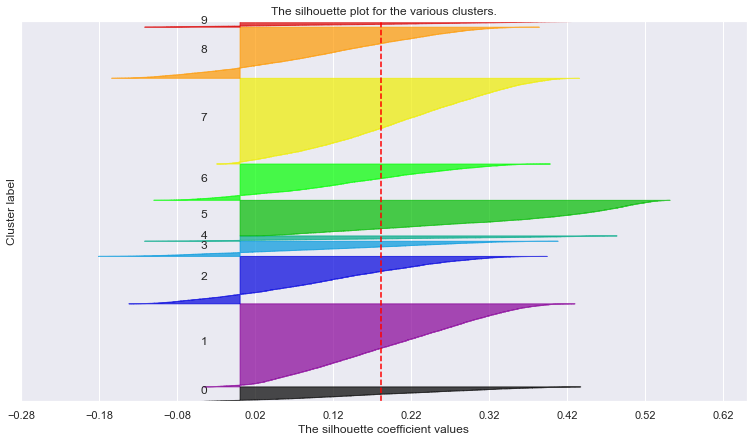

In [240]:
avg_silhouette = []
for nclus in range_clusters:

    if nclus == 1:
        continue
    
    fig = plt.figure(figsize=(13, 7))

    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(data[vars_PCA_Social])

    silhouette_avg = silhouette_score(data[vars_PCA_Social], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(data[vars_PCA_Social], cluster_labels)

    y_lower = 10
    for i in range(nclus):

        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])

    plt.ylim([0, len(data[vars_PCA_Social]) + (nclus + 1) * 10])

    plt.yticks([]) 
    plt.xticks(np.arange(xmin, xmax, 0.1))

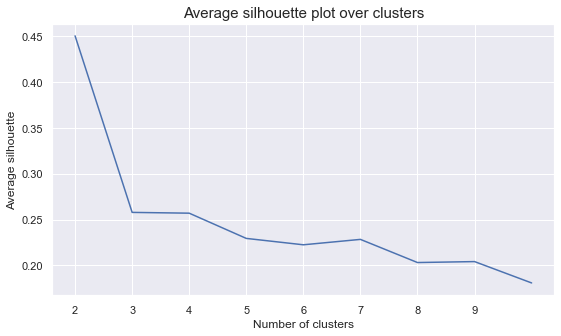

In [242]:
# The average silhouette plot
fig = plt.figure(figsize=(9,5))
plt.plot(avg_silhouette)
clus_labels = np.arange(2,10)
plt.xticks(np.arange(len(clus_labels)), np.arange(2, len(clus_labels)+2))
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [109]:
# final cluster solution
number_clusters = 2
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels_4 = kmclust.fit_predict(data[vars_PCA_Social])
km_labels_4

array([1, 1, 1, ..., 1, 1, 1])

In [110]:
# Characterizing the final clusters
df_concat_4 = pd.concat((data[vars_PCA_Social], pd.Series(km_labels_4, name='labels')), axis=1)
df_concat_4.groupby('labels').mean()

,VOC1,RHP2,HHD12,DW4,HHN1,MARR1
labels,,,,,,
0.0,-0.004577,0.001467,-0.007679,-0.004103,-0.007338,0.006736
1.0,0.001671,-0.000140,0.001435,0.001516,0.001219,-0.001729


In [111]:
df_concat_4['labels'].value_counts()

1.0    69922
0.0    22651
Name: labels, dtype: int64

In [112]:
sst = get_ss(df_concat_4.drop(columns=['labels'])) 
ssw_labels = df_concat_4[df_concat_4.drop(columns=['labels']).columns.to_list() + ["labels"]].groupby(by='labels').apply(get_ss)
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
r2

0.029424297429858744

#### Economical Perspective:

In [262]:
inertia = []
for n_clus in range_clusters:
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(data[vars_PCA_Economical])
    inertia.append(kmclust.inertia_)

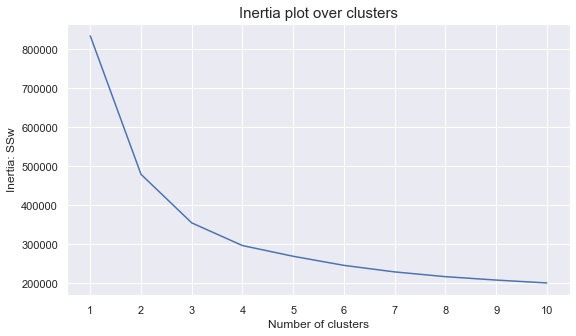

In [263]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.xticks(np.arange(len(range_clusters)), np.arange(1, len(range_clusters)+1))
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.4489615787527447
For n_clusters = 3, the average silhouette_score is : 0.34469361658618214
For n_clusters = 4, the average silhouette_score is : 0.2847742109139073
For n_clusters = 5, the average silhouette_score is : 0.2478977388507027
For n_clusters = 6, the average silhouette_score is : 0.2541023040758327
For n_clusters = 7, the average silhouette_score is : 0.2546477722724429
For n_clusters = 8, the average silhouette_score is : 0.206716583254374
For n_clusters = 9, the average silhouette_score is : 0.20928679398791736
For n_clusters = 10, the average silhouette_score is : 0.17421835433145982


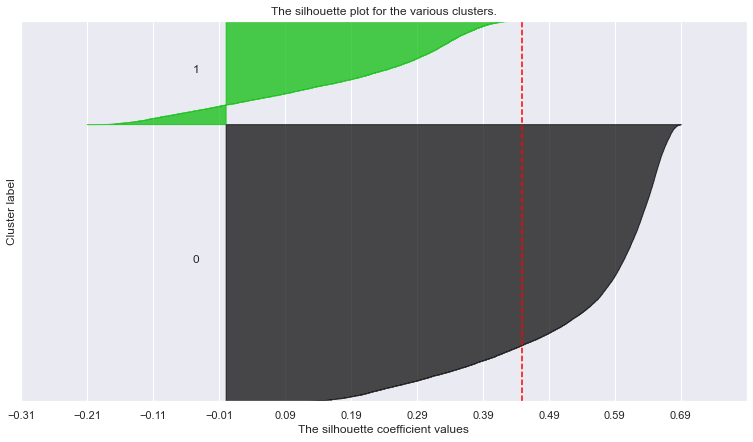

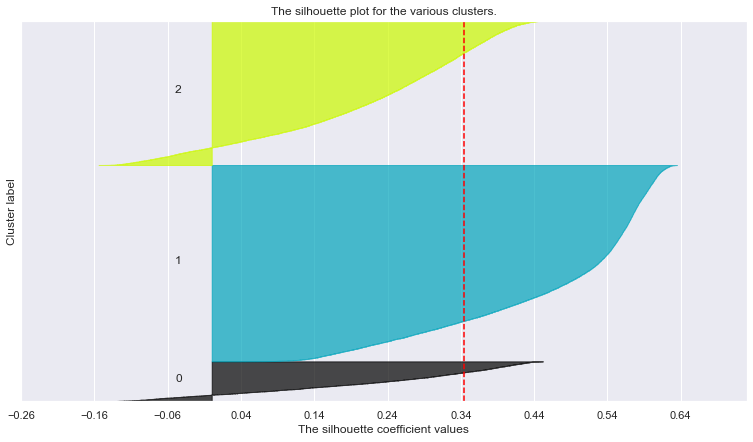

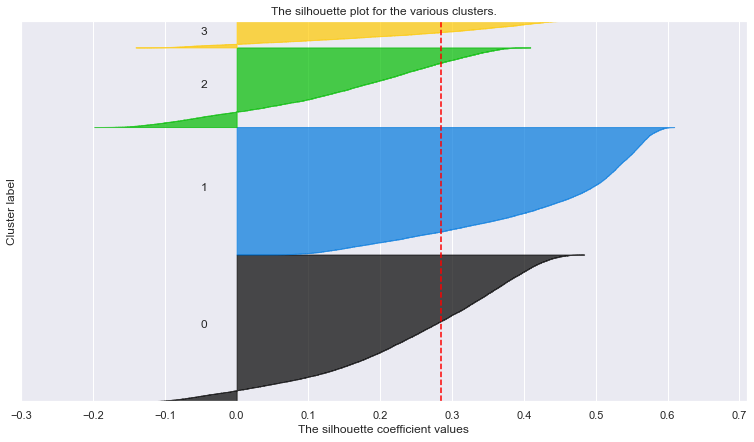

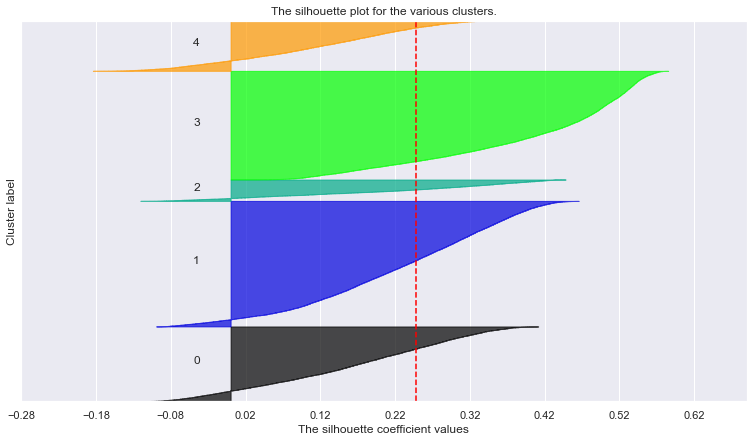

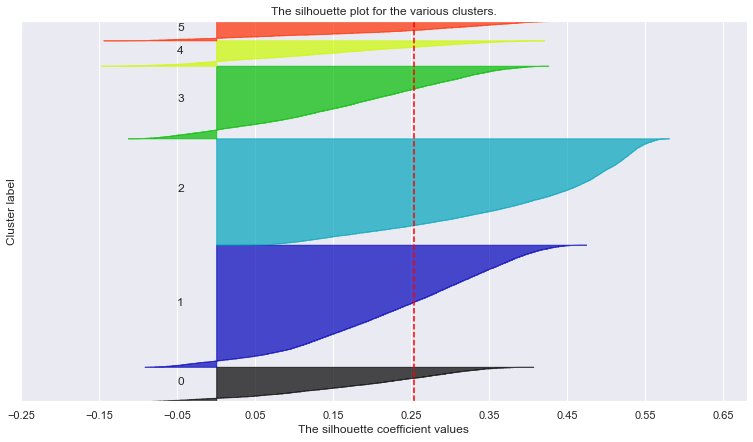

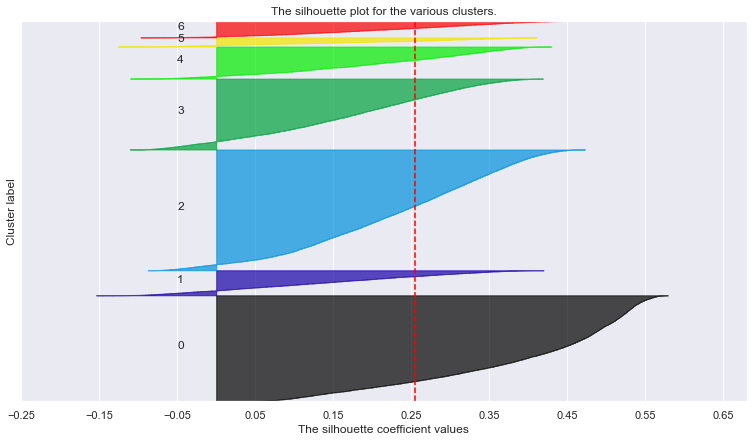

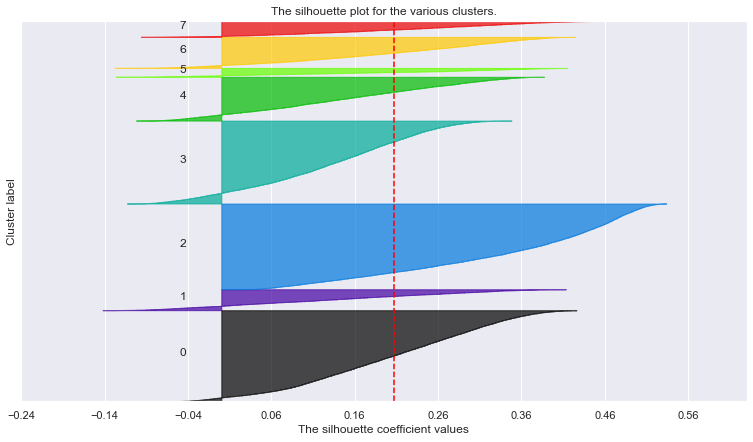

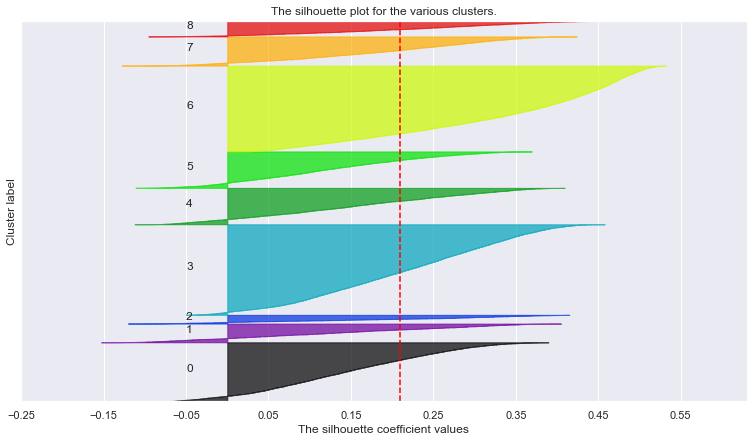

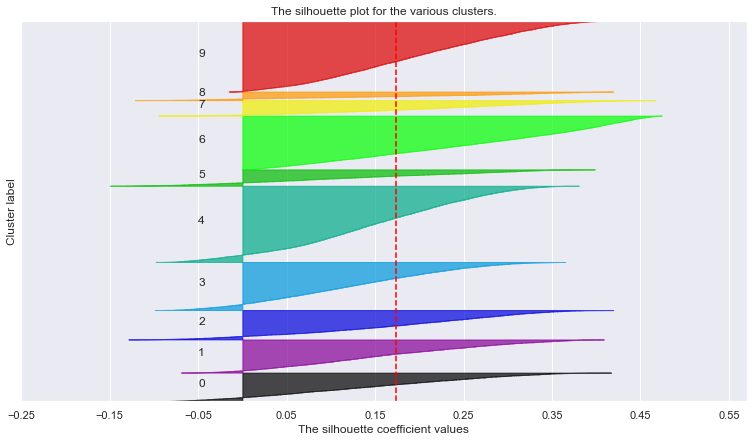

In [264]:
avg_silhouette = []
for nclus in range_clusters:

    if nclus == 1:
        continue

    fig = plt.figure(figsize=(13, 7))

    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(data[vars_PCA_Economical])

    silhouette_avg = silhouette_score(data[vars_PCA_Economical], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(data[vars_PCA_Economical], cluster_labels)

    y_lower = 10
    for i in range(nclus):

        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])

    plt.ylim([0, len(data[vars_PCA_Economical]) + (nclus + 1) * 10])

    plt.yticks([]) 
    plt.xticks(np.arange(xmin, xmax, 0.1))

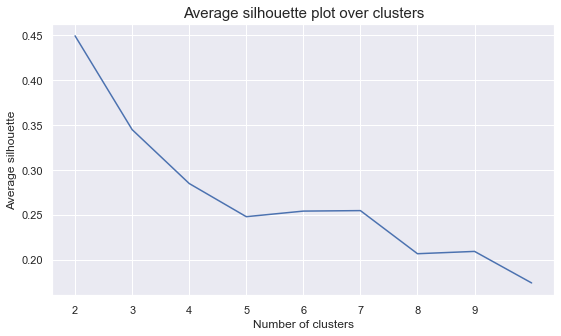

In [266]:
# The average silhouette plot
fig = plt.figure(figsize=(9,5))
plt.plot(avg_silhouette)
clus_labels = np.arange(2,10)
plt.xticks(np.arange(len(clus_labels)), np.arange(2, len(clus_labels)+2))
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [113]:
# final cluster solution
number_clusters = 2
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels_5 = kmclust.fit_predict(data[vars_PCA_Economical])
km_labels_5

array([0, 1, 0, ..., 1, 0, 1])

In [114]:
# Characterizing the final clusters
df_concat_5 = pd.concat((data[vars_PCA_Economical], pd.Series(km_labels_5, name='labels')), axis=1)
df_concat_5.groupby('labels').mean()

,IC5,IC10,IC12,MHUC1,OCC2,RP1,HVP2,HVP5,HVP6
labels,,,,,,,,,
0.0,-0.003440,-0.000359,0.000670,-0.000737,-0.002271,-0.002320,-0.002072,0.000383,-0.005241
1.0,0.006887,0.001479,-0.001842,0.000676,0.005078,0.006419,0.004829,-0.001134,0.012367


In [115]:
sst = get_ss(df_concat_5.drop(columns=['labels'])) 
ssw_labels = df_concat_5[df_concat_5.drop(columns=['labels']).columns.to_list() + ["labels"]].groupby(by='labels').apply(get_ss)
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2

0.028823793942531976

### 7.2. Self Organization Maps 

#### Economical2 perspective

In [142]:
data_SOM = data[vars_cluster_Economical2]

In [143]:
np.random.seed(42)

sm = sompy.SOMFactory().build(
    data_SOM.values, 
    mapsize=(50, 50), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa'
)
sm.train(n_job=-1, verbose=None, train_rough_len=100, train_finetune_len=100)

Clustering SOM units with K-means

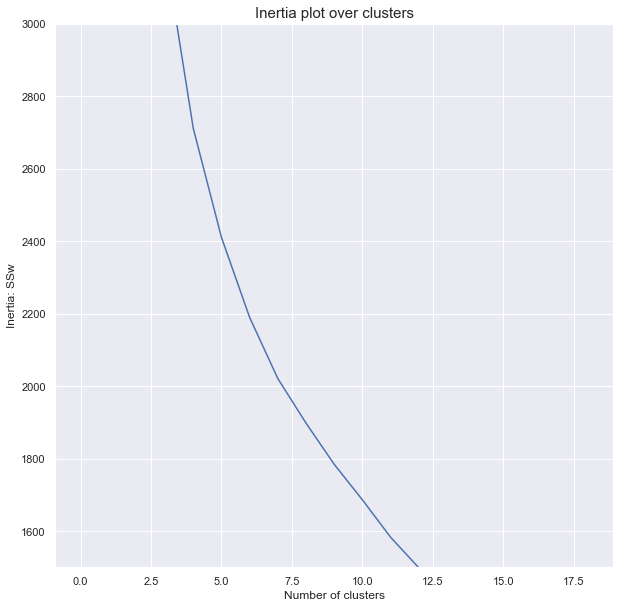

In [145]:
nodes = sm.get_node_vectors()
df_nodes = pd.DataFrame(nodes, columns=data_SOM.columns)

range_clusters = range(1, 20)
inertia = []
for n_clus in range_clusters:
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_nodes)
    inertia.append(kmclust.inertia_)  
    
plt.figure(figsize=(10,10))
plt.plot(inertia)
plt.ylim(1500, 3000)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [146]:
# Clustering SOM units with K-means
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = sm.cluster(kmeans)

df_nodes['label'] = nodeclus_labels

In [147]:
# SOM's BMUs labels
bmus_map = sm.find_bmu(data_SOM)[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((data_SOM, np.expand_dims(bmus_map,1)), axis=1),
    index=data_SOM.index, columns=np.append(data_SOM.columns,"BMU")
)

# Cluster labels for each observation
som_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)

In [148]:
# Variables mean value for each cluster
som_final.drop(columns='BMU').groupby('label').mean()

,INCOME_5.0,INCOME_6.0,INCOME_7.0,IC5,IC6,IC10,IC12,RP1,HVP2
label,,,,,,,,,
0,0.147015,0.312656,0.353900,2.586847,-1.371914,1.070841,2.822263,1.404976,1.932470
1,0.307975,0.078248,0.048988,0.015778,-0.060616,0.026726,-0.145504,0.993093,1.479325
2,0.229724,0.222133,0.225463,0.777808,-1.016891,1.265257,0.819622,1.452310,1.829889
3,0.269571,0.100169,0.207202,0.353434,-1.111481,1.236759,0.255218,1.065757,-0.177404
4,0.164252,0.023258,0.046435,-0.726800,1.235062,-1.016115,-0.552073,-0.799853,-0.583373
5,0.175983,0.094557,0.050886,-0.354699,0.229193,-0.449889,-0.439377,-0.545653,-0.528479
6,0.257676,0.134599,0.055678,0.081985,-0.571306,0.475167,-0.061842,-0.232930,-0.379134


In [149]:
# Number of observations in each cluster
som_final['label'].value_counts()

4    24852
5    23150
6    15015
3    10053
2     7509
0     6013
1     5981
Name: label, dtype: int64

In [152]:
# Solution Assesment - R-squared
sst = get_ss(som_final.drop(columns=['BMU', 'label']))  # get total sum of squares
ssw_labels = som_final[som_final.drop(columns=['BMU', 'label']).columns.to_list() + ["label"]].groupby(by='label').apply(get_ss)
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.7142684816116153

In [153]:
data_clus = data.merge(som_final['label'], left_index=True, right_index=True)

In [154]:
data_clus_not_std = data_not_std.merge(som_final['label'], left_index=True, right_index=True)

Clustering SOM units with Hierarchical Clustering 

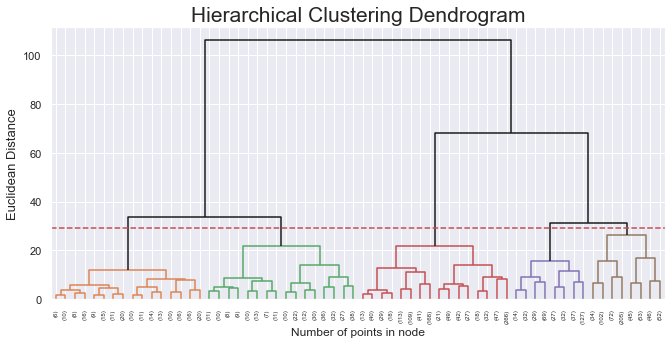

In [212]:
nodes = sm.get_node_vectors()
df_nodes = pd.DataFrame(nodes, columns=data_SOM.columns)

hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_nodes)

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([hclust.children_, hclust.distances_, counts]).astype(float)

sns.set()
fig = plt.figure(figsize=(11,5))
y_threshold = 29
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title('Hierarchical Clustering Dendrogram', fontsize=21)
plt.xlabel('Number of points in node')
plt.ylabel('Euclidean Distance', fontsize=13)
plt.show()

In [1094]:
# Clustering SOM units with Hierarchical Clustering
hierclust = AgglomerativeClustering(n_clusters=5, linkage='ward')
nodeclus_labels = sm.cluster(hierclust)

df_nodes['label'] = nodeclus_labels

In [1096]:
# SOM's BMUs labels
bmus_map = sm.find_bmu(data_SOM)[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((data_SOM, np.expand_dims(bmus_map,1)), axis=1),
    index=data_SOM.index, columns=np.append(data_SOM.columns,"BMU")
)

# Cluster labels for each observation
som_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)

In [1098]:
# Variables mean value for each cluster
(som_final.drop(columns='BMU').groupby('label').mean())

,INCOME_5.0,INCOME_6.0,INCOME_7.0,IC5,IC6,IC10,IC12,RP1,HVP2
label,,,,,,,,,
0,0.251547,0.112431,0.017922,-0.102250,-0.286351,0.079243,-0.259443,0.024040,-0.193581
1,0.172303,0.287334,0.319195,1.968338,-1.213998,1.102370,2.152662,1.342393,1.850883
2,0.137203,0.043495,0.054224,-0.579324,0.852443,-0.804682,-0.506349,-0.721819,-0.557708
3,0.278986,0.156341,0.124275,0.265946,-0.745307,0.929997,0.118352,1.602997,1.975580
4,0.357902,0.136205,0.198341,0.385445,-1.035457,1.199760,0.310856,0.573389,-0.146966


In [1099]:
# Number of observations in each cluster
som_final['label'].value_counts()

2    42878
0    20199
4    13744
1    10232
3     5520
Name: label, dtype: int64

In [1100]:
# Solution Assesment - R-squared
sst = get_ss(som_final.drop(columns=['BMU', 'label']))  # get total sum of squares
ssw_labels = som_final[som_final.drop(columns=['BMU', 'label']).columns.to_list() + ["label"]].groupby(by='label').apply(get_ss)
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.6479629215772463

#### SOM on top of Principal Components

In [130]:
data_SOM = pca_data

In [131]:
np.random.seed(42)

sm = sompy.SOMFactory().build(
    data_SOM.values, 
    mapsize=(50, 50), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa'
)
sm.train(n_job=-1, verbose=None, train_rough_len=100, train_finetune_len=100)

Clustering SOM units with K-means

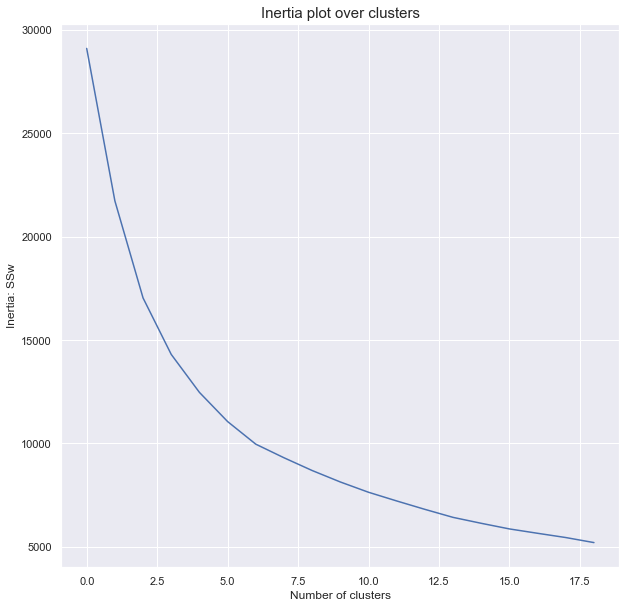

In [134]:
nodes = sm.get_node_vectors()
df_nodes = pd.DataFrame(nodes, columns=data_SOM.columns)

range_clusters = range(1, 20)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_nodes)
    inertia.append(kmclust.inertia_)  
    
plt.figure(figsize=(10,10))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [196]:
# Clustering SOM units with K-means
kmeans = KMeans(n_clusters=8, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = sm.cluster(kmeans)

df_nodes['label'] = nodeclus_labels

In [198]:
# SOM's BMUs labels
bmus_map = sm.find_bmu(data_SOM)[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((data_SOM, np.expand_dims(bmus_map,1)), axis=1),
    index=data_SOM.index, columns=np.append(data_SOM.columns,"BMU")
)

# Cluster labels for each observation
som_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)

In [200]:
# Variables mean value for each cluster
som_final.drop(columns='BMU').groupby('label').mean()

,PC0,PC1,PC2,PC3,PC4
label,,,,,
0,-2.098394,-1.533298,0.381646,0.759853,-0.487403
1,2.557135,-0.288068,0.384079,-0.424450,0.809206
2,-4.345150,1.382517,-0.324383,-0.968465,0.764292
3,0.065471,4.158151,-0.037398,1.949410,-0.143835
4,0.617081,1.225079,0.587811,1.261651,-0.767478
5,0.830140,-1.350995,-2.137547,0.017754,-0.022014
6,0.632554,-1.625242,1.252667,-0.131846,0.069445
7,1.289262,1.655832,-0.033190,-1.707941,-1.070991


In [201]:
# Number of observations in each cluster
som_final['label'].value_counts()

1    17604
0    15879
5    13247
6    12710
2    10682
7     8845
3     7463
4     6143
Name: label, dtype: int64

In [202]:
# Solution Assesment - R-squared
sst = get_ss(som_final.drop(columns=['BMU', 'label']))  # get total sum of squares
ssw_labels = som_final[som_final.drop(columns=['BMU', 'label']).columns.to_list() + ["label"]].groupby(by='label').apply(get_ss)
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.5556435596220469

Clustering SOM units with Hierarchical Clustering 

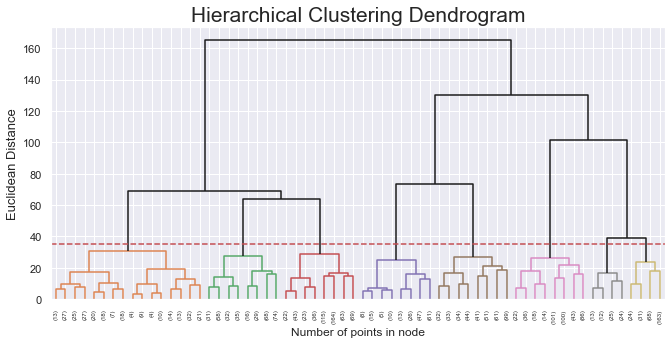

In [174]:
nodes = sm.get_node_vectors()
df_nodes = pd.DataFrame(nodes, columns=data_SOM.columns)

hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_nodes)

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([hclust.children_, hclust.distances_, counts]).astype(float)

sns.set()
fig = plt.figure(figsize=(11,5))
y_threshold = 35
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title('Hierarchical Clustering Dendrogram', fontsize=21)
plt.xlabel('Number of points in node')
plt.ylabel('Euclidean Distance', fontsize=13)
plt.show()

In [2]:
# Clustering SOM units with Hierarchical Clustering
hierclust = AgglomerativeClustering(n_clusters=8, linkage='ward')
nodeclus_labels = sm.cluster(hierclust)

df_nodes['label'] = nodeclus_labels

In [177]:
# SOM's BMUs labels
bmus_map = sm.find_bmu(data_SOM)[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((data_SOM, np.expand_dims(bmus_map,1)), axis=1),
    index=data_SOM.index, columns=np.append(data_SOM.columns,"BMU")
)

# Cluster labels for each observation
som_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)

In [179]:
# Variables mean value for each cluster
som_final.drop(columns='BMU').groupby('label').mean()

,PC0,PC1,PC2,PC3,PC4
label,,,,,
0,0.205801,-0.423325,-0.409164,1.173392,-0.349122
1,1.081118,-1.428865,1.426885,-0.347076,0.297384
2,0.344020,3.073154,0.171137,1.823393,-0.361485
3,-2.104055,-1.593553,0.453686,0.686862,-0.471570
4,-4.503953,1.254956,-0.406517,-0.767789,0.898018
5,0.895026,1.633948,-0.127648,-1.645364,-1.069692
6,2.606817,-0.366818,-0.220339,-0.350972,0.840818
7,0.764790,-1.375211,-2.264461,-0.077565,-0.083435


In [180]:
# Number of observations in each cluster
som_final['label'].value_counts()

1    15947
3    15184
6    14417
2    11771
5    11219
4    10002
7     9293
0     4740
Name: label, dtype: int64

In [181]:
# Solution Assesment - R-squared
sst = get_ss(som_final.drop(columns=['BMU', 'label']))  # get total sum of squares
ssw_labels = som_final[som_final.drop(columns=['BMU', 'label']).columns.to_list() + ["label"]].groupby(by='label').apply(get_ss)
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.5316378001933422

#### Economical perspective 

In [184]:
data_SOM = data[vars_cluster_Economical]

In [185]:
np.random.seed(42)

sm = sompy.SOMFactory().build(
    data_SOM.values, 
    mapsize=(50, 50), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa'
)
sm.train(n_job=-1, verbose=None, train_rough_len=100, train_finetune_len=100)

Clustering SOM units with K-means

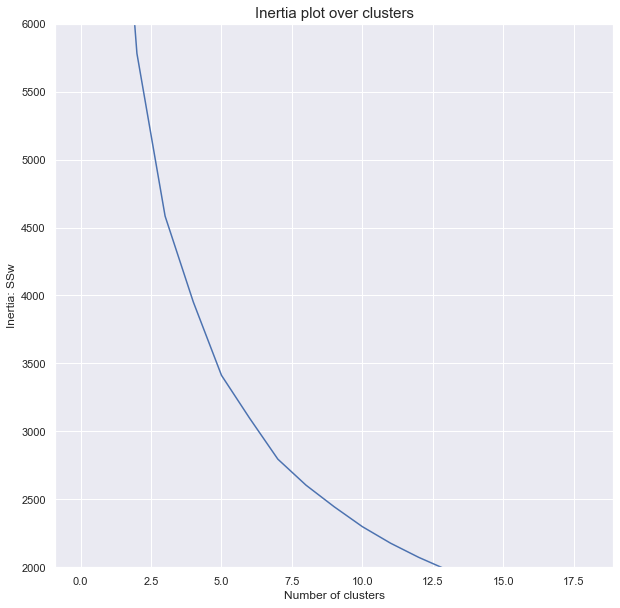

In [520]:
nodes = sm.get_node_vectors()
df_nodes = pd.DataFrame(nodes, columns=data_SOM.columns)

range_clusters = range(1, 20)
inertia = []
for n_clus in range_clusters:  
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_nodes)
    inertia.append(kmclust.inertia_)  
    
plt.figure(figsize=(10,10))
plt.plot(inertia)
plt.ylim(2000, 6000)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [521]:
# Clustering SOM units with K-means
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = sm.cluster(kmeans)

df_nodes['label'] = nodeclus_labels

In [523]:
# SOM's BMUs labels
bmus_map = sm.find_bmu(data_SOM)[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((data_SOM, np.expand_dims(bmus_map,1)), axis=1),
    index=data_SOM.index, columns=np.append(data_SOM.columns,"BMU")
)

# Cluster labels for each observation
som_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)

In [525]:
# Variables mean value for each cluster
som_final.drop(columns='BMU').groupby('label').mean()

,IC5,IC10,IC12,MHUC1,OCC2,RP1,HVP2,HVP5,HVP6
label,,,,,,,,,
0,-0.375674,-0.429035,-0.427369,-0.390188,-0.404011,-0.512483,-0.488849,0.164762,-0.331785
1,2.387085,0.913320,2.183879,2.198152,1.547380,1.580618,2.330364,0.839239,3.621759
2,0.559146,1.424306,0.507135,0.382203,1.029363,0.905762,-0.050086,0.800174,-0.266249
3,-0.709141,-0.914522,-0.550333,-0.632779,-0.801658,-0.856542,-0.636433,-1.437507,-0.354084
4,0.245017,0.769098,0.224995,0.752268,0.263949,1.376456,1.772603,0.827173,0.437125
5,0.085457,0.341902,-0.119820,-0.065010,0.289160,0.128534,-0.286450,0.651510,-0.295182
6,1.762474,1.235438,2.387128,1.410185,1.760607,1.044910,1.311150,0.826461,0.378215


In [526]:
# Number of observations in each cluster
som_final['label'].value_counts()

3    25325
0    24327
5    16787
4     9188
2     8045
1     5165
6     3736
Name: label, dtype: int64

In [527]:
# Solution Assesment - R-squared
sst = get_ss(som_final.drop(columns=['BMU', 'label']))  # get total sum of squares
ssw_labels = som_final[som_final.drop(columns=['BMU', 'label']).columns.to_list() + ["label"]].groupby(by='label').apply(get_ss)
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.7090496657810162

Clustering SOM units with Hierarchical Clustering

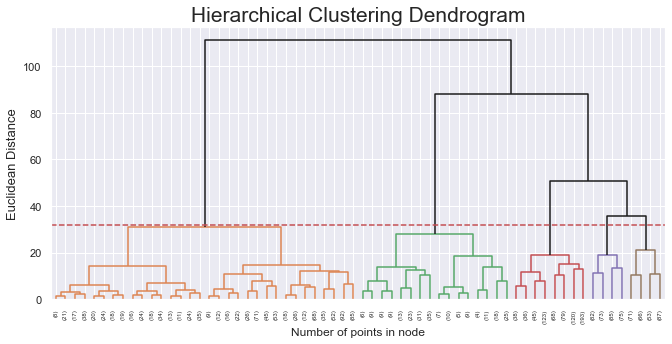

In [187]:
nodes = sm.get_node_vectors()
df_nodes = pd.DataFrame(nodes, columns=data_SOM.columns)

hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_nodes)

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([hclust.children_, hclust.distances_, counts]).astype(float)

sns.set()
fig = plt.figure(figsize=(11,5))
y_threshold = 32
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title('Hierarchical Clustering Dendrogram', fontsize=21)
plt.xlabel('Number of points in node')
plt.ylabel('Euclidean Distance', fontsize=13)
plt.show()

In [537]:
# Clustering SOM units with Hierarchical Clustering
hierclust = AgglomerativeClustering(n_clusters=5, linkage='ward')
nodeclus_labels = sm.cluster(hierclust)

df_nodes['label'] = nodeclus_labels

In [539]:
# SOM's BMUs labels
bmus_map = sm.find_bmu(data_SOM)[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((data_SOM, np.expand_dims(bmus_map,1)), axis=1),
    index=data_SOM.index, columns=np.append(data_SOM.columns,"BMU")
)

# Cluster labels for each observation
som_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)

In [541]:
# Variables mean value for each cluster
som_final.drop(columns='BMU').groupby('label').mean()

,IC5,IC10,IC12,MHUC1,OCC2,RP1,HVP2,HVP5,HVP6
label,,,,,,,,,
0,-0.586425,-0.751217,-0.507666,-0.565398,-0.627531,-0.781120,-0.595968,-0.849466,-0.347744
1,0.147552,0.725111,0.164847,0.649896,0.139635,1.252933,1.649311,0.822285,0.315562
2,2.158321,0.955026,2.216176,1.970541,1.586812,1.401034,2.062554,0.834608,2.535610
3,-0.020931,0.162302,-0.191325,-0.124199,0.092352,0.003921,-0.356105,0.602309,-0.308819
4,0.620823,1.372307,0.601071,0.433154,1.032300,0.970041,0.040139,0.804767,-0.242037


In [542]:
# Number of observations in each cluster
som_final['label'].value_counts()

0    42555
3    22322
4     9818
1     9578
2     8300
Name: label, dtype: int64

In [543]:
# Solution Assesment - R-squared
sst = get_ss(som_final.drop(columns=['BMU', 'label']))  # get total sum of squares
ssw_labels = som_final[som_final.drop(columns=['BMU', 'label']).columns.to_list() + ["label"]].groupby(by='label').apply(get_ss)
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.6425718797904242

#### Client Value perspective

In [301]:
data_SOM = data[vars_cluster_ClientValue]

In [302]:
np.random.seed(42)

sm = sompy.SOMFactory().build(
    data_SOM.values, 
    mapsize=(50, 50), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa'
)
sm.train(n_job=-1, verbose=None, train_rough_len=100, train_finetune_len=100)

Clustering SOM units with K-means

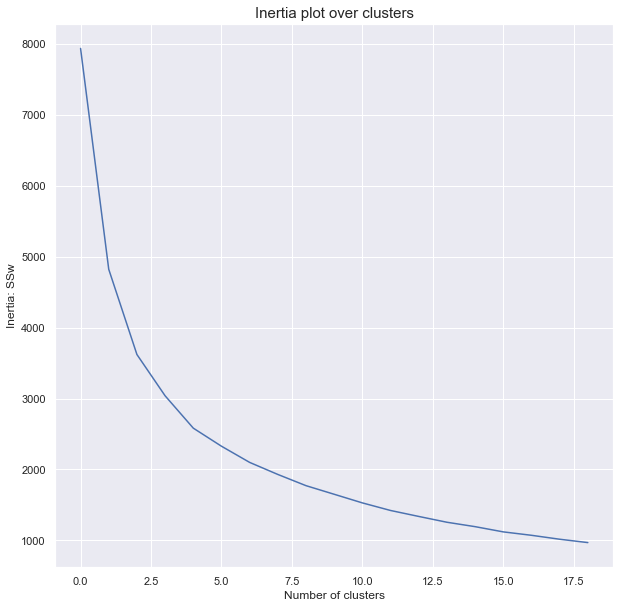

In [304]:
nodes = sm.get_node_vectors()
df_nodes = pd.DataFrame(nodes, columns=data_SOM.columns)

range_clusters = range(1, 20)
inertia = []
for n_clus in range_clusters: 
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_nodes)
    inertia.append(kmclust.inertia_)  
    
plt.figure(figsize=(10,10))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [333]:
# Clustering SOM units with K-means
kmeans = KMeans(n_clusters=6, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = sm.cluster(kmeans)

df_nodes['label'] = nodeclus_labels

In [335]:
# SOM's BMUs labels
bmus_map = sm.find_bmu(data_SOM)[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((data_SOM, np.expand_dims(bmus_map,1)), axis=1),
    index=data_SOM.index, columns=np.append(data_SOM.columns,"BMU")
)

# Cluster labels for each observation
som_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)

In [337]:
# Variables mean value for each cluster
som_final.drop(columns='BMU').groupby('label').mean()

,NGIFTALL,MINRAMNT,RFA_9F,RFA_16F,RFA_17F
label,,,,,
0,-0.510792,-0.183939,-0.291157,-0.490649,-0.417474
1,0.116931,-0.351555,-0.065849,0.482525,0.960480
2,0.815691,-0.539974,-0.420861,-0.029017,-0.220194
3,-0.910957,1.660372,-0.993225,-1.038059,-0.872528
4,0.513033,-0.459737,1.388514,0.676016,-0.332506
5,1.236641,-0.522023,1.281486,1.611270,1.847978


In [338]:
# Number of observations in each cluster
som_final['label'].value_counts()

0    30216
3    16254
1    12464
4    11368
5    11367
2    10904
Name: label, dtype: int64

In [339]:
# Solution Assesment - R-squared
sst = get_ss(som_final.drop(columns=['BMU', 'label']))  # get total sum of squares
ssw_labels = som_final[som_final.drop(columns=['BMU', 'label']).columns.to_list() + ["label"]].groupby(by='label').apply(get_ss)
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.6449810992354572

Clustering SOM units with Hierarchical Clustering

In [340]:
nodes = sm.get_node_vectors()
df_nodes = pd.DataFrame(nodes, columns=data_SOM.columns)

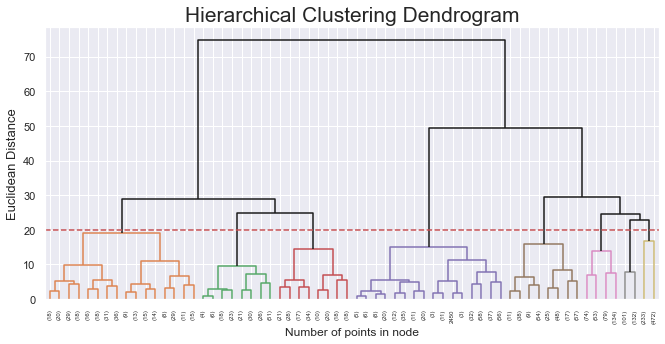

In [341]:
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_nodes)

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([hclust.children_, hclust.distances_, counts]).astype(float)

sns.set()
fig = plt.figure(figsize=(11,5))
y_threshold = 20
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title('Hierarchical Clustering Dendrogram', fontsize=21)
plt.xlabel('Number of points in node')
plt.ylabel('Euclidean Distance', fontsize=13)
plt.show()

In [356]:
# Clustering SOM units with Hierarchical Clustering
hierclust = AgglomerativeClustering(n_clusters=8, linkage='ward')
nodeclus_labels = sm.cluster(hierclust)

df_nodes['label'] = nodeclus_labels

In [358]:
# SOM's BMUs labels
bmus_map = sm.find_bmu(data_SOM)[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((data_SOM, np.expand_dims(bmus_map,1)), axis=1),
    index=data_SOM.index, columns=np.append(data_SOM.columns,"BMU")
)

# Cluster labels for each observation
som_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)

In [360]:
# Variables mean value for each cluster
som_final.drop(columns='BMU').groupby('label').mean()

,NGIFTALL,MINRAMNT,RFA_9F,RFA_16F,RFA_17F
label,,,,,
0,0.697904,-0.491073,1.431369,0.993222,0.070380
1,-0.223867,-0.331556,-0.400173,0.049241,-0.002432
2,-0.915896,1.780891,-0.971762,-1.008964,-0.844869
3,1.030279,-0.544320,-0.264237,-0.167758,0.311296
4,1.480511,-0.540975,1.407240,1.810687,1.926672
5,0.199440,-0.369150,-0.119345,1.338452,1.354255
6,-0.346930,-0.249707,0.704485,-0.491384,-0.447016
7,-0.677773,-0.008589,-0.765543,-0.767946,-0.722737


In [361]:
# Number of observations in each cluster
som_final['label'].value_counts()

1    20552
2    15037
6    13631
7    10509
3    10420
0     9212
4     8138
5     5074
Name: label, dtype: int64

In [362]:
# Solution Assesment - R-squared
sst = get_ss(som_final.drop(columns=['BMU', 'label']))  # get total sum of squares
ssw_labels = som_final[som_final.drop(columns=['BMU', 'label']).columns.to_list() + ["label"]].groupby(by='label').apply(get_ss)
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.666719874484121

#### Demographic perspective

In [192]:
data_SOM = data[vars_cluster_Demographic]

In [193]:
np.random.seed(42)

sm = sompy.SOMFactory().build(
    data_SOM.values, 
    mapsize=(50, 50), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa'
)
sm.train(n_job=-1, verbose=None, train_rough_len=100, train_finetune_len=100)

Clustering SOM units with K-means

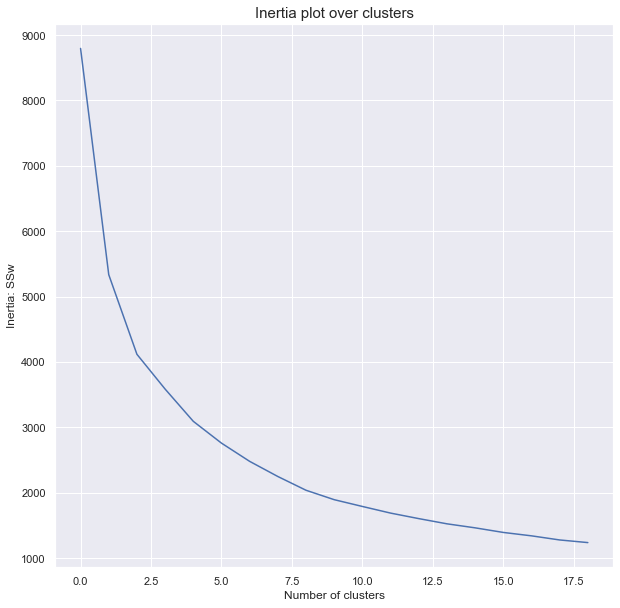

In [366]:
nodes = sm.get_node_vectors()
df_nodes = pd.DataFrame(nodes, columns=data_SOM.columns)

range_clusters = range(1, 20)
inertia = []
for n_clus in range_clusters:  
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_nodes)
    inertia.append(kmclust.inertia_)  
    
plt.figure(figsize=(10,10))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [402]:
# Clustering SOM units with K-means
kmeans = KMeans(n_clusters=8, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = sm.cluster(kmeans)

df_nodes['label'] = nodeclus_labels

In [404]:
# SOM's BMUs labels
bmus_map = sm.find_bmu(data_SOM)[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((data_SOM, np.expand_dims(bmus_map,1)), axis=1),
    index=data_SOM.index, columns=np.append(data_SOM.columns,"BMU")
)

# Cluster labels for each observation
som_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)

In [406]:
# Variables mean value for each cluster
som_final.drop(columns='BMU').groupby('label').mean()

,AGEC2,ETHC1,HHAGE2,AGE907,VC1
label,,,,,
0,0.112433,-1.539761,-0.214678,0.843542,-0.104405
1,0.269168,0.826980,-0.343659,0.603899,-0.025258
2,-2.064523,-1.537753,2.802294,-2.096205,-1.104317
3,0.602777,-1.160253,-0.055862,-1.402632,-0.268249
4,-1.079812,-0.648957,0.656466,-0.993894,-0.828380
5,1.426819,1.200994,-0.932945,1.102598,1.249096
6,0.366742,0.017736,-0.564481,0.057916,1.013690
7,-0.379017,0.136769,0.261037,-0.034932,-0.413779


In [407]:
# Number of observations in each cluster
som_final['label'].value_counts()

7    24360
1    16647
6    12193
5    11336
4    11124
0     6754
3     6123
2     4036
Name: label, dtype: int64

In [408]:
# Solution Assesment - R-squared
sst = get_ss(som_final.drop(columns=['BMU', 'label']))  # get total sum of squares
ssw_labels = som_final[som_final.drop(columns=['BMU', 'label']).columns.to_list() + ["label"]].groupby(by='label').apply(get_ss)
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.6389496625402539

Clustering SOM units with Hierarchical Clustering

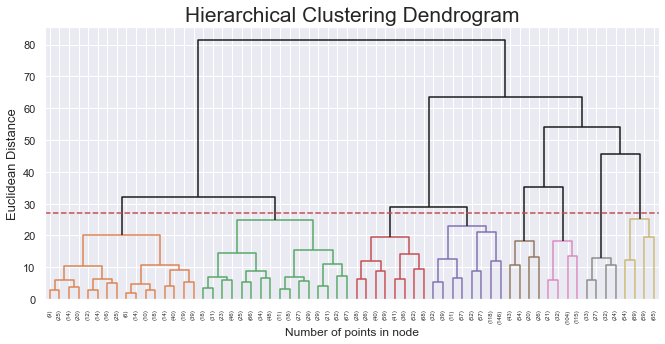

In [195]:
nodes = sm.get_node_vectors()
df_nodes = pd.DataFrame(nodes, columns=data_SOM.columns)

hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_nodes)

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([hclust.children_, hclust.distances_, counts]).astype(float)

sns.set()
fig = plt.figure(figsize=(11,5))
y_threshold = 27
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title('Hierarchical Clustering Dendrogram', fontsize=21)
plt.xlabel('Number of points in node')
plt.ylabel('Euclidean Distance', fontsize=13)
plt.show()

In [432]:
# Clustering SOM units with Hierarchical Clustering
hierclust = AgglomerativeClustering(n_clusters=8, linkage='ward')
nodeclus_labels = sm.cluster(hierclust)

df_nodes['label'] = nodeclus_labels

In [434]:
# SOM's BMUs labels
bmus_map = sm.find_bmu(data_SOM)[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((data_SOM, np.expand_dims(bmus_map,1)), axis=1),
    index=data_SOM.index, columns=np.append(data_SOM.columns,"BMU")
)

# Cluster labels for each observation
som_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)

In [436]:
# Variables mean value for each cluster
som_final.drop(columns='BMU').groupby('label').mean()

,AGEC2,ETHC1,HHAGE2,AGE907,VC1
label,,,,,
0,0.094265,-0.003594,-0.467442,-0.082220,0.431577
1,0.500882,0.952708,-0.490005,0.740993,0.263826
2,-0.954091,-0.508612,0.855264,-0.822633,-0.623623
3,-2.317033,-1.687525,2.267686,-2.356967,-1.291345
4,-0.327868,0.231499,0.440767,0.119754,-0.525381
5,1.798229,1.295584,-1.048670,1.223538,1.610605
6,0.549008,-1.108519,-0.011358,-1.445998,-0.296868
7,0.194761,-1.438663,-0.269914,0.873868,0.067911


In [437]:
# Number of observations in each cluster
som_final['label'].value_counts()

1    20633
0    19691
4    15774
2    13760
7     7329
6     5984
5     5633
3     3769
Name: label, dtype: int64

In [438]:
# Solution Assesment - R-squared
sst = get_ss(som_final.drop(columns=['BMU', 'label']))  # get total sum of squares
ssw_labels = som_final[som_final.drop(columns=['BMU', 'label']).columns.to_list() + ["label"]].groupby(by='label').apply(get_ss)
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.6031818115297943

#### Social perspective

In [439]:
data_SOM = data[vars_cluster_Social]

In [440]:
np.random.seed(42)

sm = sompy.SOMFactory().build(
    data_SOM.values, 
    mapsize=(50, 50), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa'
)
sm.train(n_job=-1, verbose=None, train_rough_len=100, train_finetune_len=100)

Clustering SOM units with K-means

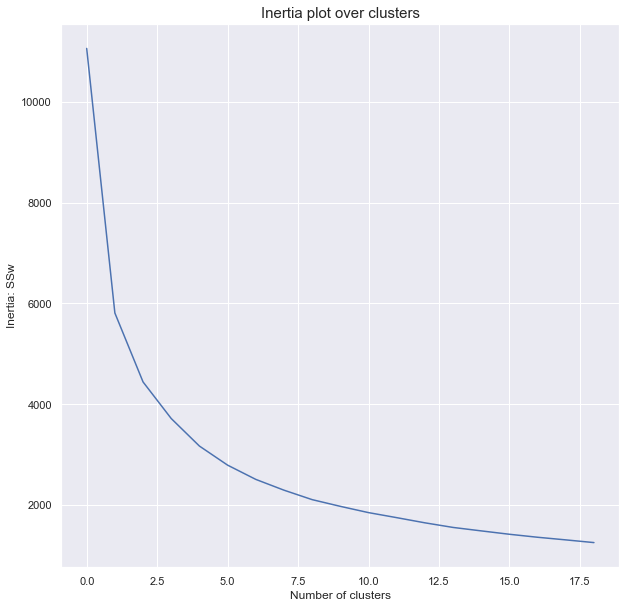

In [442]:
nodes = sm.get_node_vectors()
df_nodes = pd.DataFrame(nodes, columns=data_SOM.columns)

range_clusters = range(1, 20)
inertia = []
for n_clus in range_clusters: 
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_nodes)
    inertia.append(kmclust.inertia_)  
    
plt.figure(figsize=(10,10))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [485]:
# Clustering SOM units with K-means
kmeans = KMeans(n_clusters=6, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = sm.cluster(kmeans)

df_nodes['label'] = nodeclus_labels

In [487]:
# SOM's BMUs labels
bmus_map = sm.find_bmu(data_SOM)[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((data_SOM, np.expand_dims(bmus_map,1)), axis=1),
    index=data_SOM.index, columns=np.append(data_SOM.columns,"BMU")
)

# Cluster labels for each observation
som_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)

In [489]:
# Variables mean value for each cluster
som_final.drop(columns='BMU').groupby('label').mean()

,VOC1,RHP2,HHD12,DW4,HHN1,MARR1
label,,,,,,
0,0.619455,1.268766,-0.481841,-0.660182,-0.937358,0.896632
1,-0.185652,-1.315484,2.606488,1.989889,1.530280,-1.794124
2,0.281516,-0.021181,-0.300010,-0.466010,-0.239260,0.372573
3,0.069821,-0.588401,0.688992,0.829410,0.419295,-0.514228
4,-2.900176,-1.428142,0.321870,1.875338,1.849525,-1.911989
5,-0.831792,-0.366966,-0.369435,-0.086448,0.512041,-0.597023


In [490]:
# Number of observations in each cluster
som_final['label'].value_counts()

2    36005
0    21396
3    14587
5    10389
4     5111
1     5085
Name: label, dtype: int64

In [491]:
# Solution Assesment - R-squared
sst = get_ss(som_final.drop(columns=['BMU', 'label']))  # get total sum of squares
ssw_labels = som_final[som_final.drop(columns=['BMU', 'label']).columns.to_list() + ["label"]].groupby(by='label').apply(get_ss)
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.6462706294053762

Clustering SOM units with Hierarchical Clustering

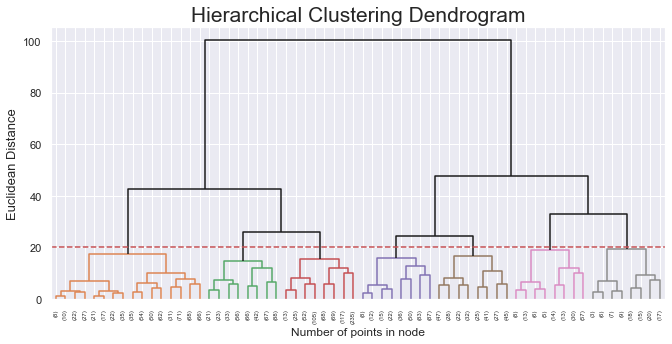

In [493]:
nodes = sm.get_node_vectors()
df_nodes = pd.DataFrame(nodes, columns=data_SOM.columns)

hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_nodes)

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([hclust.children_, hclust.distances_, counts]).astype(float)

sns.set()
fig = plt.figure(figsize=(11,5))
y_threshold = 20
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title('Hierarchical Clustering Dendrogram', fontsize=21)
plt.xlabel('Number of points in node')
plt.ylabel('Euclidean Distance', fontsize=13)
plt.show()

In [508]:
# Clustering SOM units with Hierarchical Clustering
hierclust = AgglomerativeClustering(n_clusters=7, linkage='ward')
nodeclus_labels = sm.cluster(hierclust)

df_nodes['label'] = nodeclus_labels

In [510]:
# SOM's BMUs labels
bmus_map = sm.find_bmu(data_SOM)[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((data_SOM, np.expand_dims(bmus_map,1)), axis=1),
    index=data_SOM.index, columns=np.append(data_SOM.columns,"BMU")
)

# Cluster labels for each observation
som_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)

In [512]:
# Variables mean value for each cluster
som_final.drop(columns='BMU').groupby('label').mean()

,VOC1,RHP2,HHD12,DW4,HHN1,MARR1
label,,,,,,
0,-3.394637,-1.299759,0.107201,1.547674,1.483266,-2.088001
1,-0.466115,-1.455147,2.378400,2.213529,1.710487,-1.865940
2,-0.683044,-0.491136,-0.089840,0.337494,0.958150,-0.637235
3,0.604677,1.131440,-0.477381,-0.639855,-0.896627,0.838663
4,-0.025144,-0.805323,0.731894,1.154662,0.439897,-0.638136
5,0.407374,0.040940,0.472542,-0.031006,-0.184904,0.080047
6,0.067783,-0.171296,-0.503459,-0.552782,-0.114987,0.292277


In [513]:
# Number of observations in each cluster
som_final['label'].value_counts()

6    26011
3    24977
5    14156
2     9847
4     8359
1     5331
0     3892
Name: label, dtype: int64

In [514]:
# Solution Assesment - R-squared
sst = get_ss(som_final.drop(columns=['BMU', 'label']))  # get total sum of squares
ssw_labels = som_final[som_final.drop(columns=['BMU', 'label']).columns.to_list() + ["label"]].groupby(by='label').apply(get_ss)
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.6396181027457456

### 7.3. Density-Based Clustering - Mean-Shift

In [101]:
for quantile in np.arange(0.1, 0.3, 0.05):
    bandwidth = estimate_bandwidth(pca_data, quantile=quantile, n_samples = 10000, random_state=1, n_jobs=-1)
    Mean_Shift = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
    MS_clusters_labels = Mean_Shift.fit_predict(pca_data)
    df_MS = pd.concat([pca_data, pd.Series(MS_clusters_labels, index=pca_data.index, name="MS_labels")], axis=1)
    sst = get_ss(pca_data)  # get total sum of squares
    ssw_labels = df_MS.groupby(by='MS_labels').apply(get_ss)  # compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
    r2 = ssb / sst
    print("Number of estimated clusters : %d" % len(np.unique(MS_clusters_labels)))
    print(df_MS['MS_labels'].value_counts())
    print("Cluster solution with R^2 of %0.4f" % r2)
    print('-----------------------------------------------------------------------------------------------------------------------')

Number of estimated clusters : 10
0    84893
1     4678
6     1555
2      523
9      373
5      373
4      125
7       28
3       24
8        1
Name: MS_labels, dtype: int64
Cluster solution with R^2 of 0.2343
-----------------------------------------------------------------------------------------------------------------------
Number of estimated clusters : 6
0    87670
3     4025
4      817
1       46
2       14
5        1
Name: MS_labels, dtype: int64
Cluster solution with R^2 of 0.1623
-----------------------------------------------------------------------------------------------------------------------
Number of estimated clusters : 5
0    90652
4      991
2      877
1       52
3        1
Name: MS_labels, dtype: int64
Cluster solution with R^2 of 0.0854
-----------------------------------------------------------------------------------------------------------------------
Number of estimated clusters : 4
0    91652
2      854
1       66
3        1
Name: MS_labels, dtype: int64
Clus

In [111]:
for quantile in np.arange(0.2, 1, 0.2):
    bandwidth = estimate_bandwidth(data[vars_PCA_ClientValue], quantile=quantile, n_samples = 10000, random_state=1, n_jobs=-1)
    Mean_Shift = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
    MS_clusters_labels = Mean_Shift.fit_predict(data[vars_PCA_ClientValue])
    df_MS = pd.concat([data[vars_PCA_ClientValue], pd.Series(MS_clusters_labels, index=data[vars_PCA_ClientValue].index, name="MS_labels")], axis=1)
    sst = get_ss(data[vars_PCA_ClientValue])  # get total sum of squares
    ssw_labels = df_MS.groupby(by='MS_labels').apply(get_ss)  # compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
    r2 = ssb / sst
    print("Number of estimated clusters : %d" % len(np.unique(MS_clusters_labels)))
    print(df_MS['MS_labels'].value_counts())
    print("Cluster solution with R^2 of %0.4f" % r2)
    print('-----------------------------------------------------------------------------------------------------------------------')

Number of estimated clusters : 9
0    91363
1      847
7      274
2       70
3       11
5        3
4        3
8        1
6        1
Name: MS_labels, dtype: int64
Cluster solution with R^2 of 0.1003
-----------------------------------------------------------------------------------------------------------------------
Number of estimated clusters : 7
0    90104
1     2332
2       79
5       51
4        3
3        3
6        1
Name: MS_labels, dtype: int64
Cluster solution with R^2 of 0.1163
-----------------------------------------------------------------------------------------------------------------------
Number of estimated clusters : 6
0    92333
4      118
1      115
3        3
2        3
5        1
Name: MS_labels, dtype: int64
Cluster solution with R^2 of 0.0495
-----------------------------------------------------------------------------------------------------------------------
Number of estimated clusters : 5
0    92445
1      121
3        3
2        3
4        1
Name: MS_labe

In [115]:
for quantile in np.arange(0.15, 0.4, 0.1):
    bandwidth = estimate_bandwidth(data[vars_PCA_Demographic], quantile=quantile, n_samples = 10000, random_state=1, n_jobs=-1)
    Mean_Shift = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
    MS_clusters_labels = Mean_Shift.fit_predict(data[vars_PCA_Demographic])
    df_MS = pd.concat([data[vars_PCA_Demographic], pd.Series(MS_clusters_labels, index=data[vars_PCA_Demographic].index, name="MS_labels")], axis=1)
    sst = get_ss(data[vars_PCA_Demographic])  # get total sum of squares
    ssw_labels = df_MS.groupby(by='MS_labels').apply(get_ss)  # compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
    r2 = ssb / sst
    print("Number of estimated clusters : %d" % len(np.unique(MS_clusters_labels)))
    print(df_MS['MS_labels'].value_counts())
    print("Cluster solution with R^2 of %0.4f" % r2)
    print('-----------------------------------------------------------------------------------------------------------------------')

Number of estimated clusters : 9
0    90539
1     1260
2      376
4      169
8      121
5       70
3       24
6        8
7        6
Name: MS_labels, dtype: int64
Cluster solution with R^2 of 0.1350
-----------------------------------------------------------------------------------------------------------------------
Number of estimated clusters : 6
0    91517
1      691
2      176
5      158
4       23
3        8
Name: MS_labels, dtype: int64
Cluster solution with R^2 of 0.0881
-----------------------------------------------------------------------------------------------------------------------
Number of estimated clusters : 4
0    91547
2      833
1      183
3       10
Name: MS_labels, dtype: int64
Cluster solution with R^2 of 0.0894
-----------------------------------------------------------------------------------------------------------------------


In [118]:
for quantile in np.arange(0.4, 0.9, 0.1):
    bandwidth = estimate_bandwidth(data[vars_PCA_Social], quantile=quantile, n_samples = 10000, random_state=1, n_jobs=-1)
    Mean_Shift = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
    MS_clusters_labels = Mean_Shift.fit_predict(data[vars_PCA_Social])
    df_MS = pd.concat([data[vars_PCA_Social], pd.Series(MS_clusters_labels, index=data[vars_PCA_Social].index, name="MS_labels")], axis=1)
    sst = get_ss(data[vars_PCA_Social])  # get total sum of squares
    ssw_labels = df_MS.groupby(by='MS_labels').apply(get_ss)  # compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
    r2 = ssb / sst
    print("Number of estimated clusters : %d" % len(np.unique(MS_clusters_labels)))
    print(df_MS['MS_labels'].value_counts())
    print("Cluster solution with R^2 of %0.4f" % r2)
    print('-----------------------------------------------------------------------------------------------------------------------')

Number of estimated clusters : 11
0     89649
1      1375
5       740
3       599
2        87
9        51
10       49
4        20
8         1
7         1
6         1
Name: MS_labels, dtype: int64
Cluster solution with R^2 of 0.2223
-----------------------------------------------------------------------------------------------------------------------
Number of estimated clusters : 7
0    91283
2      699
6      351
1      227
5       11
4        1
3        1
Name: MS_labels, dtype: int64
Cluster solution with R^2 of 0.1347
-----------------------------------------------------------------------------------------------------------------------
Number of estimated clusters : 5
0    91862
3      582
4      102
1       20
2        7
Name: MS_labels, dtype: int64
Cluster solution with R^2 of 0.0866
-----------------------------------------------------------------------------------------------------------------------
Number of estimated clusters : 4
0    92017
3      433
1      116
2        7
N

In [127]:
for quantile in np.arange(0.5, 0.65, 0.05):
    bandwidth = estimate_bandwidth(data[vars_PCA_Economical], quantile=quantile, n_samples = 10000, random_state=1, n_jobs=-1)
    Mean_Shift = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
    MS_clusters_labels = Mean_Shift.fit_predict(data[vars_PCA_Economical])
    df_MS = pd.concat([data[vars_PCA_Economical], pd.Series(MS_clusters_labels, index=data[vars_PCA_Economical].index, name="MS_labels")], axis=1)
    sst = get_ss(data[vars_PCA_Economical])  # get total sum of squares
    ssw_labels = df_MS.groupby(by='MS_labels').apply(get_ss)  # compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
    r2 = ssb / sst
    print("Number of estimated clusters : %d" % len(np.unique(MS_clusters_labels)))
    print(df_MS['MS_labels'].value_counts())
    print("Cluster solution with R^2 of %0.4f" % r2)
    print('-----------------------------------------------------------------------------------------------------------------------')

Number of estimated clusters : 10
0    88833
7     1612
5      806
6      621
2      483
3      111
1      104
9        1
8        1
4        1
Name: MS_labels, dtype: int64
Cluster solution with R^2 of 0.2476
-----------------------------------------------------------------------------------------------------------------------
Number of estimated clusters : 6
0    90034
3     1994
1      535
5        8
4        1
2        1
Name: MS_labels, dtype: int64
Cluster solution with R^2 of 0.1908
-----------------------------------------------------------------------------------------------------------------------
Number of estimated clusters : 4
0    91267
1     1243
2       55
3        8
Name: MS_labels, dtype: int64
Cluster solution with R^2 of 0.1180
-----------------------------------------------------------------------------------------------------------------------
Number of estimated clusters : 4
0    91971
2      542
1       52
3        8
Name: MS_labels, dtype: int64
Cluster solutio

### 7.4. Choosing the best clustering solution

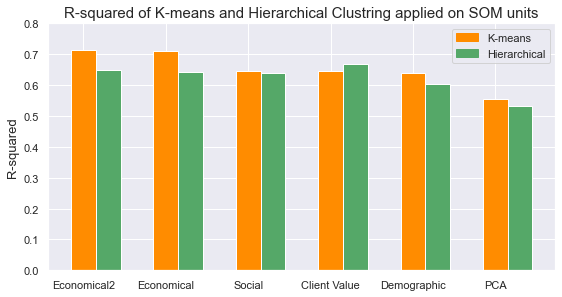

In [463]:
clustering_names = ['Economical2','Economical','Social','Client Value','Demographic', 'PCA']
r2_kmeans = [0.7142684816116153,0.7090496657810162,0.6462706294053762,0.6449810992354572,0.6389496625402539,0.5556435596220469]
r2_hierclust = [0.6479629215772463,0.6425718797904242,0.6396181027457456,0.666719874484121,0.6031818115297943,
                0.5316378001933422]
 
figure = plt.figure(figsize=(20,10))
ax = figure.add_subplot(222)

ax.bar(np.arange(0,len(clustering_names)) , r2_kmeans, width=0.3, color='darkorange', align='center')
ax.bar(np.arange(0,len(clustering_names)) + 0.3, r2_hierclust, width=0.3, color='g', align='center')

ax.set_xticks(np.arange(len(clustering_names)))
ax.set_xticklabels(clustering_names)

plt.title('R-squared of K-means and Hierarchical Clustring applied on SOM units', fontdict = {'fontsize': 15})
plt.ylabel('R-squared', fontdict = {'fontsize': 13})
plt.ylim(0,0.8)

colors = {'K-means':'darkorange', 'Hierarchical':'g'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show()

## 8. Clusters Profiling

#### Number of observations in each cluster

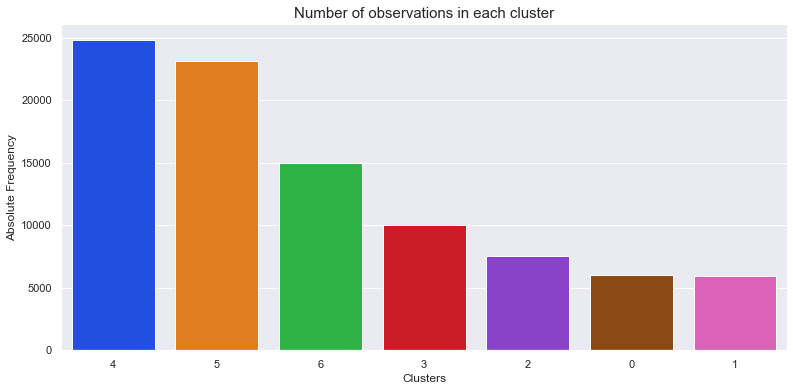

In [215]:
plt.figure(figsize=(13,6))

counts = data_clus_not_std.groupby(by='label',as_index=False).count().iloc[:,:2]
counts.columns = ['cluster', "counts"]
sns.barplot(y='counts', x='cluster', data=counts, palette='bright', order=counts.sort_values('counts', ascending = False).cluster)

plt.ylabel('Absolute Frequency', fontdict = {'fontsize': 12})
plt.xlabel('Clusters', fontdict = {'fontsize': 12})
plt.title("Number of observations in each cluster", fontdict = {'fontsize': 15})
plt.show()

#### Variables with high standard deviation 

In [155]:
clus_mean = data_clus.groupby(by='label', as_index=False).mean()

In [156]:
clus_mean_not_std = data_clus_not_std.groupby(by='label', as_index=False).mean()

In [249]:
clus_mean.std(axis=0).nlargest(20)

index    266.091466
label      2.160247
HVP2       1.172043
IC12       1.167961
IC3        1.112104
IC4        1.110454
HV2        1.095730
IC2        1.094342
IC5        1.081249
HV1        1.080445
IC1        1.071093
IC14       1.050506
HVP6       1.000611
RP1        0.966569
HV3        0.964453
HV4        0.929638
IC6        0.916763
MHUC1      0.915349
IC10       0.891283
EC1        0.871664
dtype: float64

In [250]:
clus_mean_not_std.std(axis=0).nlargest(20)

IC5        9029.168202
HV2        1032.146467
HV1        1012.215555
POP901      550.287309
index       266.091466
POP903      211.996448
IC2         185.559512
IC4         185.115176
IC3         174.910307
IC1         171.001157
POP902      105.346181
HVP2         37.491234
RP1          31.176262
POP90C1      21.609826
HVP5         21.052660
HVP6         18.080286
IC6          17.581056
HUR2         16.329314
HHP1         14.128509
POP90C3      14.014015
dtype: float64

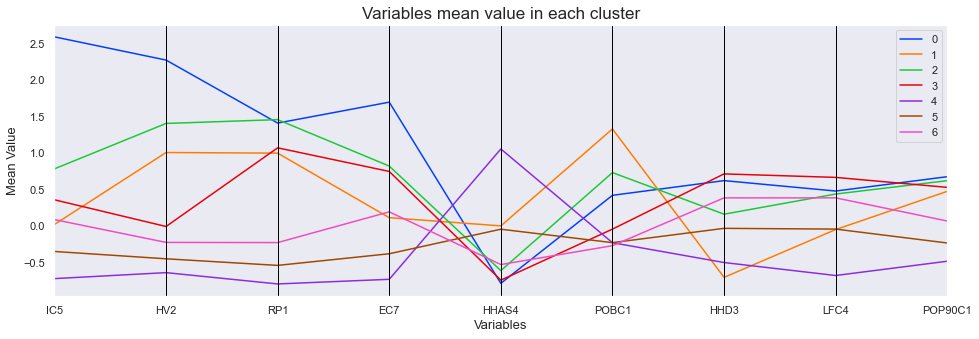

In [171]:
plt.figure(figsize=(16,5))

vars_profilling = ['IC5','HV2','RP1','EC7', 'HHAS4','POBC1','HHD3','LFC4','POP90C1','label']
vars_mean = clus_mean[vars_profilling]

pd.plotting.parallel_coordinates(vars_mean, 'label', color=sns.color_palette('bright'))

plt.ylabel('Mean Value', fontdict = {'fontsize': 13})
plt.xlabel('Variables', fontdict = {'fontsize': 13})
plt.title("Variables mean value in each cluster", fontdict = {'fontsize': 17})
plt.show()

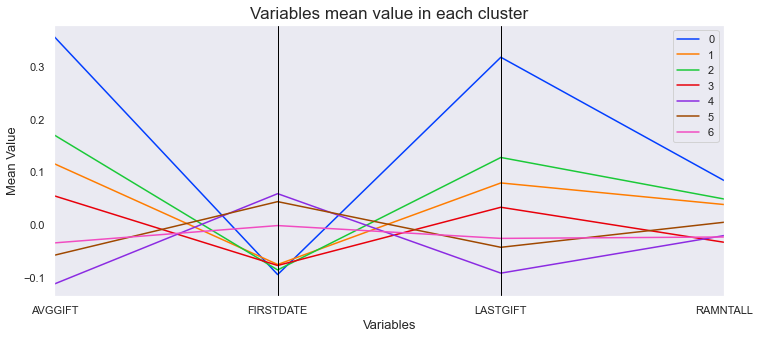

In [165]:
plt.figure(figsize=(12,5))

vars_profilling = ['AVGGIFT','FIRSTDATE','LASTGIFT','RAMNTALL','label']
vars_mean = clus_mean[vars_profilling]

pd.plotting.parallel_coordinates(vars_mean, 'label', color=sns.color_palette('bright'))

plt.ylabel('Mean Value', fontdict = {'fontsize': 13})
plt.xlabel('Variables', fontdict = {'fontsize': 13})
plt.title("Variables mean value in each cluster", fontdict = {'fontsize': 17})
plt.show()

In [168]:
clus_mean_not_std.loc['Average'] = clus_mean_not_std.mean()

In [174]:
clus_mean_not_std[['label','IC5','HV2','RP1','EC7', 'HHAS4','POBC1','HHD3','LFC4','POP90C1']]

,label,IC5,HV2,RP1,EC7,HHAS4,POBC1,HHD3,LFC4,POP90C1
0,0.0,37463.458008,3280.934642,74.741726,30.529686,3.007816,10.610843,68.735074,76.833195,90.685847
1,1.0,15993.282896,2087.422672,61.456613,15.239926,10.694031,19.337569,48.793847,69.950844,81.182244
2,2.0,22356.749634,2462.742975,76.268478,22.071381,4.711413,13.597283,61.813424,76.298841,88.101878
3,3.0,18812.942704,1132.517955,63.800358,21.359694,3.432508,6.163334,70.124043,79.273252,83.761763
4,4.0,9792.245936,536.589369,3.625905,7.081402,20.987929,4.377877,51.849871,61.738613,35.824722
5,5.0,12899.546350,715.413261,11.825011,10.464060,10.249546,4.385702,58.897581,70.032829,47.666652
6,6.0,16546.156177,926.867333,21.911755,16.010922,5.519281,3.986880,65.181885,75.613720,61.920813
Average,3.0,19123.483101,1591.784029,44.804264,17.536725,8.371789,8.922784,60.770818,72.820185,69.877703


In [170]:
clus_mean_not_std[['label','AVGGIFT','FIRSTDATE','LASTGIFT','RAMNTALL']]

,label,AVGGIFT,FIRSTDATE,LASTGIFT,RAMNTALL
0,0.0,15.920614,64.949443,20.455447,108.208059
1,1.0,14.025525,65.723290,17.866175,104.154486
2,2.0,14.453667,65.303103,18.391056,105.086893
3,3.0,13.546490,65.648861,17.365220,97.786945
4,4.0,12.231655,71.177571,16.008129,98.914218
5,5.0,12.660619,70.564147,16.540323,101.162324
6,6.0,12.844552,68.721279,16.723866,98.675136
Average,3.0,13.669018,67.441099,17.621459,101.998295


#### Binary Features

In [240]:
def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
                    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="black")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="darkorange")
    plt.legend((p2[0], p1[0]), (target+'$=1$', target+'$=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel("Clusters")
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="black")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="darkorange")
    plt.legend((p2[0], p1[0]), (target+'$=1$', target+'$=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel("Clusters")
    plt.ylabel("$Proportion$")

    plt.show()

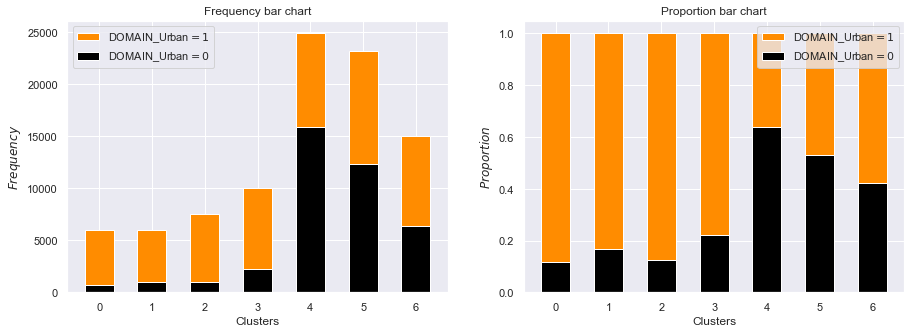

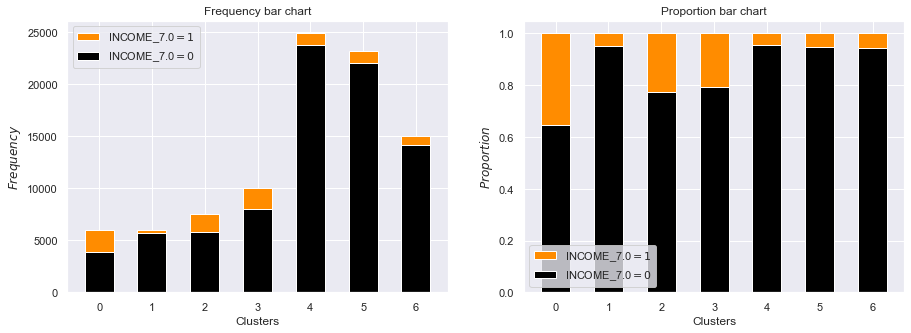

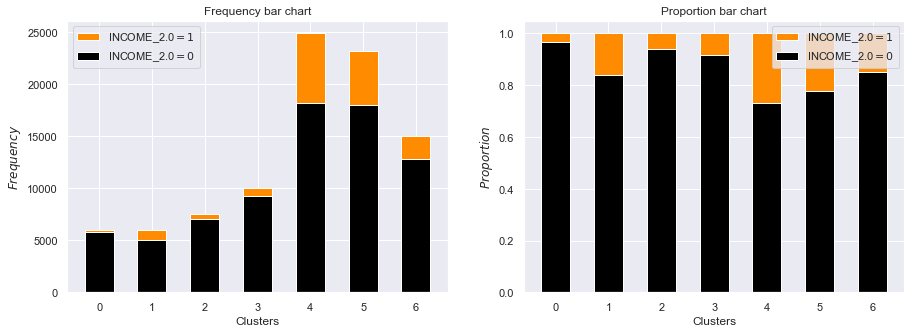

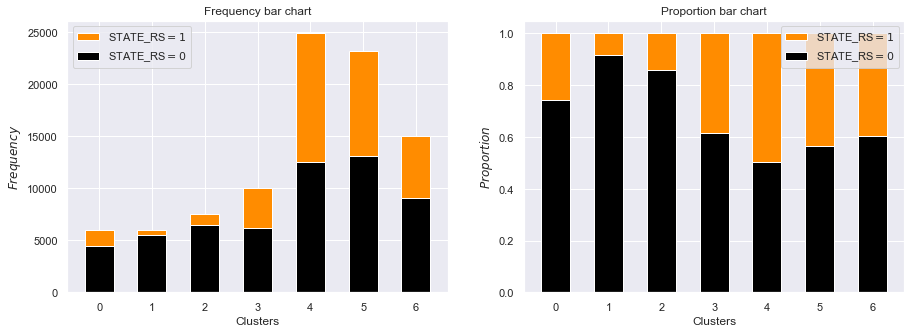

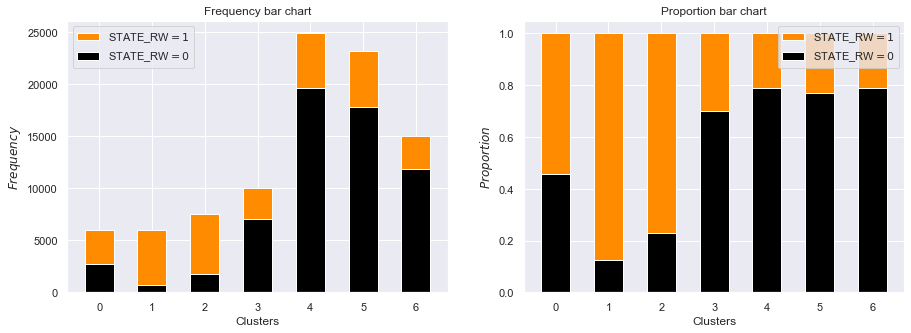

In [246]:
binary_profiling = ['DOMAIN_Urban','INCOME_7.0','INCOME_2.0','STATE_RS','STATE_RW']
for var in binary_profiling:
    bar_charts_categorical(data_clus, 'label', var)